In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def backward_rolling_average(signal: np.ndarray, window_size: int = 5) -> np.ndarray:
    if window_size <= 1 or window_size > len(signal):
        return signal.copy()

    smoothed = np.zeros_like(signal)
    current_sum = 0.0
    start_idx = 0

    for i in range(len(signal)):
        current_sum += signal[i]
        # Drop values that move out of the window
        if i - window_size >= 0:
            current_sum -= signal[i - window_size]
            start_idx += 1
        count = i - start_idx + 1
        smoothed[i] = current_sum / count

    return smoothed

def low_pass_filter(signal: np.ndarray, times: np.ndarray, cutoff: float, order: int = 2) -> np.ndarray:
    """
    Applies a Butterworth low-pass filter to the signal.

    Args:
        signal: The 1D numpy array to filter.
        times: The corresponding times array (assumed to be in ms).
        cutoff: The cutoff frequency in Hz.
        order: The order of the Butterworth filter.
    
    Returns:
        The filtered signal as a numpy array.
    """
    # Convert times from ms to seconds for correct sampling frequency calculation.
    dt = np.mean(np.diff(times)) / 1000.0  # average time step in seconds
    fs = 1.0 / dt                        # sampling frequency in Hz
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def plot_predictions_vs_truth(hdf5_file: str,
                              filter_method: str = "rolling",
                              rolling_window_size: int = 5,
                              lowpass_cutoff: float = 10.0,  # default cutoff frequency in Hz
                              lowpass_order: int = 2,
                              downsample_factor: int = 1):
    """
    Reads an HDF5 file containing shot-level predictions, times, and radial positions.
    Creates time-series plots of predictions vs. true labels for each shot and radial position.

    Args:
        hdf5_file: Path to the predictions.hdf5 file produced by your LightningModule.
        filter_method: "rolling" for rolling average smoothing, "lowpass" for low-pass filtering.
        rolling_window_size: Window size for the rolling average filter.
        lowpass_cutoff: Cutoff frequency in Hz for the low-pass filter (if filter_method is "lowpass").
        lowpass_order: Order of the Butterworth filter (if filter_method is "lowpass").
        downsample_factor: Factor by which to downsample the data (e.g., 10 means use every 10th prediction).
    """
    with h5py.File(hdf5_file, 'r') as f:
        # Each shot is stored as a top-level group in HDF5
        shot_ids = list(f.keys())  # e.g. ["191670", "199718", ...]

        for shot_id in shot_ids:
            group = f[shot_id]
            
            # Load each dataset into memory
            predictions = group["predictions"][()]        # shape: (N,)
            true_labels = group["true_labels"][()]         # shape: (N,)
            times       = group["times"][()]               # shape: (N,)
            r_positions = group["radial_positions"][()]    # shape: (N,)

            unique_rpos = np.unique(r_positions)
            for rpos in unique_rpos:
                # Create a mask for this radial position
                rp_mask  = (r_positions == rpos)

                # Subset each array
                rp_times = times[rp_mask]
                rp_preds = predictions[rp_mask]
                rp_trues = true_labels[rp_mask]

                # Sort by time so the plot does not look scrambled
                sort_idx = np.argsort(rp_times)
                rp_times = rp_times[sort_idx]
                rp_preds = rp_preds[sort_idx]
                rp_trues = rp_trues[sort_idx]

                # Downsample the data if needed
                if downsample_factor > 1:
                    rp_times = rp_times[::downsample_factor]
                    rp_preds = rp_preds[::downsample_factor]
                    rp_trues = rp_trues[::downsample_factor]
                print(rp_times)
                # Apply filtering based on the chosen method
                if filter_method == "rolling":
                    rp_preds_filtered = backward_rolling_average(rp_preds, window_size=rolling_window_size)
                    filter_label = f"model prediction (rolling avg, w={rolling_window_size})"
                elif filter_method == "lowpass":
                    rp_preds_filtered = low_pass_filter(rp_preds, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)
                    filter_label = f"model prediction (low-pass, cutoff={lowpass_cutoff}Hz, order={lowpass_order})"
                else:
                    raise ValueError("filter_method must be either 'rolling' or 'lowpass'.")

                # Plot
                plt.figure(figsize=(6, 4))
                plt.plot(rp_times, rp_preds_filtered, color='darkred', marker='o', label=filter_label, markersize=2, lw=0.5)
                plt.plot(rp_times, rp_trues, color='darkblue', marker='o', label="cctd ground truth", markersize=2, alpha=0.5)
                plt.xlabel("Time (ms)")
                plt.ylabel("Velocity (km/s)")
                plt.title(f"Shot {shot_id}, Radial position {rpos:.2f} cm")
                plt.legend()
                plt.ylim(-30, 10)
                # plt.xlim(4000, 6000)
                plt.grid(True, alpha=0.5)
                
                plt.show()

# hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35332011/predictions.hdf5" # 10x ds 
hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/34849261_copy/predictions.hdf5"
# hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35570167/predictions.hdf5"
# hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35736691/predictions_2.hdf5"
# hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35762302/predictions_4.hdf5"
# hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35767358/predictions_2.hdf5"
# hdf5_path_1 = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35767358/predictions_2_diff_norm.hdf5"
# hdf5_path_2 = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35767358/predictions_2_each_col_std.hdf5"
# hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/35833575/predictions_2.hdf5"




# plot_predictions_vs_truth(hdf5_file=hdf5_path, filter_method='rolling', rolling_window_size=1000)
# plot_predictions_vs_truth(hdf5_file=hdf5_path, filter_method='rolling', rolling_window_size=100)
# plot_predictions_vs_truth(hdf5_file=hdf5_path_1, filter_method='lowpass', lowpass_cutoff=100, lowpass_order=1, downsample_factor=10)
plot_predictions_vs_truth(hdf5_file=hdf5_path, filter_method='lowpass', lowpass_cutoff=100, lowpass_order=1, downsample_factor=10)


In [ ]:
import matplotlib as mpl
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 1.2,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'figure.dpi' : 200,
})

# If you prefer no top/right spines:
# mpl.rcParams["axes.spines.top"] = False
# mpl.rcParams["axes.spines.right"] = False

def backward_rolling_average(signal: np.ndarray, window_size: int = 5) -> np.ndarray:
    if window_size <= 1 or window_size > len(signal):
        return signal.copy()

    smoothed = np.zeros_like(signal)
    current_sum = 0.0
    start_idx = 0

    for i in range(len(signal)):
        current_sum += signal[i]
        # Drop values that move out of the window
        if i - window_size >= 0:
            current_sum -= signal[i - window_size]
            start_idx += 1
        count = i - start_idx + 1
        smoothed[i] = current_sum / count

    return smoothed

def low_pass_filter(signal: np.ndarray, times: np.ndarray, cutoff: float, order: int = 2) -> np.ndarray:
    """
    Applies a Butterworth low-pass filter to the signal.

    Args:
        signal: The 1D numpy array to filter.
        times: The corresponding times array (assumed to be in ms).
        cutoff: The cutoff frequency in Hz.
        order: The order of the Butterworth filter.
    
    Returns:
        The filtered signal as a numpy array.
    """
    # Convert times from ms to seconds
    dt = np.mean(np.diff(times)) / 1000.0  # average time step in seconds
    fs = 1.0 / dt                          # sampling frequency in Hz
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def plot_predictions_vs_truth(hdf5_file: str,
                              filter_method: str = "rolling",
                              rolling_window_size: int = 5,
                              lowpass_cutoff: float = 10.0,
                              lowpass_order: int = 2,
                              downsample_factor: int = 1,
                              colors=['#D55E00', '#0072B2']):
    """
    Reads an HDF5 file containing shot-level predictions, times, and radial positions.
    Creates time-series plots of predictions vs. true labels for each shot and radial position.
    """
    with h5py.File(hdf5_file, 'r') as f:
        shot_ids = list(f.keys())  # e.g. ["191670", "199718", ...]

        for shot_id in shot_ids:
            group = f[shot_id]
            
            predictions = group["predictions"][()]        
            true_labels = group["true_labels"][()]         
            times       = group["times"][()]               
            r_positions = group["radial_positions"][()]    

            unique_rpos = np.unique(r_positions)
            for rpos in unique_rpos:
                rp_mask  = (r_positions == rpos)

                rp_times = times[rp_mask]
                rp_preds = predictions[rp_mask]
                rp_trues = true_labels[rp_mask]

                # Sort by time
                sort_idx = np.argsort(rp_times)
                rp_times = rp_times[sort_idx]
                rp_preds = rp_preds[sort_idx]
                rp_trues = rp_trues[sort_idx]

                # Downsample
                if downsample_factor > 1:
                    rp_times = rp_times[::downsample_factor]
                    rp_preds = rp_preds[::downsample_factor]
                    rp_trues = rp_trues[::downsample_factor]

                # Filter
                if filter_method == "rolling":
                    rp_preds_filtered = backward_rolling_average(rp_preds, window_size=rolling_window_size)
                    rp_trues_filtered = backward_rolling_average(rp_trues, window_size=rolling_window_size)
                    filter_label = f"Model prediction (rolling avg, w={rolling_window_size})"
                elif filter_method == "lowpass":
                    rp_preds_filtered = low_pass_filter(rp_preds, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)
                    rp_trues_filtered = low_pass_filter(rp_trues, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)
                    filter_label = f"Model prediction (low-pass, cutoff={lowpass_cutoff}Hz, order={lowpass_order})"
                else:
                    raise ValueError("filter_method must be either 'rolling' or 'lowpass'.")

                # Plot
                fig, ax = plt.subplots(figsize=(6, 4))  # slightly larger figure
                ax.plot(rp_times, 
                        # rp_trues, 
                        rp_trues_filtered,
                        label="CCTD ground truth", 
                        # marker='s', 
                        # linestyle=':',     # Solid
                        color=colors[1],
                        lw=3.0, 
                        # ms=2, 
                        # alpha=0.8
                        )
                ax.plot(rp_times, rp_preds_filtered, 
                        # label=filter_label, 
                        label="smoothed NN result",
                        # marker='o', 
                        linestyle='-',     # Solid
                        color=colors[0],
                        lw=3.0, 
                        # ms=2,
                        # alpha=0.8,
                        )

                ax.set_xlabel("Time (ms)")
                # ax.set_ylabel(r"$v^{BES}_{\theta}$ (km/s) " + f"@ R = {rpos:.2f} cm")
                ax.set_ylabel(r"$v^{BES}_{\theta}$ (km/s)")
                ax.set_title(f"Shot {shot_id}, Radial position {rpos:.2f} cm")
                print(f"Shot {shot_id}, Radial position {rpos:.2f} cm")
                # ax.set_ylim(-40, 10)  # Adjust the limits as needed
                # ax.set_yticks(np.linspace(-40, 0, 4))
                # ax.set_xlim(700, 5200)
                # ax.set_xticks(np.linspace(700, 2400, 6))
                ax.legend()
                plt.tight_layout()
                plt.show()

                # Optionally, to save the figure instead of showing:
                # fig.savefig(f"shot_{shot_id}_rpos_{rpos:.2f}_plot.png", bbox_inches='tight', dpi=300)
                # plt.close(fig)

colors = ["#009E73", "#CC79A7"]
hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/37851165/predictions_0.hdf5"
plot_predictions_vs_truth(hdf5_file=hdf5_path, filter_method='lowpass', lowpass_cutoff=20, lowpass_order=1, downsample_factor=10, colors=colors)


In [ ]:
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 1.2,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'figure.dpi': 200,
})

# ===== Helper Functions for Filtering =====

def backward_rolling_average(signal: np.ndarray, window_size: int = 5) -> np.ndarray:
    if window_size <= 1 or window_size > len(signal):
        return signal.copy()

    smoothed = np.zeros_like(signal)
    current_sum = 0.0
    start_idx = 0

    for i in range(len(signal)):
        current_sum += signal[i]
        if i - window_size >= 0:
            current_sum -= signal[i - window_size]
            start_idx += 1
        count = i - start_idx + 1
        smoothed[i] = current_sum / count

    return smoothed

def low_pass_filter(signal: np.ndarray, times: np.ndarray, cutoff: float, order: int = 2) -> np.ndarray:
    """
    Applies a Butterworth low-pass filter to the signal.
    
    Args:
        signal: The 1D numpy array to filter.
        times: The corresponding times array (in milliseconds).
        cutoff: The cutoff frequency in Hz.
        order: The order of the filter.
    
    Returns:
        The filtered signal.
    """
    dt = np.mean(np.diff(times)) / 1000.0  # Convert ms to s
    fs = 1.0 / dt
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# ===== Helper Functions for Annotations =====

# Shot lists as provided.
# train_shots=['145384', '145388', '145391', '145410', '145419', '145425']
# validation_shots=['145385', '145422', '157373']
# test_shots=['145387',  '145420', '145427', '159443', '200635']

# train_shots=['145384', '145385', '145387', '145388', '145391', '145410', '145419', '145425', '145422','157373', '145420', '145427', '200635']
# validation_shots=['159443']
# test_shots=['159443']

# train_shots=['145384', '145387', '145388', '145391', '145410', '145419', '145425', '145422','157373', '145420', '145427', '200021', '200632', '200634', '200635', '200637', '200638', '200639']
# validation_shots=['159443', '145385', '200643']
# test_shots=['159443', '145385', '200643']

# train_shots=['145384', '145387', '145388', '145391', '145410', '145419', '145425', '145422','157373', '145420', '145427']
# validation_shots=['159443', '145385', '200643',  '200021', '200632', '200634', '200635', '200637', '200638', '200639']
# test_shots=['159443', '145385', '200643',  '200021', '200632', '200634', '200635', '200637', '200638', '200639']

train_shots=['145384', '145388', '145391', '145410', '145422','157373', '145420', '145427', '203659', '203667']
validation_shots=['145385', '145419', '200635',  '203671']
test_shots=['145387', '145425', '159443', '203660', '203672', '203665', '203663']


# Colors used for annotation (you can modify these later).
annotation_colors = {
    'training': '#D55E00',
    'validation': '#999999',
    'testing': '#0072B2',
}

def get_shot_label(shot_id):
    """Returns 'training', 'validation', or 'testing' based on shot id membership."""
    if shot_id in train_shots:
        return 'training'
    elif shot_id in validation_shots:
        return 'validation'
    elif shot_id in test_shots:
        return 'testing'
    else:
        return 'unknown'

def add_axvspan_for_radial(ax, shot_id, radial_idx, label_times, shot_radial_time_windows, time_unit='ms'):
    """
    Adds axvspan patches to the axis for a given shot and radial channel.
    
    Parameters:
      ax: matplotlib Axes object.
      shot_id: String shot identifier.
      radial_idx: Zero-indexed radial channel as computed from the confinement data.
      label_times: 1D array of time values (in ms).
      shot_radial_time_windows: Dict mapping shot ids to (dicts of) radial indices and intervals.
      time_unit: Units of time (ms).
      
    Behavior:
      If the metadata has an entry for this radial channel (matching by int or string),
      each given interval is highlighted. Otherwise, the whole time span is marked as testing.
    """
    shot_type = get_shot_label(shot_id)
    conv = 1.0  # no conversion needed since times are in ms
    spans_added = False

    # Attempt to look up the key using both integer and string forms.
    metadata = shot_radial_time_windows.get(shot_id, {})
    key_found = None
    if radial_idx in metadata:
        key_found = radial_idx
    elif str(radial_idx) in metadata:
        key_found = str(radial_idx)

    if key_found is not None:
        intervals = metadata[key_found]
        for interval in intervals:
            start, end = interval[0] * conv, interval[1] * conv
            patch_label = shot_type if not spans_added else ""
            ax.axvspan(start, end, alpha=0.2, color=annotation_colors[shot_type], label=patch_label)
            spans_added = True
    else:
        # If not defined, mark the full span as testing.
        ax.axvspan(label_times[0], label_times[-1], alpha=0.2, color=annotation_colors['testing'], label='testing')

def get_radial_mapping(confinement_data_file: str, shot_id: str):
    """
    Opens the confinement data file to retrieve the mapping of radial indices to actual radial positions.
    
    It expects the shot group to have an attribute "r_position" with 64 elements. If so, it reshapes
    them into an 8x8 array and takes the first row. Optionally, it reorders the row using the attribute
    "inboard_column_channel_order" if available.
    
    Returns:
      A 1D numpy array of radial positions (length 8) if available, otherwise None.
    """
    mapping = None
    with h5py.File(confinement_data_file, 'r') as df:
        if shot_id in df:
            shot_group = df[shot_id]
            r_position = shot_group.attrs.get("r_position", None)
            if r_position is not None and len(r_position) == 64:
                mapping = r_position.reshape(8, 8)[0, :].astype(np.float32)   
    return mapping

# ===== Main Plotting Function =====

# def plot_predictions_vs_truth(hdf5_file: str,
#                               confinement_data_file: str,
#                               shot_radial_time_windows: dict,
#                               filter_method: str = "rolling",
#                               rolling_window_size: int = 5,
#                               lowpass_cutoff: float = 10.0,
#                               lowpass_order: int = 2,
#                               downsample_factor: int = 1,
#                               colors=['#D55E00', '#0072B2']):
#     """
#     Reads an HDF5 file with shot-level predictions and true labels, then plots
#     smoothed time-series for each shot and radial position. Uses a separate confinement
#     data file to determine which radial indices (zero-indexed) were used in training/validation/testing.
    
#     Args:
#       hdf5_file: Path to the HDF5 file with predictions.
#       confinement_data_file: Path to the confinement data file for retrieving r_position and inboard order.
#       shot_radial_time_windows: Dict mapping shot ids to radial channel intervals.
#       filter_method: 'rolling' or 'lowpass'.
#       rolling_window_size: Window size for the rolling average.
#       lowpass_cutoff: Cutoff frequency for low-pass filtering (Hz).
#       lowpass_order: Order of the low-pass Butterworth filter.
#       downsample_factor: Factor for downsampling the data.
#       colors: Colors for plotting [prediction, ground truth].
#     """
#     with h5py.File(hdf5_file, 'r') as f:
#         shot_ids = list(f.keys())
#         for shot_id in shot_ids:
#             group = f[shot_id]
#             predictions = group["predictions"][()]        
#             true_labels = group["true_labels"][()]         
#             times       = group["times"][()]               
#             r_positions = group["radial_positions"][()]    

#             # Retrieve the mapping from radial index to radial position using the confinement data file.
#             radial_mapping = get_radial_mapping(confinement_data_file, shot_id)

#             # Iterate over unique radial positions in the predictions file.
#             unique_rpos = np.unique(r_positions)
#             for rpos in unique_rpos:
#                 rp_mask = (r_positions == rpos)
#                 rp_times = times[rp_mask]
#                 rp_preds = predictions[rp_mask]
#                 rp_trues = true_labels[rp_mask]

#                 # Sort by time.
#                 sort_idx = np.argsort(rp_times)
#                 rp_times = rp_times[sort_idx]
#                 rp_preds = rp_preds[sort_idx]
#                 rp_trues = rp_trues[sort_idx]

#                 # Downsample if required.
#                 if downsample_factor > 1:
#                     rp_times = rp_times[::downsample_factor]
#                     rp_preds = rp_preds[::downsample_factor]
#                     rp_trues = rp_trues[::downsample_factor]

#                 # Apply filtering.
#                 if filter_method == "rolling":
#                     rp_preds_filtered = backward_rolling_average(rp_preds, window_size=rolling_window_size)
#                     rp_trues_filtered = backward_rolling_average(rp_trues, window_size=rolling_window_size)
#                 elif filter_method == "lowpass":
#                     rp_preds_filtered = low_pass_filter(rp_preds, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)
#                     rp_trues_filtered = low_pass_filter(rp_trues, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)
#                 else:
#                     raise ValueError("filter_method must be either 'rolling' or 'lowpass'.")

#                 # Determine the corresponding radial index using the mapping.
#                 radial_idx = None
#                 if radial_mapping is not None:
#                     # Use a tolerance for floating-point comparison (here, 0.01).
#                     idx_candidates = np.where(np.isclose(radial_mapping, rpos, atol=0.1))[0]
#                     if idx_candidates.size > 0:
#                         radial_idx = int(idx_candidates[0])
#                     else:
#                         print(f"Warning: radial position {rpos} not found in mapping for shot {shot_id}.")
#                 else:
#                     print(f"Warning: No radial mapping available for shot {shot_id}.")
                
#                 # Create the figure and plot the time series.
#                 fig, ax = plt.subplots(figsize=(6, 4))
#                 ax.plot(rp_times, -1*rp_trues_filtered,
#                         label="CCTD ground truth", 
#                         linestyle='-',
#                         color=colors[1],
#                         lw=3.0)
#                 ax.plot(rp_times, -1*rp_preds_filtered, 
#                         label="smoothed NN result",
#                         linestyle='-',
#                         color=colors[0],
#                         lw=3.0)
                
#                 # Add axvspan annotations only if we determined a valid radial index.
#                 if radial_idx is not None:
#                     add_axvspan_for_radial(ax, shot_id, radial_idx, rp_times, shot_radial_time_windows, time_unit='ms')
#                 else:
#                     # Optionally, you could add a default annotation or skip.
#                     print(f"Skipping axvspan annotations for shot {shot_id} radial position {rpos:.2f} (no index found).")

#                 ax.set_xlabel("Time (ms)")
#                 ax.set_ylabel(r"$v^{BES}_{\theta}$ (km/s)")
#                 # ax.set_ylim(bottom=0)
#                 # ax.set_xlim(2000, 5000)
#                 ax.set_title(f"Shot {shot_id}, Radial position {rpos:.2f} cm")
#                 print(f"Shot {shot_id}, Radial position {rpos:.2f} cm")

#                 # Consolidate duplicate legend entries.
#                 handles, labels = ax.get_legend_handles_labels()
#                 by_label = dict(zip(labels, handles))
#                 ax.legend(by_label.values(), by_label.keys(), fontsize="xx-small")

#                 plt.tight_layout()
#                 plt.show()
#                 # Optionally, save figure:
#                 # fig.savefig(f"shot_{shot_id}_rpos_{rpos:.2f}_plot.png", bbox_inches='tight', dpi=300)
#                 # plt.close(fig)

def plot_predictions_vs_truth(hdf5_file: str,
                              confinement_data_file: str,
                              shot_radial_time_windows: dict,
                              filter_method: str = "rolling",
                              rolling_window_size: int = 5,
                              lowpass_cutoff: float = 10.0,
                              lowpass_order: int = 2,
                              downsample_factor: int = 1,
                              colors=['#D55E00', '#0072B2']):
    """
    Reads an HDF5 file with shot-level predictions and true labels, then plots
    smoothed time-series for each shot and radial position in a single figure
    with a column of subplots per shot.
    """
    with h5py.File(hdf5_file, 'r') as f:
        shot_ids = list(f.keys())
        for shot_id in shot_ids:
            group = f[shot_id]
            predictions = group["predictions"][()]
            true_labels  = group["true_labels"][()]
            times        = group["times_ms"][()]
            r_positions  = group["radial_positions"][()]

            # get sorted list of unique radial positions
            unique_rpos = np.sort(np.unique(r_positions))

            # create one figure with a column of subplots
            n_subplots = len(unique_rpos)
            fig, axes = plt.subplots(n_subplots, 1,
                                     figsize=(7, 3 * n_subplots),
                                     sharex=True)
            # if there's only one subplot, put it in a list for uniform handling
            if n_subplots == 1:
                axes = [axes]

            # add a big suptitle
            fig.suptitle(f"Shot {shot_id}", fontsize=18)
            
            for idx, rpos in enumerate(unique_rpos):
                ax = axes[idx]
                rp_mask = (r_positions == rpos)
                rp_times = times[rp_mask]
                rp_preds = predictions[rp_mask]
                rp_trues = true_labels[rp_mask]

                # sort by time
                sort_idx = np.argsort(rp_times)
                rp_times = rp_times[sort_idx]
                rp_preds = rp_preds[sort_idx]
                rp_trues = rp_trues[sort_idx]

                # downsample
                if downsample_factor > 1:
                    rp_times = rp_times[::downsample_factor]
                    rp_preds = rp_preds[::downsample_factor]
                    rp_trues = rp_trues[::downsample_factor]
                print(rp_times[:10])
                # filter
                if filter_method == "rolling":
                    rp_preds_f = backward_rolling_average(rp_preds, window_size=rolling_window_size)
                    rp_trues_f = backward_rolling_average(rp_trues, window_size=rolling_window_size)
                else:
                    rp_preds_f = low_pass_filter(rp_preds, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)
                    rp_trues_f = low_pass_filter(rp_trues, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)

                # map to radial index
                radial_idx = None
                radial_mapping = get_radial_mapping(confinement_data_file, shot_id)
                if radial_mapping is not None:
                    idx_cands = np.where(np.isclose(radial_mapping, rpos, atol=0.1))[0]
                    if idx_cands.size:
                        radial_idx = int(idx_cands[0])

                # plot
                ax.plot(rp_times, -1 * rp_trues_f,
                        label="CCTD ground truth",
                        linestyle='-', color=colors[1], lw=2.5)
                ax.plot(rp_times, -1 * rp_preds_f,
                        label="NN result",
                        linestyle='-', color=colors[0], lw=2.5)

                # annotations
                if radial_idx is not None:
                    add_axvspan_for_radial(ax, shot_id, radial_idx,
                                          rp_times, shot_radial_time_windows)
                else:
                    # fallback: mark full span as testing
                    ax.axvspan(rp_times[0], rp_times[-1],
                               alpha=0.2, color=annotation_colors['testing'],
                               label='testing')

                # labels & legend
                ax.set_ylabel(r"$v^{BES}_{\theta}$ (km/s)")
                # ax.set_ylim(0,30)
                ax.set_title(f"r = {rpos:.2f} cm", fontsize=14)
                handles, labels = ax.get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                ax.legend(by_label.values(), by_label.keys(), fontsize="xx-small")

                # hide x‐tick labels for all but the bottom subplot
                if idx < n_subplots - 1:
                    ax.label_outer()

            # only bottom axis gets the x-axis label
            axes[-1].set_xlabel("Time (ms)")

            plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
            plt.show()


# ===== Usage =====
shot_radial_time_windows={
    '145384': {0: [[1600, 5000]], 1: [[1600, 5000]], 2: [[1600, 5000]], 3: [[1300, 5000]], 4: [[1300, 5000]], 5: [[1300, 5000]], 6: [[1400, 2400], [2600, 5000]], 7: [[2600, 5000]]}, 
    '145385': {0: [[2500, 4200]], 1: [[2500, 4200]], 2: [[2500, 4200]], 3: [[2500, 4200]], 4: [[2500, 4200]], 5: [[2500, 4200]], 6: [[2500, 4200]], 7: [[2500, 4200]]}, 
    '145387': {0: [[1800, 5150]], 1: [[1400, 5150]], 2: [[1900, 5150]], 3: [[2400, 5150]], 4: [[1200, 5150]], 5: [[900, 5150]], 6: [[2000, 5150]], 7: [[2000, 4000], [4100, 5150]]}, 
    '145388': {0: [[1800, 5100]], 1: [[1600, 5100]], 2: [[2000, 5100]], 3: [[2000, 5100]], 4: [[1100, 5100]], 5: [[1800, 5100]], 6: [[1800, 5100]], 7: [[2000, 5100]]}, 
    '145391': {0: [[1900, 4200]], 1: [[1900, 4200]], 2: [[2400, 4200]], 3: [[2400, 4200]], 4: [[1100, 4300]], 5: [[1400, 4300]], 6: [[2400, 4300]], 7: [[2600, 4200]]}, 
    '145410': {0: [[1300, 3400]], 1: [[1300, 3400]], 2: [[1300, 3400]], 3: [[2200, 3400]], 4: [[1100, 3400]], 5: [[1000, 3400]], 6: [[1000, 3400]], 7: [[1800, 2400], [2500, 3400]]},
    '145419': {0: [[1700, 5100]], 1: [[1000, 5100]], 2: [[2000, 5100]], 3: [[2400, 4700]], 4: [[2000, 5100]], 5: [[1400, 5100]], 6: [[1800, 5100]], 7: [[1800, 5100]]}, 
    '145420': {0: [[1400, 4500]], 1: [[1400, 4600]], 2: [[1400, 4500]], 3: [[1800, 4500]], 4: [[1200, 4400]], 5: [[1200, 4500]], 6: [[1500, 4500]], 7: [[1800, 2400], [2800, 4500]]}, 
    '145422': {0: [[1800, 4800]], 1: [[1800, 4800]], 2: [[1800, 4800]], 3: [[2000, 4800]], 4: [[1800, 4800]], 5: [[1300, 4800]], 6: [[1800, 4800]], 7: [[1800, 4800]]}, 
    '145425': {0: [[1300, 5100]], 1: [[1300, 5100]], 2: [[2000, 5100]], 3: [[2100, 5100]], 4: [[1200, 5100]], 5: [[1200, 5100]], 6: [[1800, 5100]], 7: [[2600, 5200]]}, 
    '145427': {0: [[1300, 5200]], 1: [[1300, 5200]], 2: [[1300, 5200]], 3: [[2000, 5200]], 4: [[1600, 5200]], 5: [[1500, 5200]], 6: [[1800, 3800], [3900, 5200]], 7: [[2600, 5200]]}, 
    '157373': {0: [[1600, 6000]], 1: [[1700, 6000]], 2: [[2200, 6000]], 3: [[1400, 6000]], 4: [[1600, 6000]], 5: [[2000, 6000]], 6: [[2500, 5500], [5600, 6000]], 7: [[3000, 5200]]}, 
    '159443': {0: [[1800, 5400]], 1: [[2400, 5000]], 2: [[2200, 5400]], 3: [[2400, 5300]], 4: [[1600, 5300]], 5: [[1800, 5400]], 6: [[2600, 5300]], 7: [[2800, 5400]]}, 
    '200021': {0: [[1800, 4300]], 1: [[2200, 3900]], 3: [[1600, 3800]], 4: [[1700, 2400]]},
    '200632': {0: [[2000, 4500]], 1: [[2000, 3000]], 4: [[1100, 1800], [4400, 4700]], 5: [[1100, 1800], [4400, 4700]], 6: [[1100, 1600], [4400, 4700]]},
    '200634': {0: [[2000, 3400], [3500, 4500]], 1: [[2000, 4500]], 2: [[1900, 4600]], 3: [[1400, 2400]], 4: [[4000, 4600]], 6:[[4000, 4500]]},
    '200635': {0: [[400, 1000]], 1: [[400, 1000]], 4: [[1200, 2500]]},
    '200637': {0: [[1900, 3700]], 1: [[400, 800]], 2: [[1900, 3800]], 3: [[1100, 1700]], 4: [[1100, 1700]], 5: [[1100, 1700]]},
    '200638': {0: [[1800, 3400]], 1: [[3000, 4600]], 2: [[1800, 3000]], 3: [[1000, 1800]], 4: [[1000, 3600]], 5: [[1000, 3600]]},
    '200639': {0: [[3000, 4600]], 1: [[2800, 3200], [3400, 4000]], 3: [[1000, 4600]], 4: [[1000, 4600]], 5: [[1400, 4700]], 6: [[1400, 4700]]},
    '200643': {0: [[2300, 4500]], 1: [[400, 800]], 2: [[2100, 4700]], 3: [[1100, 4700]], 4: [[1100, 4700]], 5: [[1100, 4700]], 6: [[1100, 4700]]},
    '203659': {0: [[1800, 4500]], 1: [[2000, 3000]], 2: [[2100, 3100], [4200, 4600]], 3: [[1100, 2400], [4000, 4600]], 4: [[1200, 3000]], 5: [[1200, 2200]]},
    '203660': {0: [[2000, 3900]], 1: [[2000, 3000]], 2: [[1200, 2800]], 3: [[1200, 2400]], 4: [[1200, 2000]], 5: [[1200, 2000]], 6: [[1200, 2000]]},
    '203663': {0: [[2500, 4600]], 2: [[1100, 1900]], 3: [[1100, 3000]], 4: [[1100, 2500]], 5: [[1100, 2200]]},
    '203664': {0: [[2600, 4600]], 2: [[1200, 3000]], 3: [[1200, 4000]], 5: [[1200, 4000]], 6: [[1200, 4000]]},
    '203665': {0: [[2200, 4600]], 2: [[1100, 3000]], 3: [[1000, 3000]], 5: [[1000, 3000]]},
    '203667': {0: [[2200, 4600]], 2: [[1100, 3000]], 3: [[1100, 3000]], 4: [[1100, 4000]], 5: [[1100, 3000]], 6: [[1600, 2400]]},
    '203671': {0: [[2600, 4800]], 3: [[1200, 3000]], 4: [[1200, 3000]], 5: [[1200, 2600]], 6: [[1500, 2400]]},
    '203672': {0: [[2200, 4600]], 2: [[1200, 2400]], 3: [[1100, 3000]], 4: [[1000, 2400]], 5: [[1200, 2000]], 6: [[1800, 3000]]},
}

# Colors for prediction/truth lines.
line_colors = ["#882255", "#009E73"]

# Paths to files.
hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/41825238/predictions_10.hdf5"

confinement_data_file = "/pscratch/sd/k/kevinsg/bes_ml_jobs/confinement_data/20250730_psi_interp.hdf5"

# Call the plotting function with the integrated mapping.
plot_predictions_vs_truth(
    hdf5_file=hdf5_path,
    confinement_data_file=confinement_data_file,
    shot_radial_time_windows=shot_radial_time_windows,
    filter_method='lowpass',
    lowpass_cutoff=20,
    lowpass_order=1,
    # downsample_factor=10,
    colors=line_colors
)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

def plot_predictions_vs_truth(hdf5_file: str,
                              confinement_data_file: str | None,
                              shot_radial_time_windows: dict | None,
                              filter_method: str = "rolling",
                              rolling_window_size: int = 5,
                              lowpass_cutoff: float = 10.0,
                              lowpass_order: int = 2,
                              downsample_factor: int = 1,
                              colors=('tab:orange','tab:blue'),
                              shade_color='#cfe8ff',
                              shade_alpha=0.25,
                              draw_event_vlines: bool = True,
                              label_tolerance_ms: float = 0.6):
    """
    New fixed-ψ plotting:
      - predictions: scalar vθ per time
      - if true_labels in the prediction HDF5 are NaN/missing, we pull truth from
        `confinement_data_file[shot/interpolated_psi/psi_*]` and align to times.
    """

    # ---------- helpers ----------
    def _format_psi_key(psi: float) -> str:
        s = f"{psi:.3f}".rstrip('0').rstrip('.')
        s = s.replace('.', 'p')
        return f"psi_{s}"

    def _merge_intervals(intervals):
        if not intervals: return []
        ints = sorted((float(a), float(b)) for a, b in intervals)
        merged = [list(ints[0])]
        for a, b in ints[1:]:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
        return merged

    def _merged_windows_for_shot(shot_id, windows_dict):
        if not windows_dict: return []
        sd = windows_dict.get(str(shot_id), {})
        all_ints = [span for spans in sd.values() for span in spans]
        return _merge_intervals(all_ints)

    def _backward_rolling_average(x, window_size=5):
        if window_size <= 1: return x
        x = np.asarray(x, float)
        out = np.copy(x)
        csum = np.cumsum(np.insert(x, 0, 0.0))
        n = x.size
        for i in range(n):
            j0 = max(0, i - window_size + 1)
            out[i] = (csum[i+1] - csum[j0]) / (i - j0 + 1)
        return out

    def _low_pass_filter(y, t_ms, cutoff=10.0, order=2):
        try:
            from scipy.signal import butter, filtfilt
            y = np.asarray(y, float); t = np.asarray(t_ms, float)
            dt_s = np.median(np.diff(t)) / 1000.0
            fs = 1.0 / max(dt_s, 1e-9)
            b, a = butter(order, Wn=cutoff/(0.5*fs), btype='low')
            return filtfilt(b, a, y, method="gust")
        except Exception:
            return y

    def _smooth(vec, tvec, method, win, fc, order):
        vec = np.asarray(vec, float)
        mask = np.isfinite(vec)
        out = np.full_like(vec, np.nan, dtype=float)
        if mask.any():
            if method == "rolling":
                out[mask] = _backward_rolling_average(vec[mask], window_size=win)
            else:
                out[mask] = _low_pass_filter(vec[mask], tvec[mask], cutoff=fc, order=order)
        return out

    def _align_truth_to_times(times_ms, label_times_ms, label_values, tol_ms=0.6):
        """nearest-neighbor with tolerance; NaN if no neighbor within tol."""
        t = np.asarray(times_ms, float)
        lt = np.asarray(label_times_ms, float)
        lv = np.asarray(label_values, float)
        if t.size == 0 or lt.size == 0:
            return np.full(t.shape, np.nan, dtype=float)
        # for each t, find nearest label time
        idx = np.searchsorted(lt, t, side='left')
        idx = np.clip(idx, 0, lt.size-1)
        left = np.clip(idx-1, 0, lt.size-1)
        use_left = np.abs(t - lt[left]) < np.abs(t - lt[idx])
        nn = np.where(use_left, left, idx)
        out = lv[nn]
        out[np.abs(t - lt[nn]) > tol_ms] = np.nan
        return out.astype(np.float64)

    # ---------- main ----------
    with h5py.File(hdf5_file, 'r') as f:
        # read ψ target if stored
        psi_target = None
        if "_meta" in f:
            try:
                psi_target = float(f["_meta"].attrs.get("label_target_psi", np.nan))
                if not np.isfinite(psi_target): psi_target = None
            except Exception:
                psi_target = None

        shot_ids = [k for k in f.keys() if not k.startswith('_')]
        if not shot_ids:
            print("No shot groups found in predictions file.")
            return

        for shot_id in shot_ids:
            g = f[shot_id]
            if not all(k in g for k in ("predictions", "true_labels", "times_ms")):
                print(f"Skipping shot {shot_id}: missing datasets.")
                continue

            preds = np.asarray(g["predictions"][()], float)
            trues = np.asarray(g["true_labels"][()], float)
            t_ms  = np.asarray(g["times_ms"][()],    float)
            events = None
            if "events" in g:
                try: events = g["events"][()].astype(str)
                except Exception: events = None
            
            print(trues)
            # sort by time
            order = np.argsort(t_ms)
            t_ms, preds, trues = t_ms[order], preds[order], trues[order]
            if events is not None: events = events[order]

            # optional downsample
            if downsample_factor > 1:
                sl = slice(None, None, downsample_factor)
                t_ms, preds, trues = t_ms[sl], preds[sl], trues[sl]
                if events is not None: events = events[sl]

            # if no finite truth in saved file, pull from confinement file (if provided)
            if not np.isfinite(trues).any() and confinement_data_file and psi_target is not None:
                psi_key = _format_psi_key(psi_target)
                with h5py.File(confinement_data_file, 'r') as cf:
                    path = f"{shot_id}/interpolated_psi/{psi_key}"
                    if path in cf:
                        lt = cf[path]["label_times"][()]
                        lv = cf[path]["vZ"][()]
                        trues = _align_truth_to_times(t_ms, lt, lv, tol_ms=label_tolerance_ms)
                    else:
                        print(f"Shot {shot_id}: no truth at {psi_key} in confinement file.")

            # smooth
            preds_f = _smooth(preds, t_ms, filter_method, rolling_window_size, lowpass_cutoff, lowpass_order)
            trues_f = _smooth(trues, t_ms, filter_method, rolling_window_size, lowpass_cutoff, lowpass_order)

            # figure
            fig, ax = plt.subplots(1, 1, figsize=(9, 4))
            fig.suptitle(f"Shot {shot_id}", fontsize=16)

            # shade merged time windows (old dict format → merged spans)
            for a, b in _merged_windows_for_shot(shot_id, shot_radial_time_windows):
                ax.axvspan(a, b, color=shade_color, alpha=shade_alpha)

            # event boundaries
            if draw_event_vlines and events is not None and events.size > 1:
                change = np.where(events[1:] != events[:-1])[0]
                for idx in change:
                    ax.axvline(t_ms[idx], color='0.7', linestyle='--', linewidth=1)

            # plot (keep your sign convention)
            ax.plot(t_ms, -preds_f, label="NN result", lw=2.0, color=colors[0])
            if np.isfinite(trues_f).any():
                ax.plot(t_ms, -trues_f, label="CCTD ground truth", lw=2.0, color=colors[1])
            else:
                print(f"Shot {shot_id}: ground truth unavailable (all NaN).")

            ax.set_ylabel(r"$v^{BES}_{\theta}$ (km/s)")
            ax.set_xlabel("Time (ms)")
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), fontsize="small", loc="best")
            ax.grid(True, alpha=0.25)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 1.2,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi' : 200,
})

def plot_predictions_vs_truth(
    hdf5_file: str,
    confinement_data_file: str,
    shot_radial_time_windows: dict | None,
    psi_target: float = 0.90,           # <-- target ψ here
    label_tolerance_ms: float = 0.6,    # nearest-neighbor tolerance in ms
    filter_method: str = "rolling",
    rolling_window_size: int = 5,
    lowpass_cutoff: float = 10.0,
    lowpass_order: int = 2,
    downsample_factor: int = 1,
    colors=('tab:orange','tab:blue'),
    shade_color='#cfe8ff',
    shade_alpha=0.25,
    draw_event_vlines: bool = True,
):
    """Plot NN predictions vs. CCTD ground truth at fixed ψ using nearest-neighbor (no interpolation)."""

    # ---- helpers ----
    def _format_psi_key(psi: float) -> str:
        s = f"{psi:.3f}".rstrip('0').rstrip('.')
        return "psi_" + s.replace('.', 'p')

    def _merge_intervals(intervals):
        if not intervals: return []
        ints = sorted((float(a), float(b)) for a, b in intervals)
        merged = [list(ints[0])]
        for a, b in ints[1:]:
            if a <= merged[-1][1]:
                merged[-1][1] = max(merged[-1][1], b)
            else:
                merged.append([a, b])
        return merged

    def _merged_windows_for_shot(shot_id, windows_dict):
        if not windows_dict: return []
        sd = windows_dict.get(str(shot_id), {})
        all_ints = [span for spans in sd.values() for span in spans]
        return _merge_intervals(all_ints)

    def _backward_rolling_average(x, window_size=5):
        if window_size <= 1: return x
        x = np.asarray(x, float)
        out = np.copy(x)
        csum = np.cumsum(np.insert(x, 0, 0.0))
        for i in range(x.size):
            j0 = max(0, i - window_size + 1)
            out[i] = (csum[i+1] - csum[j0]) / (i - j0 + 1)
        return out

    def _low_pass_filter(y, t_ms, cutoff=10.0, order=2):
        try:
            from scipy.signal import butter, filtfilt
            y = np.asarray(y, float); t = np.asarray(t_ms, float)
            dt_s = np.median(np.diff(t)) / 1000.0
            fs = 1.0 / max(dt_s, 1e-9)
            b, a = butter(order, Wn=cutoff/(0.5*fs), btype='low')
            return filtfilt(b, a, y, method="gust")
        except Exception:
            return y

    def _smooth(vec, tvec, method, win, fc, order):
        vec = np.asarray(vec, float)
        mask = np.isfinite(vec)
        out = np.full_like(vec, np.nan, dtype=float)
        if mask.any():
            out[mask] = (_backward_rolling_average(vec[mask], win)
                         if method == "rolling" else
                         _low_pass_filter(vec[mask], tvec[mask], cutoff=fc, order=order))
        return out

    def _align_truth_to_times(times_ms, label_times_ms, label_values, tol_ms=0.6):
        """Nearest neighbor (no interpolation). NaN if no label time within tol."""
        t  = np.asarray(times_ms, float)
        lt = np.asarray(label_times_ms, float)
        lv = np.asarray(label_values, float)
        if t.size == 0 or lt.size == 0:
            return np.full(t.shape, np.nan, dtype=float)
        idx  = np.searchsorted(lt, t, side='left')
        idx  = np.clip(idx, 0, lt.size-1)
        left = np.clip(idx-1, 0, lt.size-1)
        use_left = np.abs(t - lt[left]) < np.abs(t - lt[idx])
        nn   = np.where(use_left, left, idx)
        out  = lv[nn]
        out[np.abs(t - lt[nn]) > tol_ms] = np.nan
        return out

    # ---- main ----
    psi_key = _format_psi_key(psi_target)

    with h5py.File(hdf5_file, 'r') as f_pred, h5py.File(confinement_data_file, 'r') as f_conf:
        shot_ids = [k for k in f_pred.keys() if not k.startswith('_')]
        if not shot_ids:
            print("No shot groups found in predictions file.")
            return

        for shot_id in shot_ids:
            g = f_pred[shot_id]
            if not all(k in g for k in ("predictions", "times_ms")):
                print(f"Skipping shot {shot_id}: missing predictions/times_ms.")
                continue

            preds = np.asarray(g["predictions"][()], float)
            if preds.ndim == 2:   # e.g., (N, 4) from old runs
                preds = preds[:, 0]
            print(preds.shape)
            t_ms  = np.asarray(g["times_ms"][()],    float)
            events = None
            if "events" in g:
                try: events = g["events"][()].astype(str)
                except Exception: events = None

            # sort & downsample
            order = np.argsort(t_ms)
            t_ms, preds = t_ms[order], preds[order]
            if events is not None: events = events[order]
            if downsample_factor > 1:
                sl = slice(None, None, downsample_factor)
                t_ms, preds = t_ms[sl], preds[sl]
                if events is not None: events = events[sl]

            # pull truth at ψ directly from confinement file (no interpolation),
            # then align to t_ms via nearest neighbor within tolerance
            conf_path = f"{shot_id}/interpolated_psi/{psi_key}"
            if conf_path not in f_conf:
                print(f"Shot {shot_id}: {conf_path} not found in confinement file.")
                continue
            lt = np.asarray(f_conf[conf_path]["label_times"][()], float)  # ms
            lv = np.asarray(f_conf[conf_path]["vZ"][()],         float)  # same length

            trues = _align_truth_to_times(t_ms, lt, lv, tol_ms=label_tolerance_ms)

            # smooth
            preds_f = _smooth(preds, t_ms, filter_method, rolling_window_size, lowpass_cutoff, lowpass_order)
            trues_f = _smooth(trues, t_ms, filter_method, rolling_window_size, lowpass_cutoff, lowpass_order)

            # figure
            # fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
            fig, ax = plt.subplots(1, 1, figsize=(10, 3))
            fig.suptitle(f"Shot {shot_id}  |  ψ={psi_target:.2f}", fontsize=12)

            # shade windows (merged across columns)
            # for a, b in _merged_windows_for_shot(shot_id, shot_radial_time_windows):
            #     ax.axvspan(a, b, color=shade_color, alpha=shade_alpha)

            # event boundaries
            if draw_event_vlines and events is not None and events.size > 1:
                change = np.where(events[1:] != events[:-1])[0]
                for idx in change:
                    ax.axvline(t_ms[idx], color='0.7', linestyle='--', linewidth=1)

            # plot (keep your sign convention)
            ax.plot(t_ms, -preds_f, label="NN result", lw=2.0, color=colors[0], zorder=1, alpha=0.8)
            if np.isfinite(trues_f).any():
                ax.plot(t_ms, -trues_f, label="CCTD ground truth", linestyle="--", lw=1.5, color=colors[1], zorder=0)
            else:
                print(f"Shot {shot_id}: aligned truth all NaN (check tolerance {label_tolerance_ms} ms).")

            ax.set_ylabel(r"$v^{BES}_{\theta}$ (km/s)")
            ax.set_xlabel("Time (ms)")
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), fontsize="small", loc="best")
            ax.grid(True, alpha=0.25)
            # plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.tight_layout()
            plt.show()


(92498,)


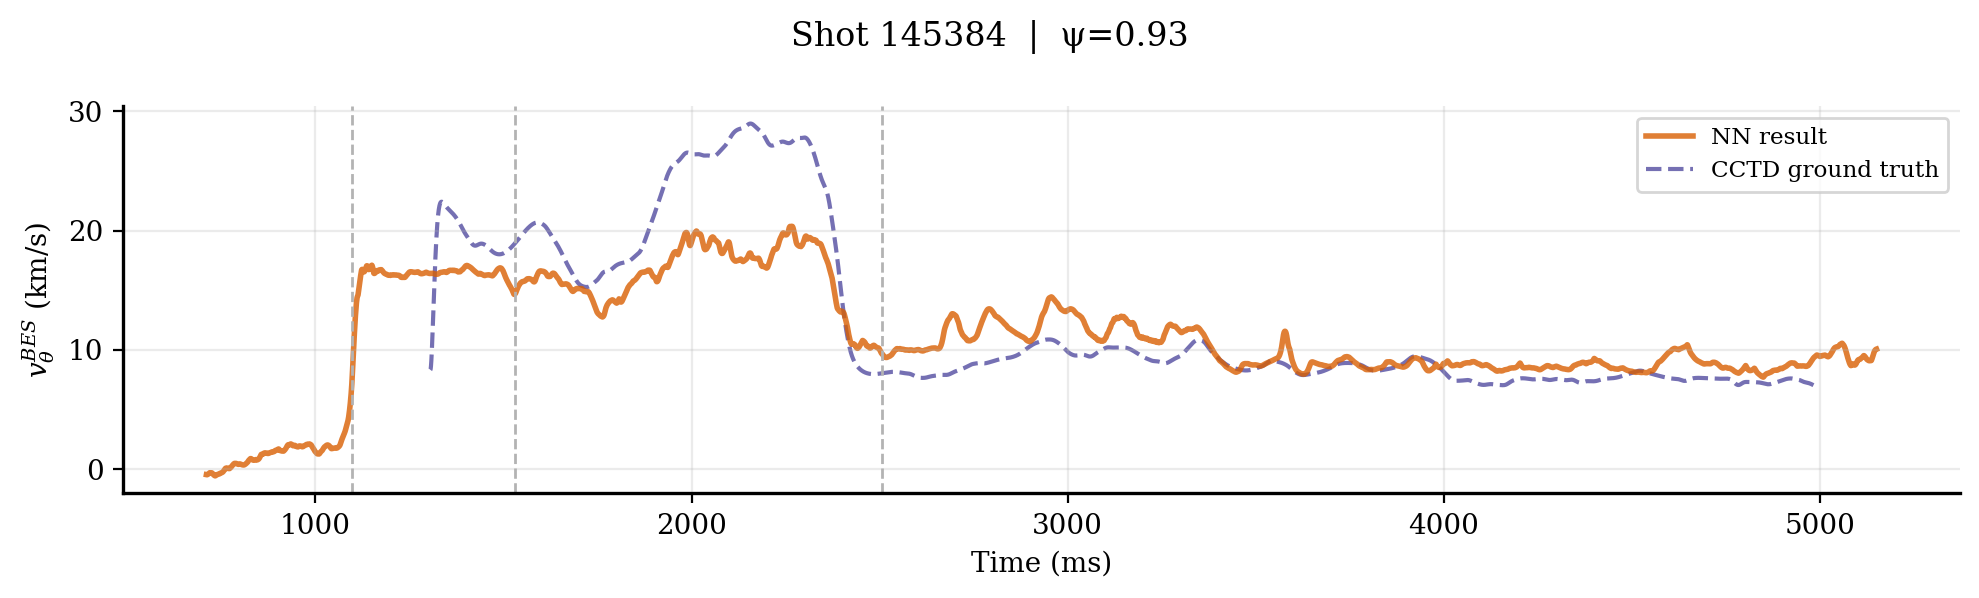

(87286,)


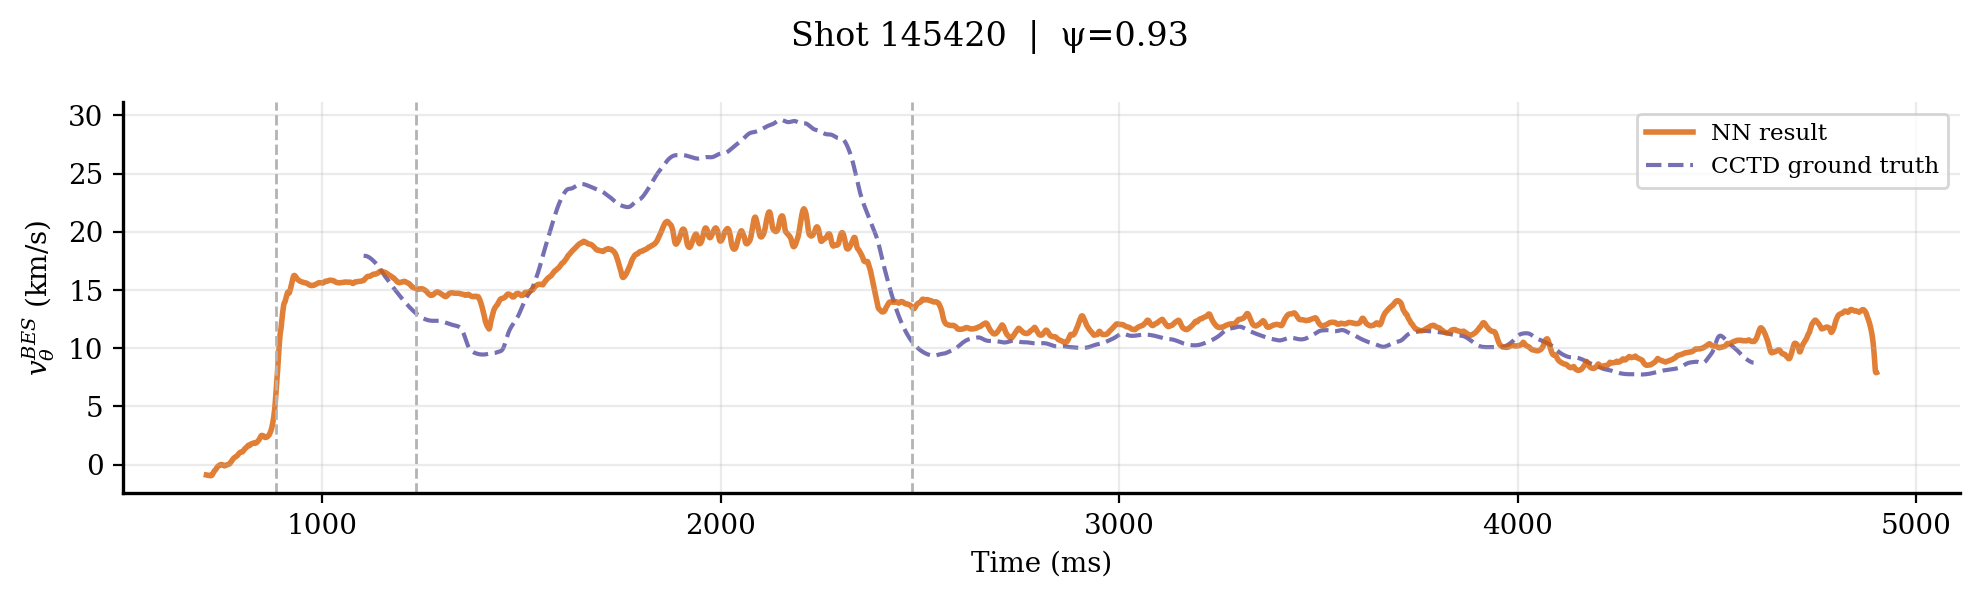

(91664,)


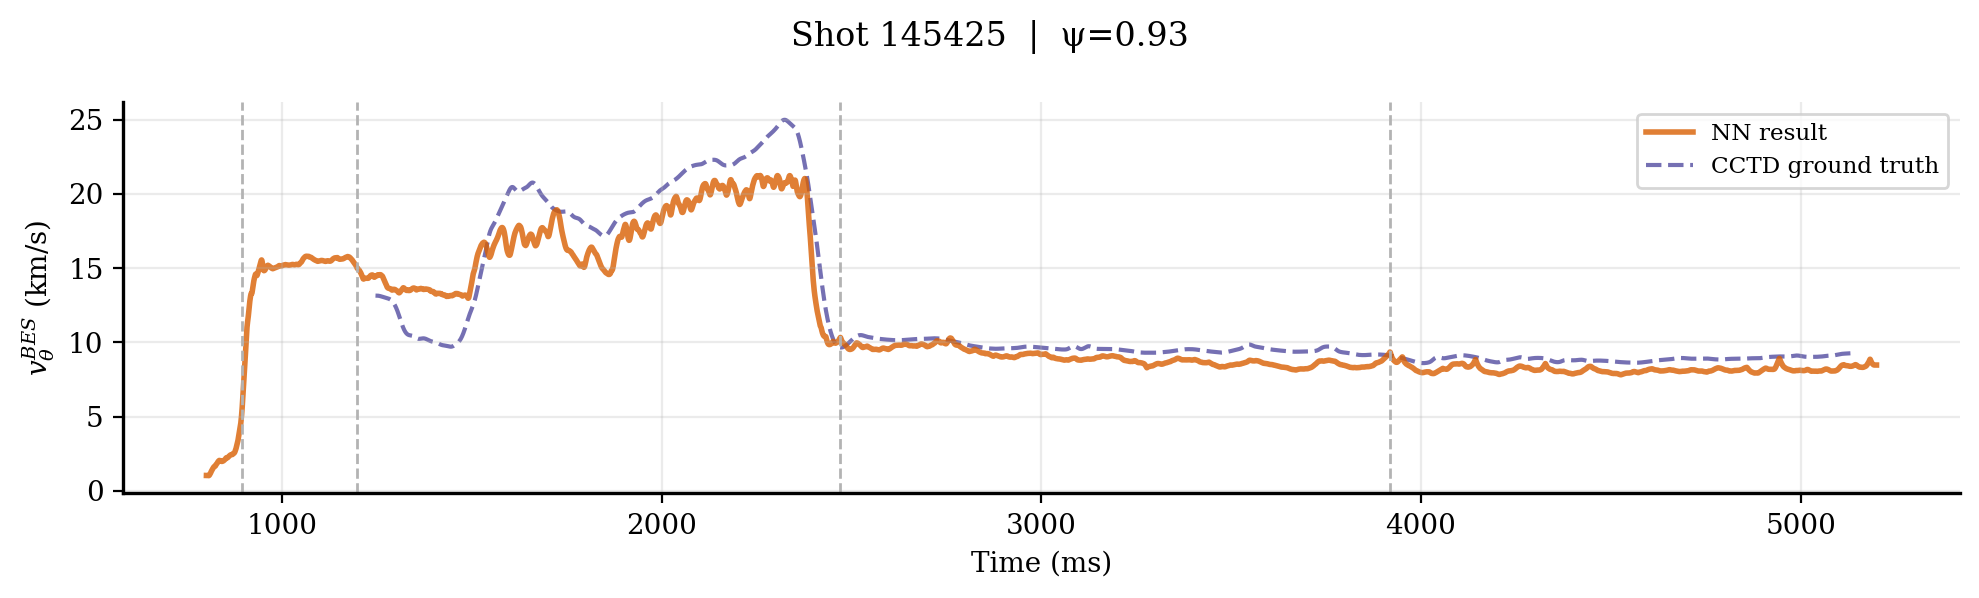

(95832,)


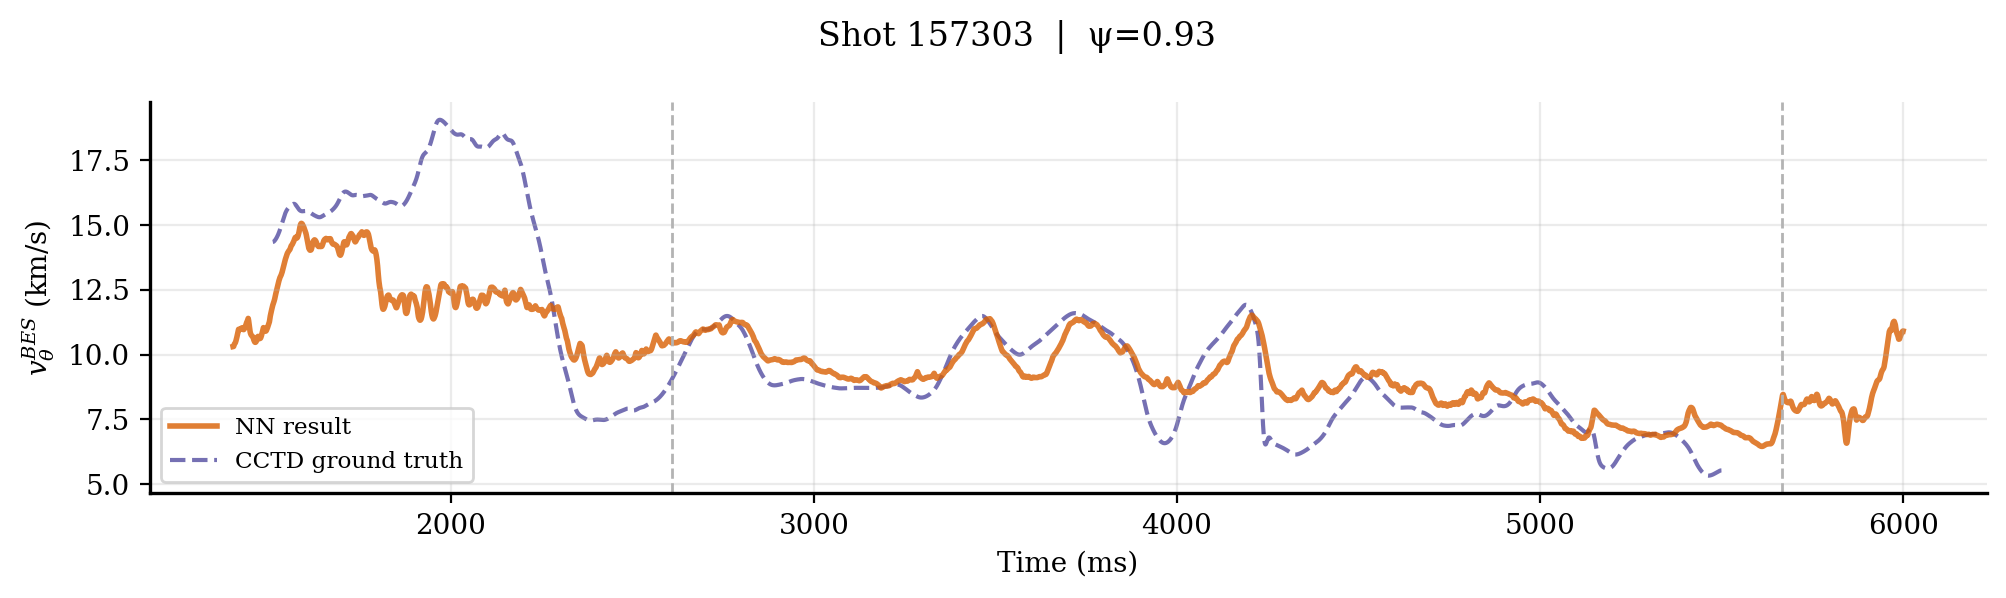

(112352,)


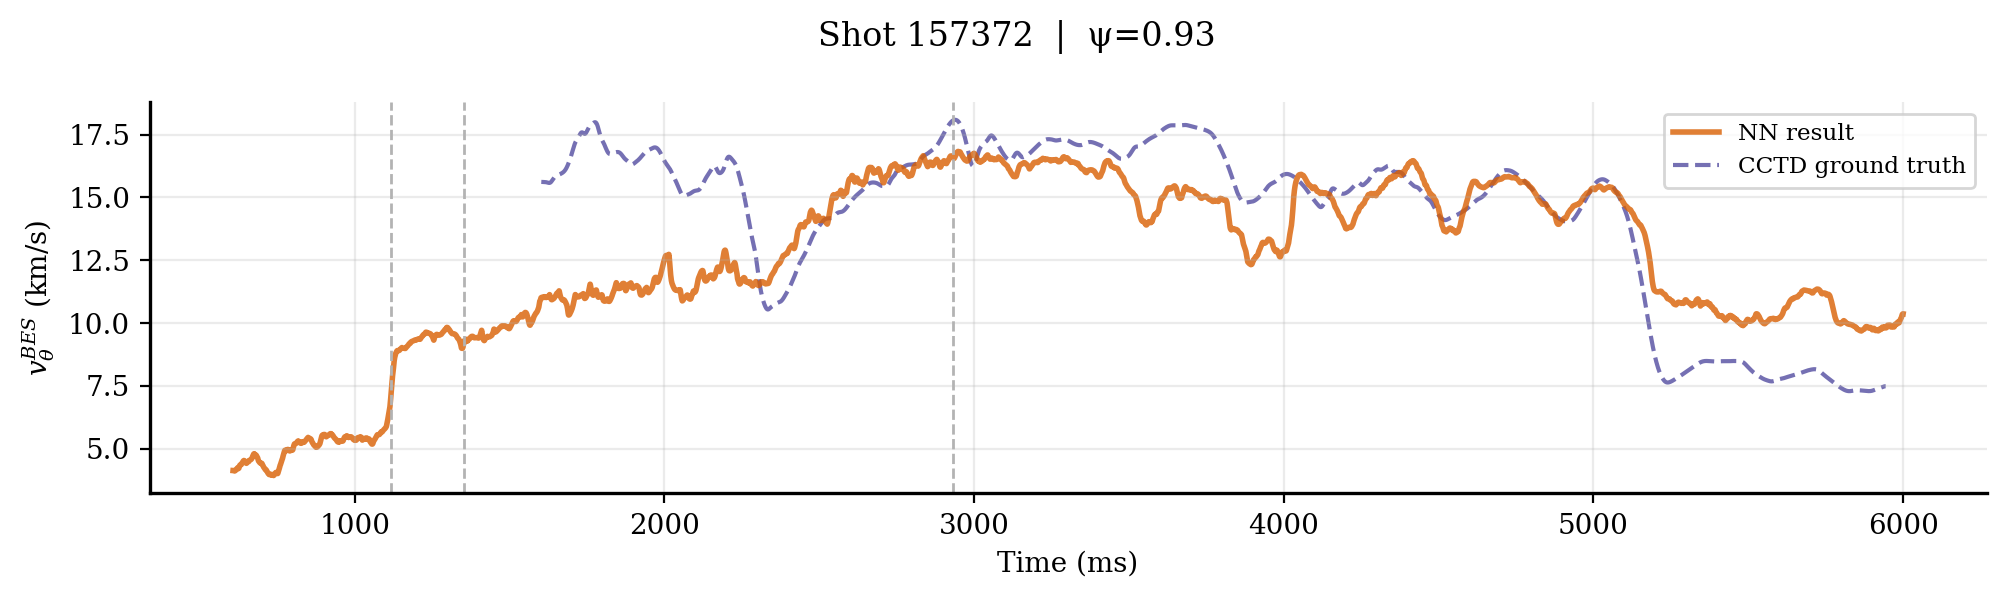

(112496,)


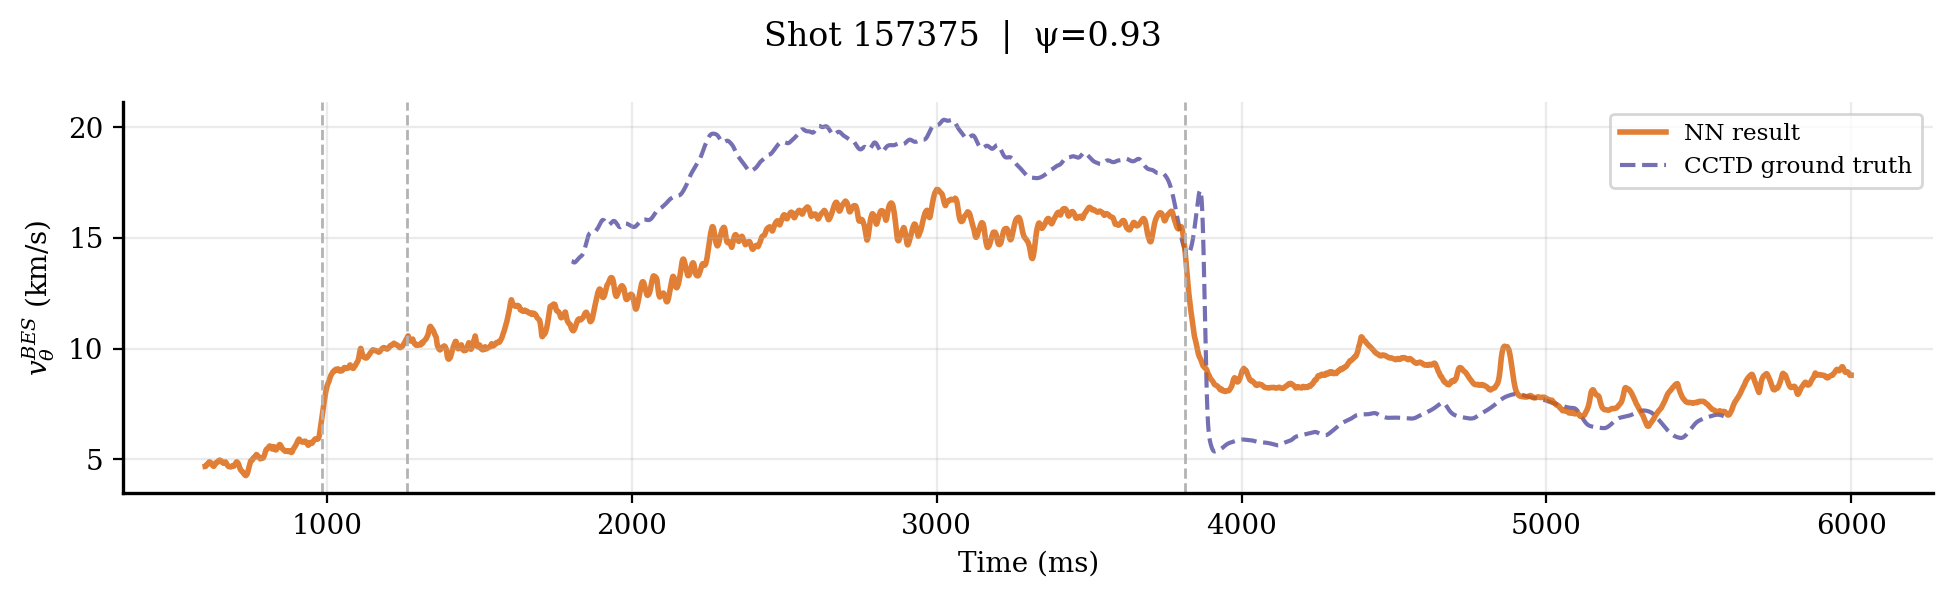

(116665,)


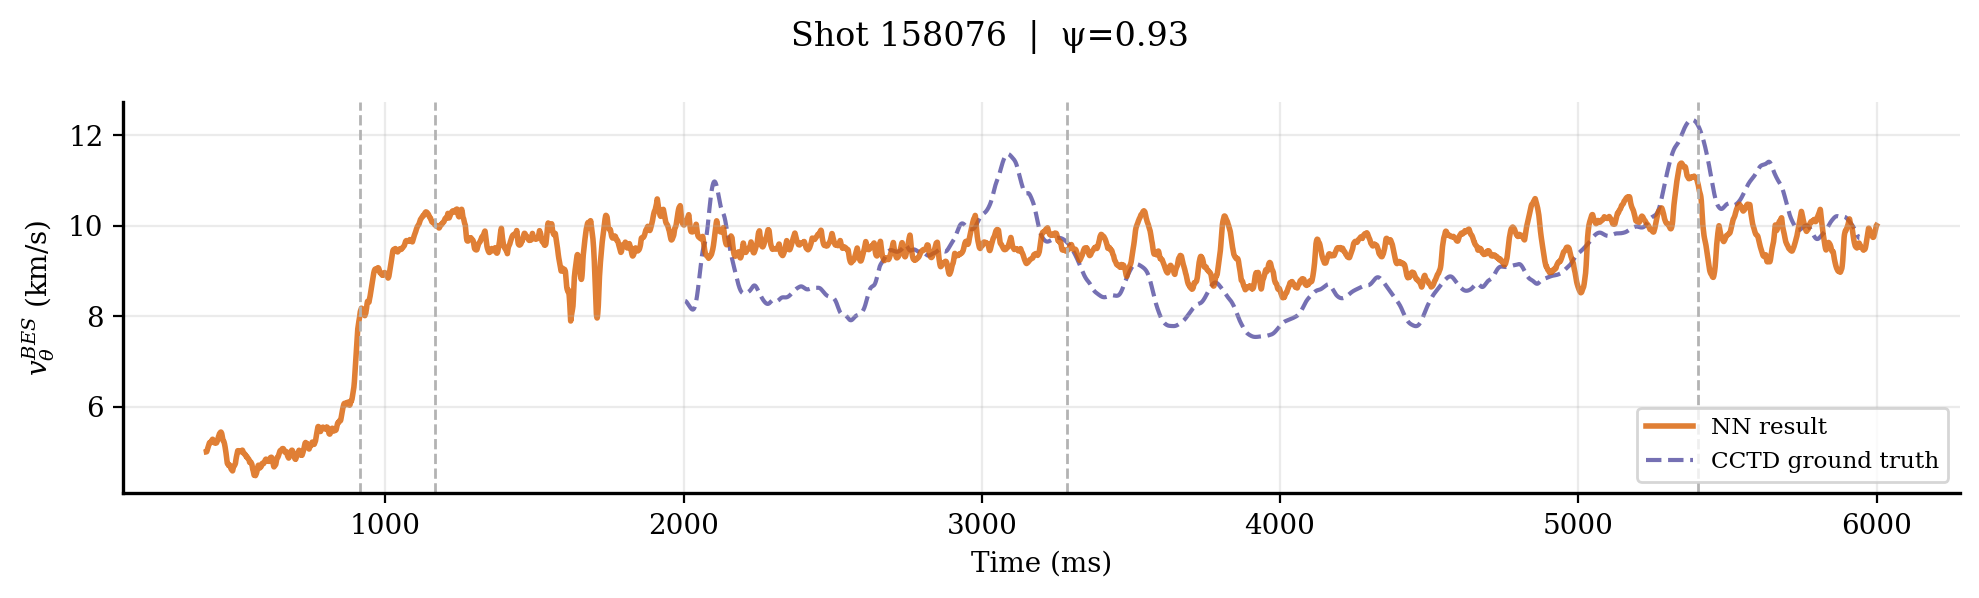

(89583,)


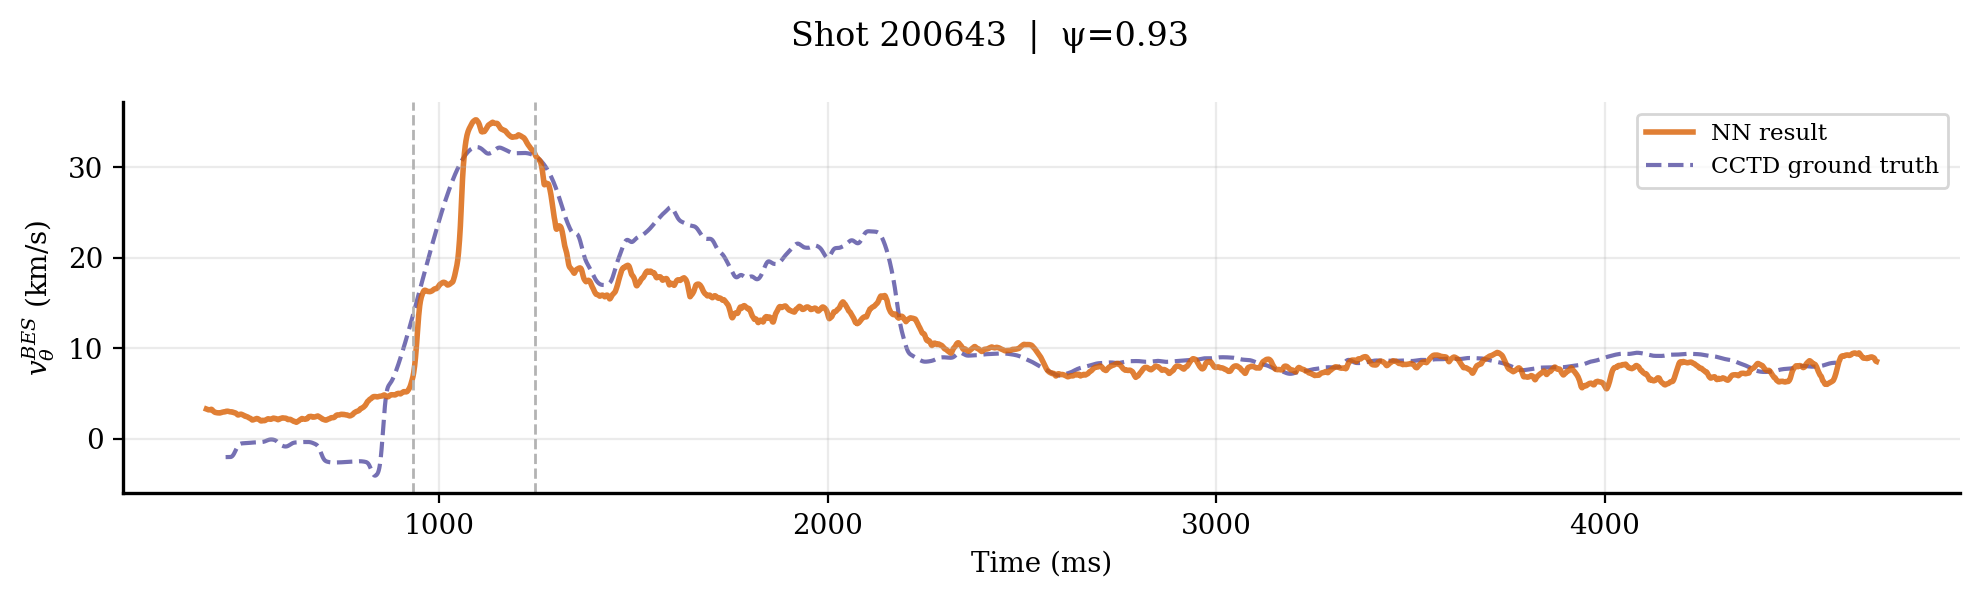

(46145,)


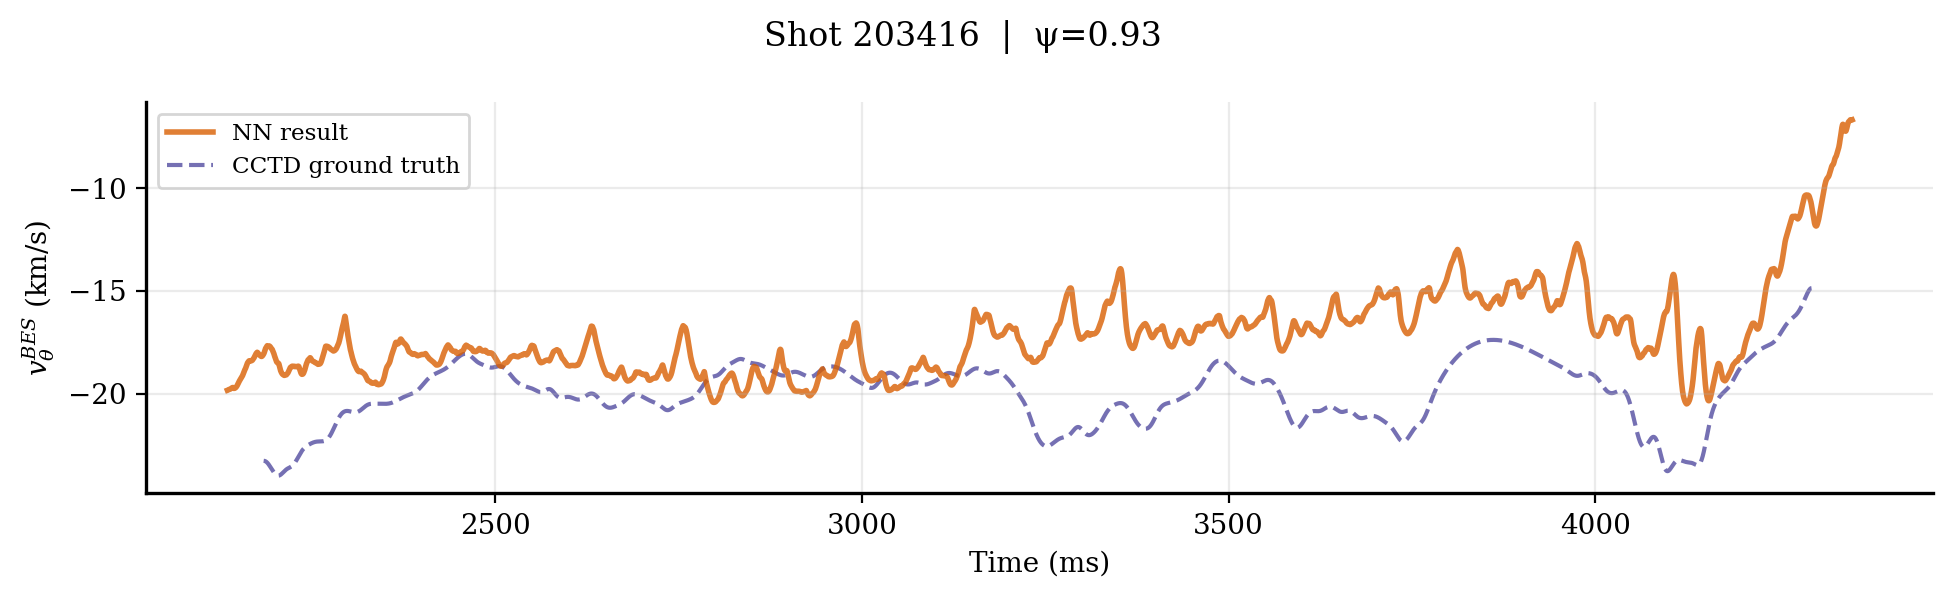

(46999,)


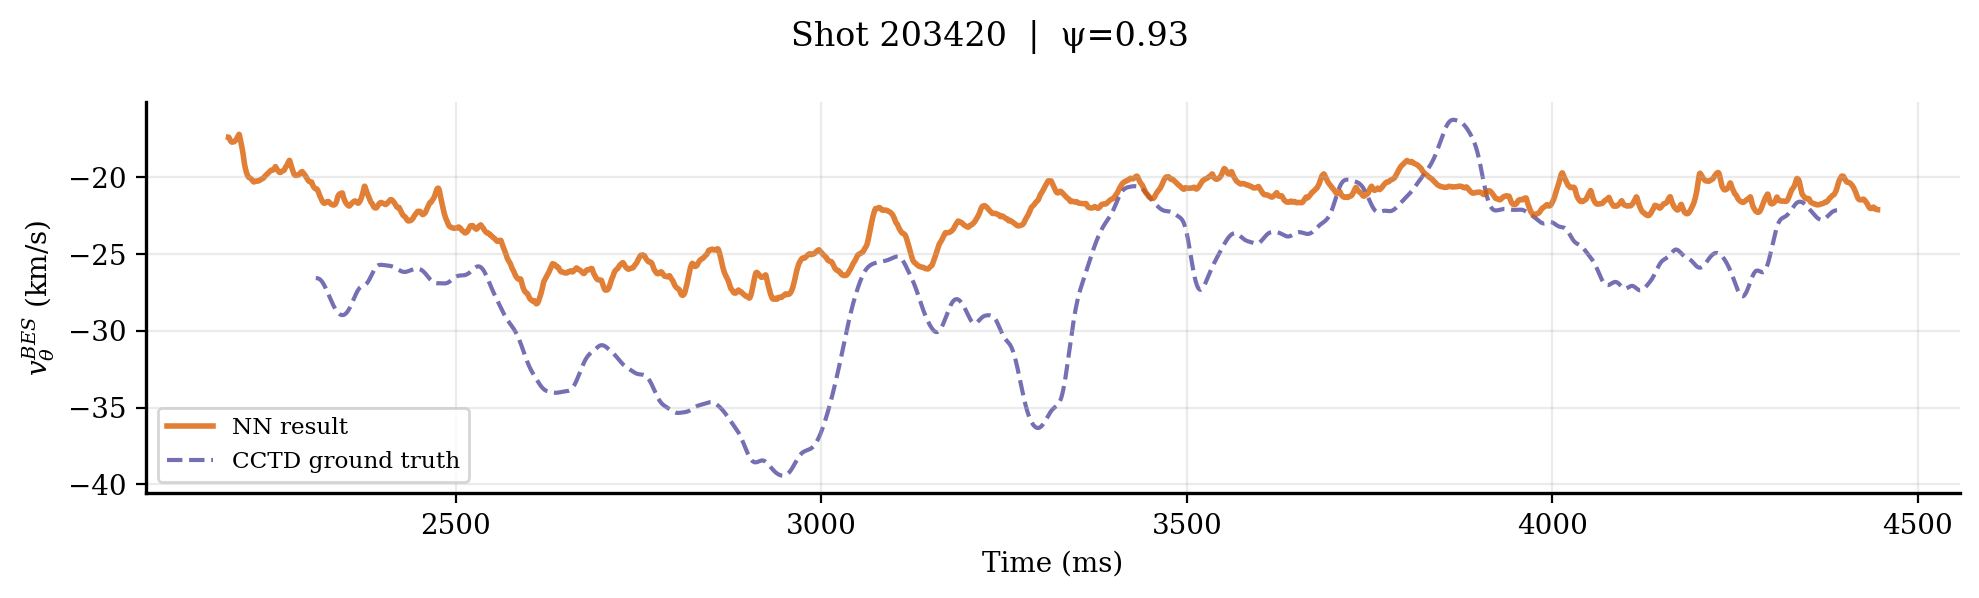

(90312,)


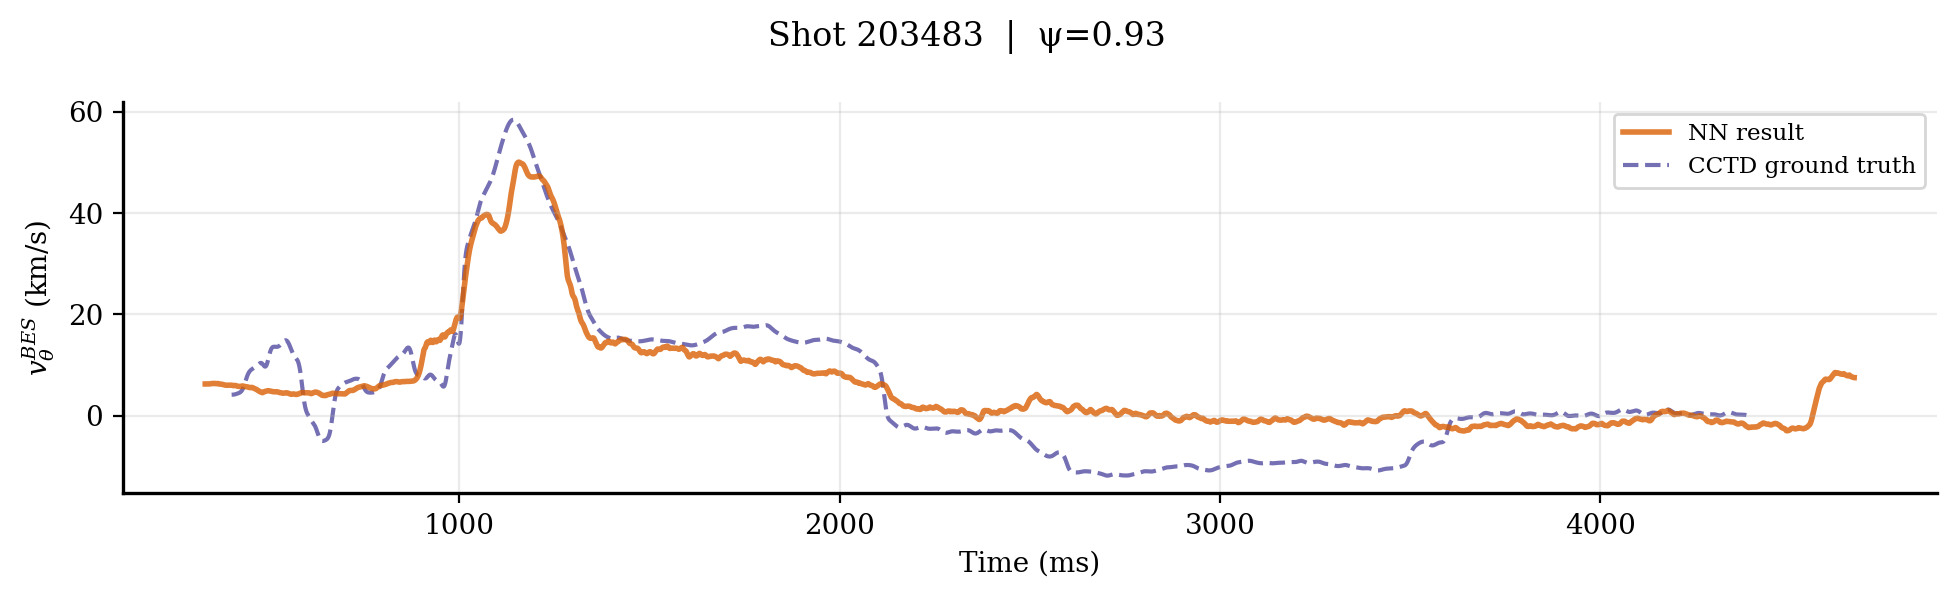

(84368,)


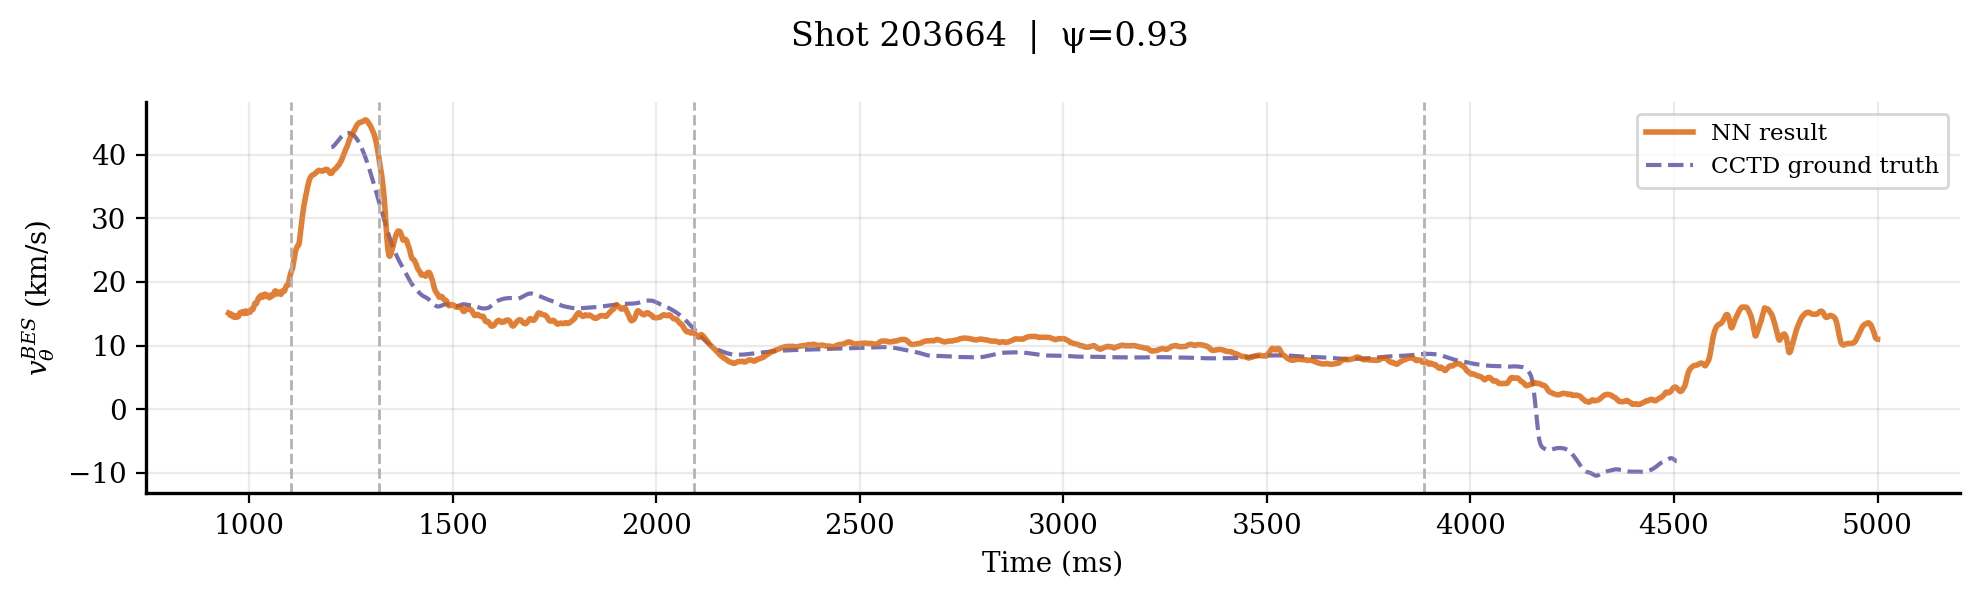

(84372,)


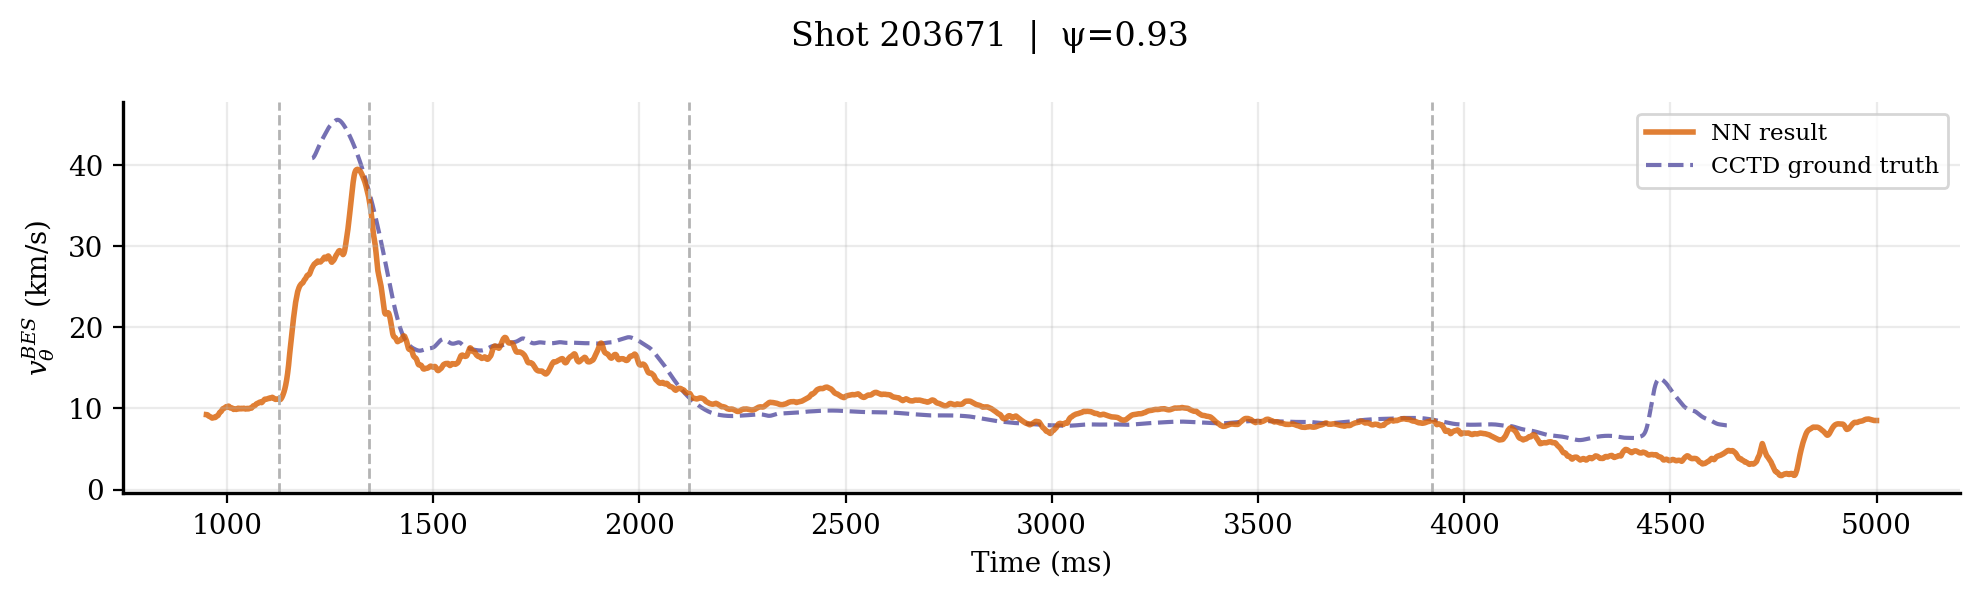

(76268,)


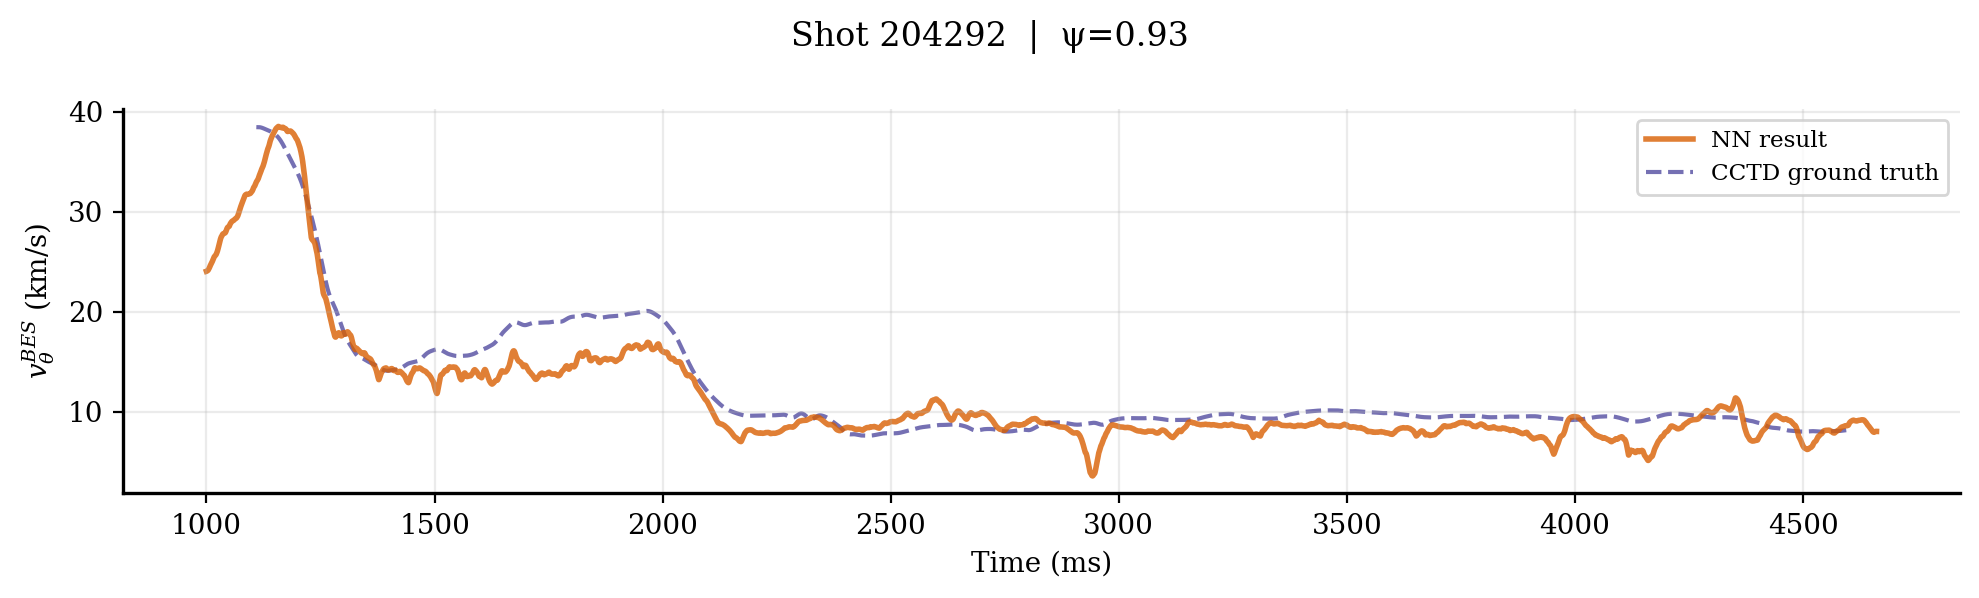

(72687,)


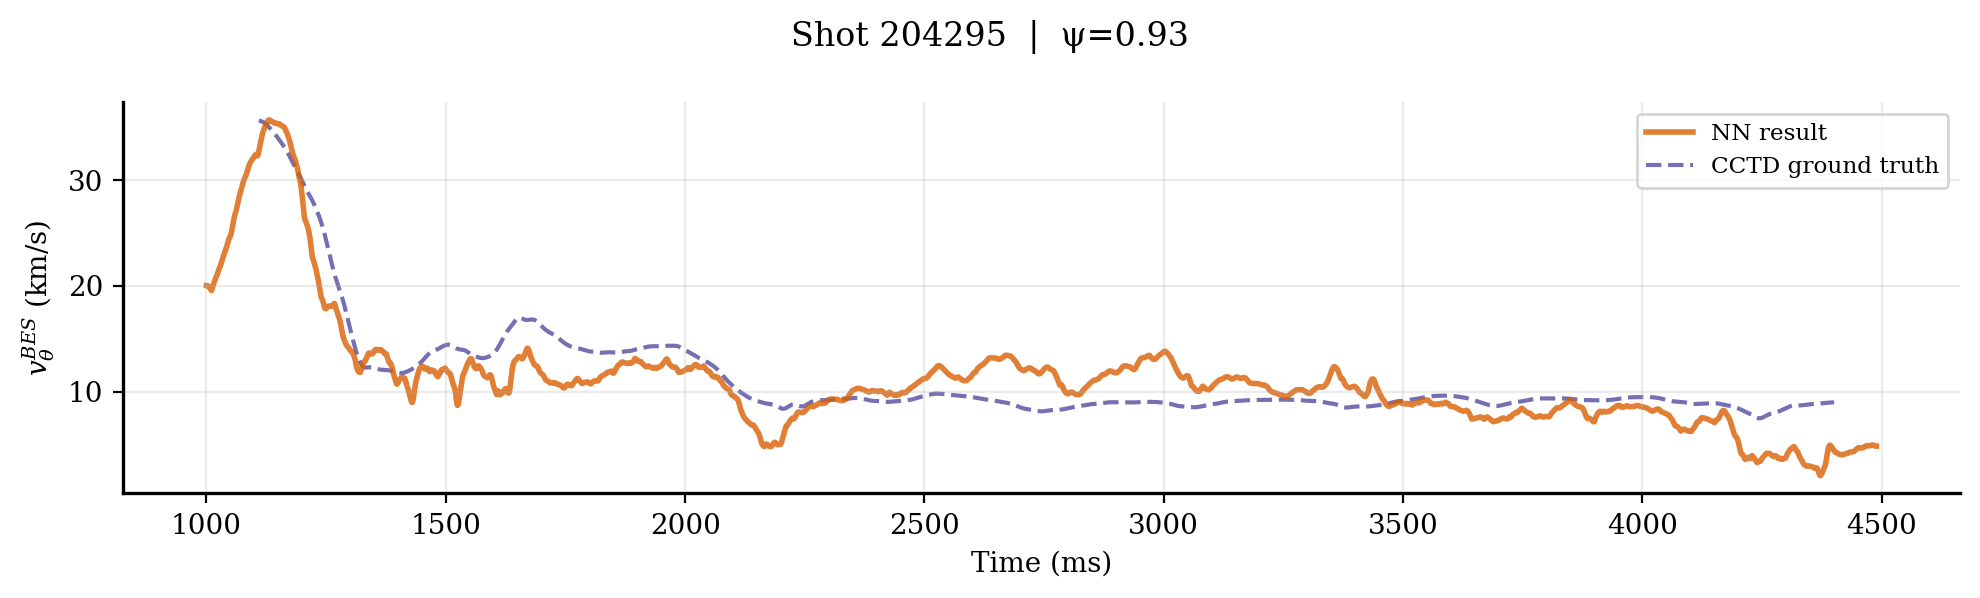

(75057,)


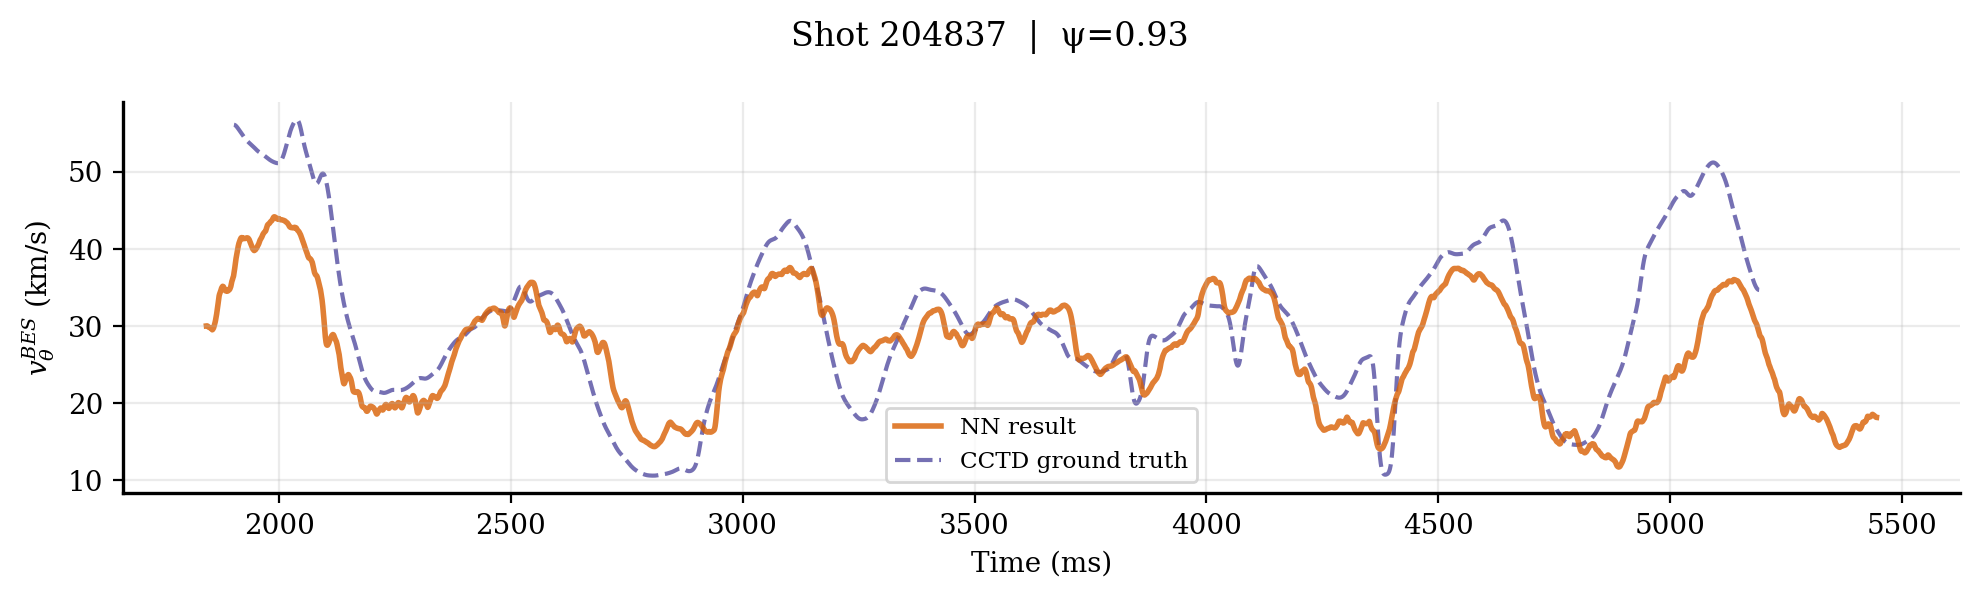

(91456,)


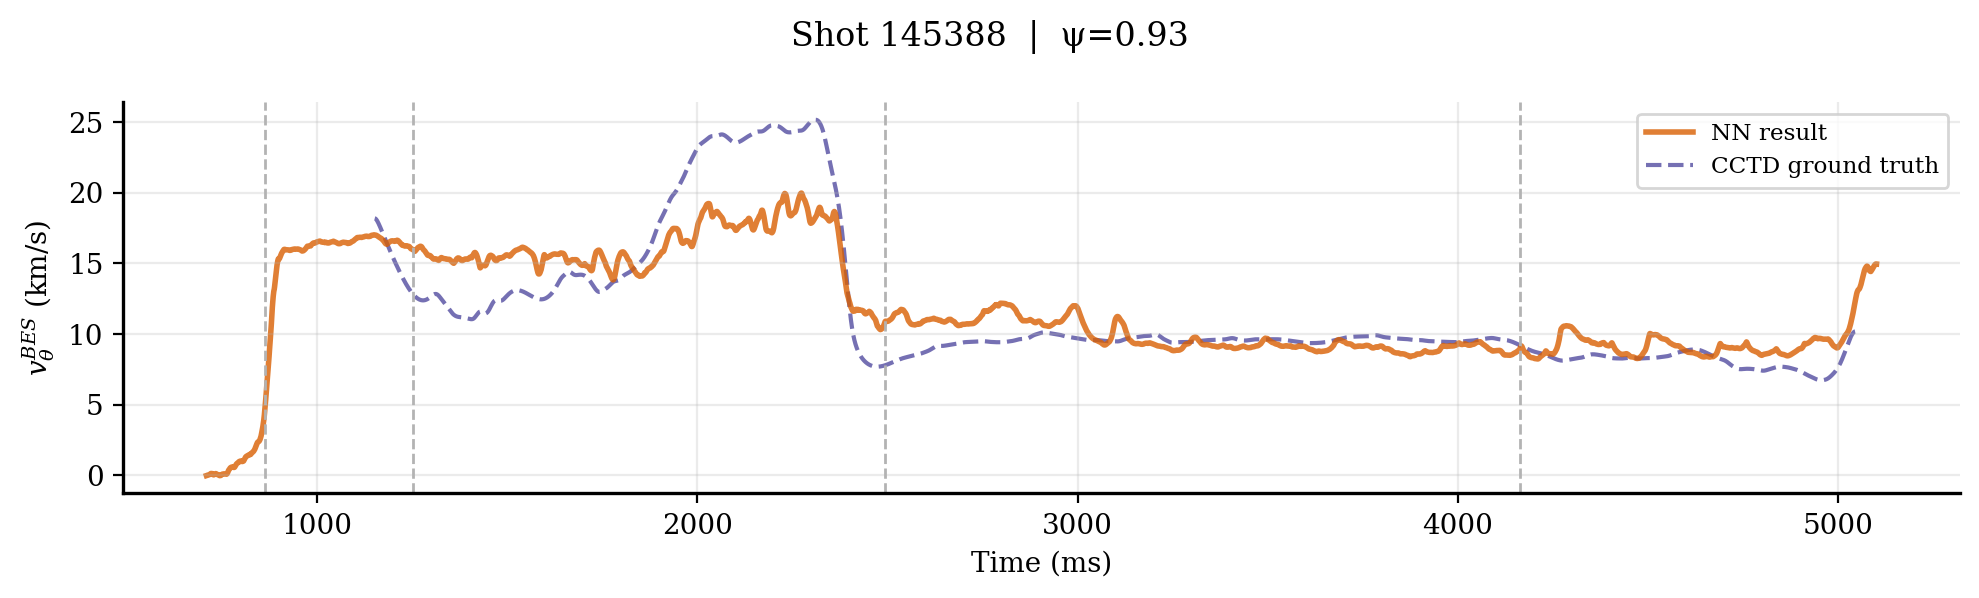

(89576,)


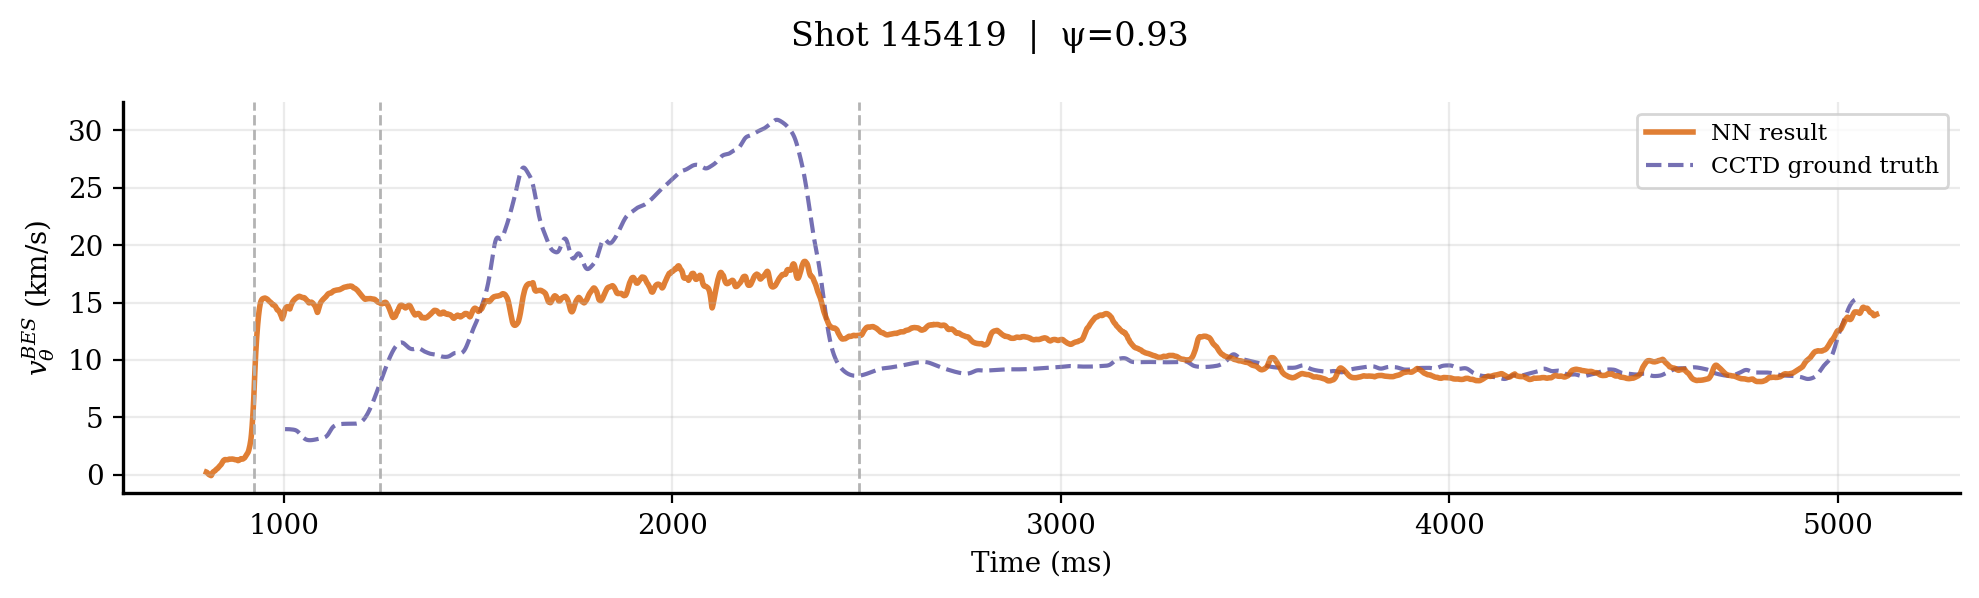

(85416,)


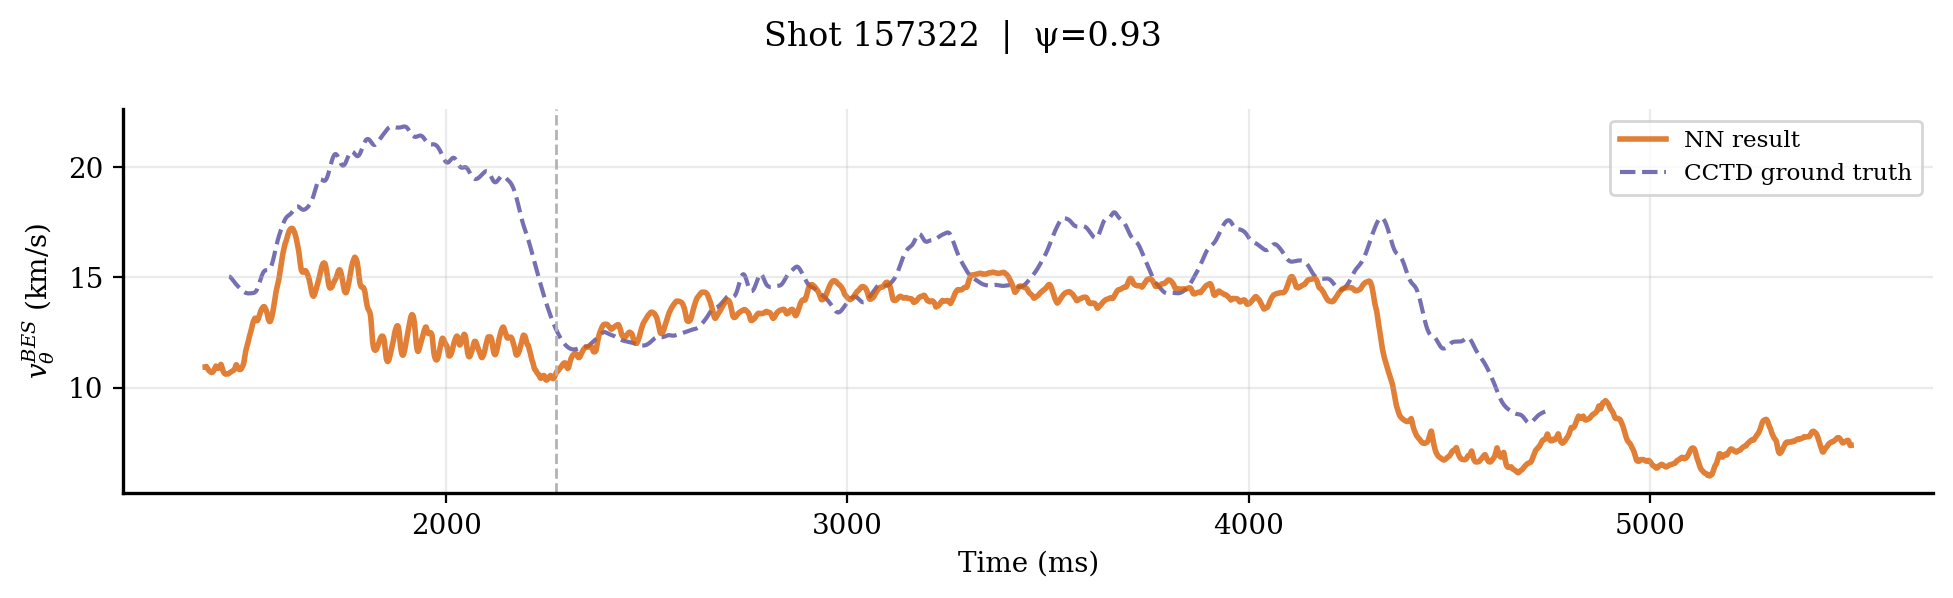

(112496,)


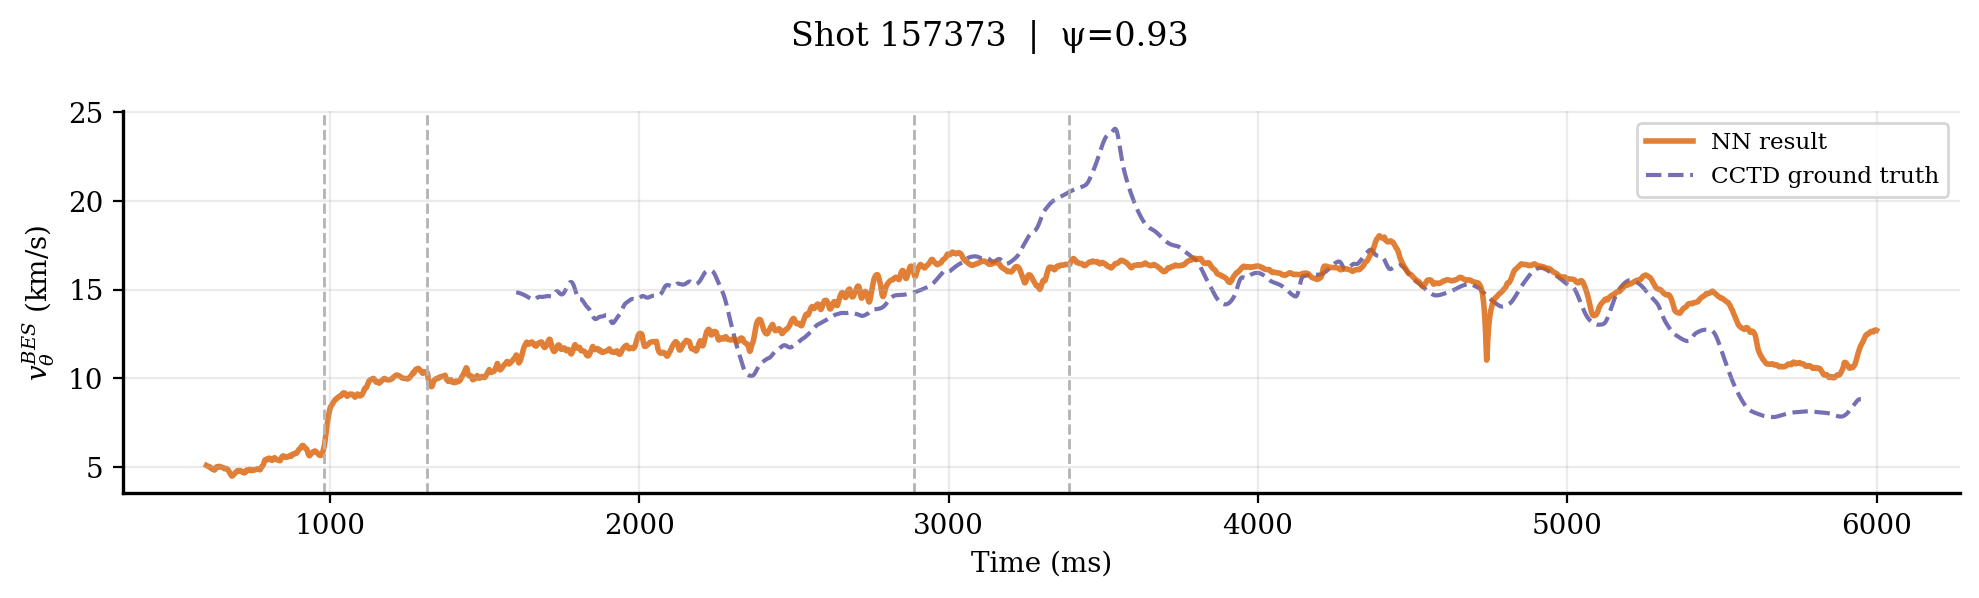

(112498,)


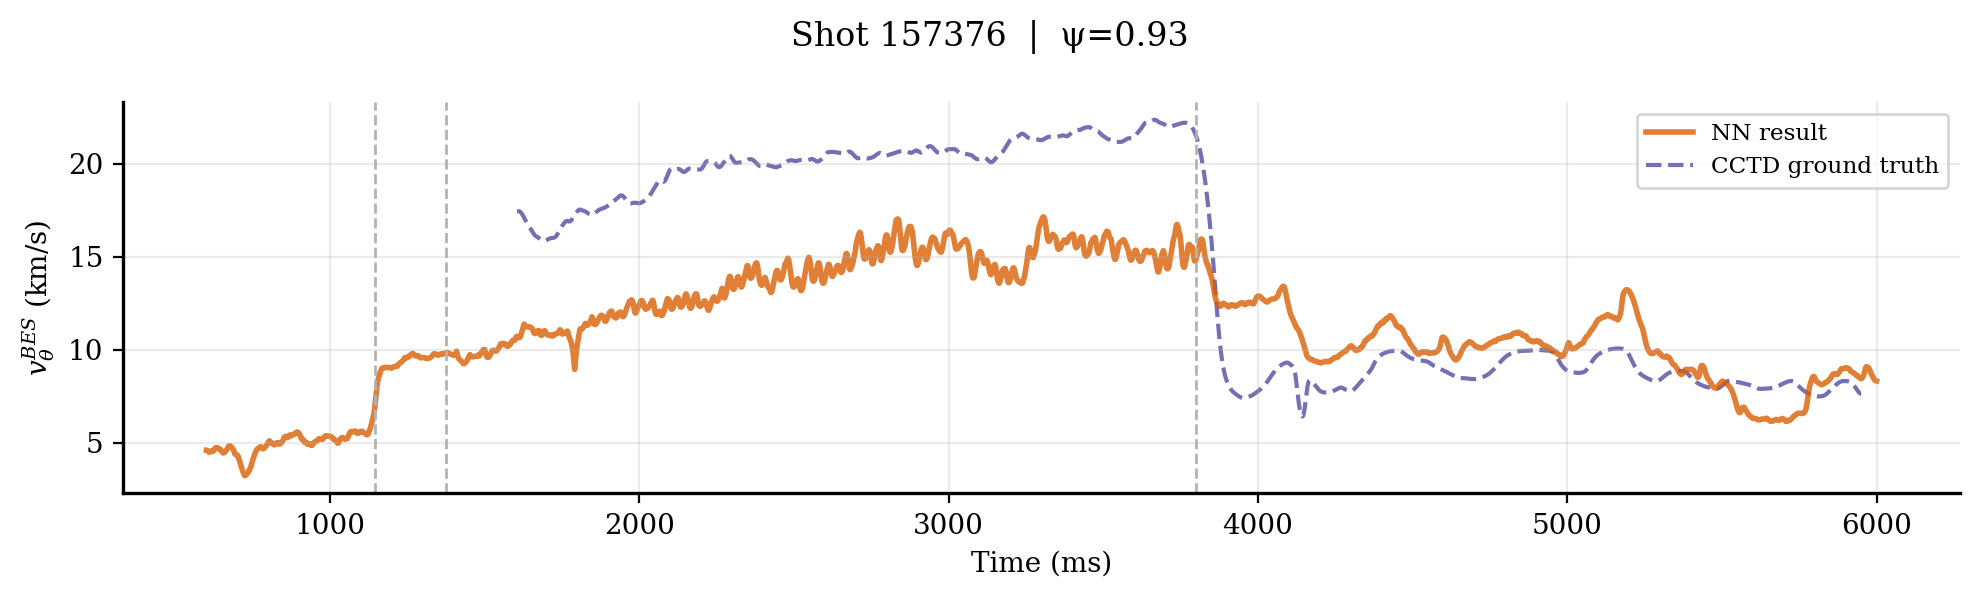

(38622,)


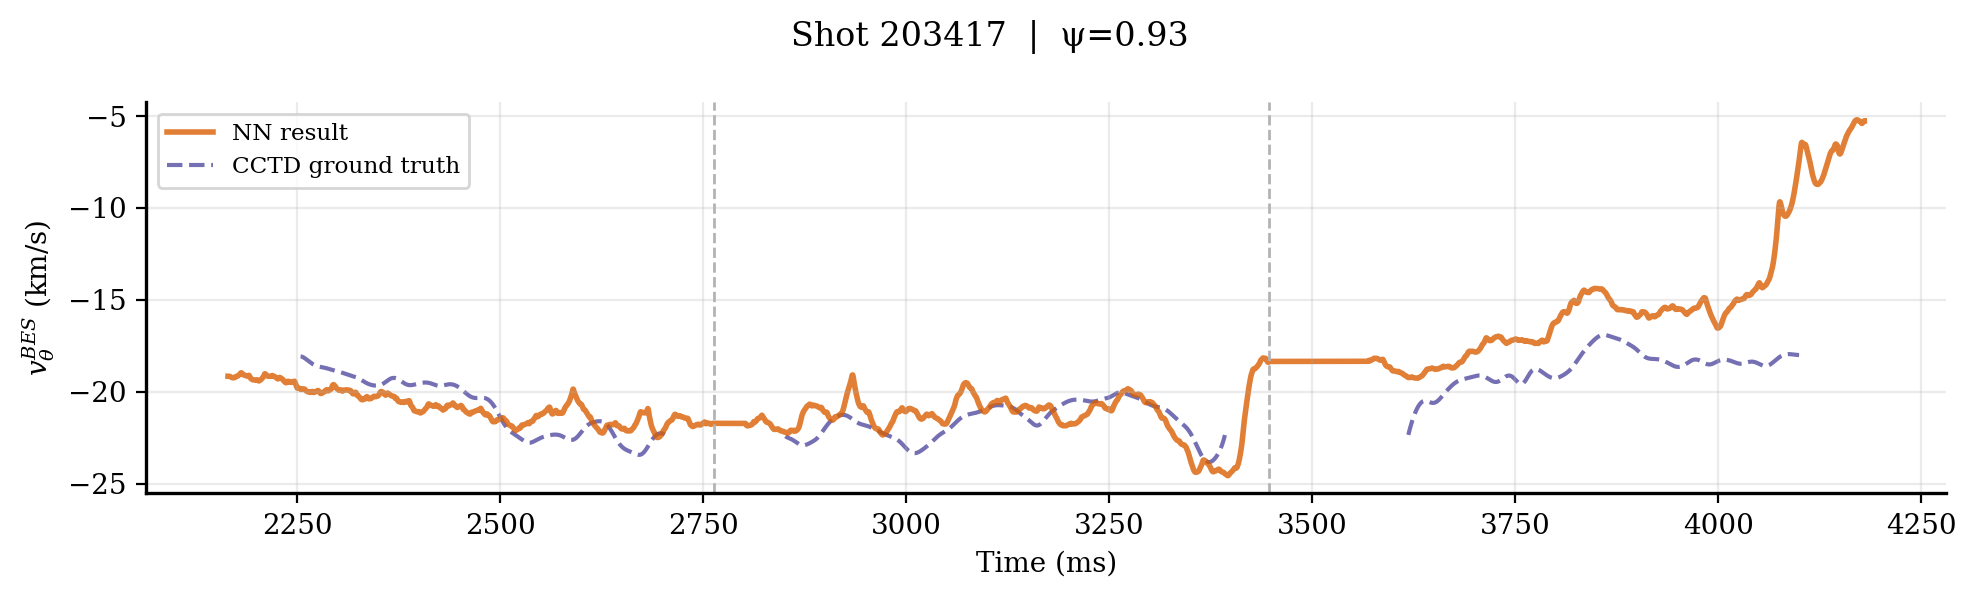

(38520,)


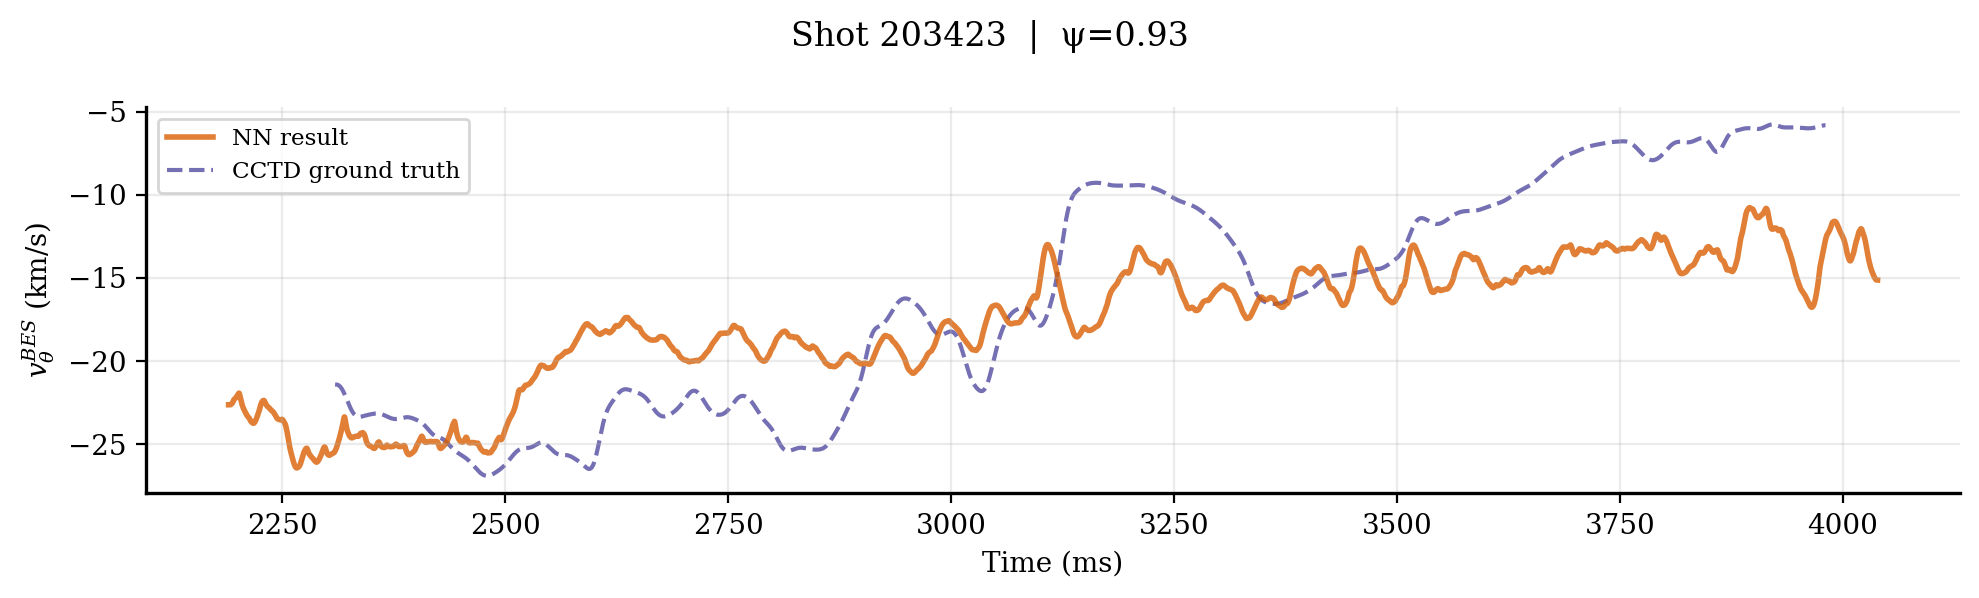

(82912,)


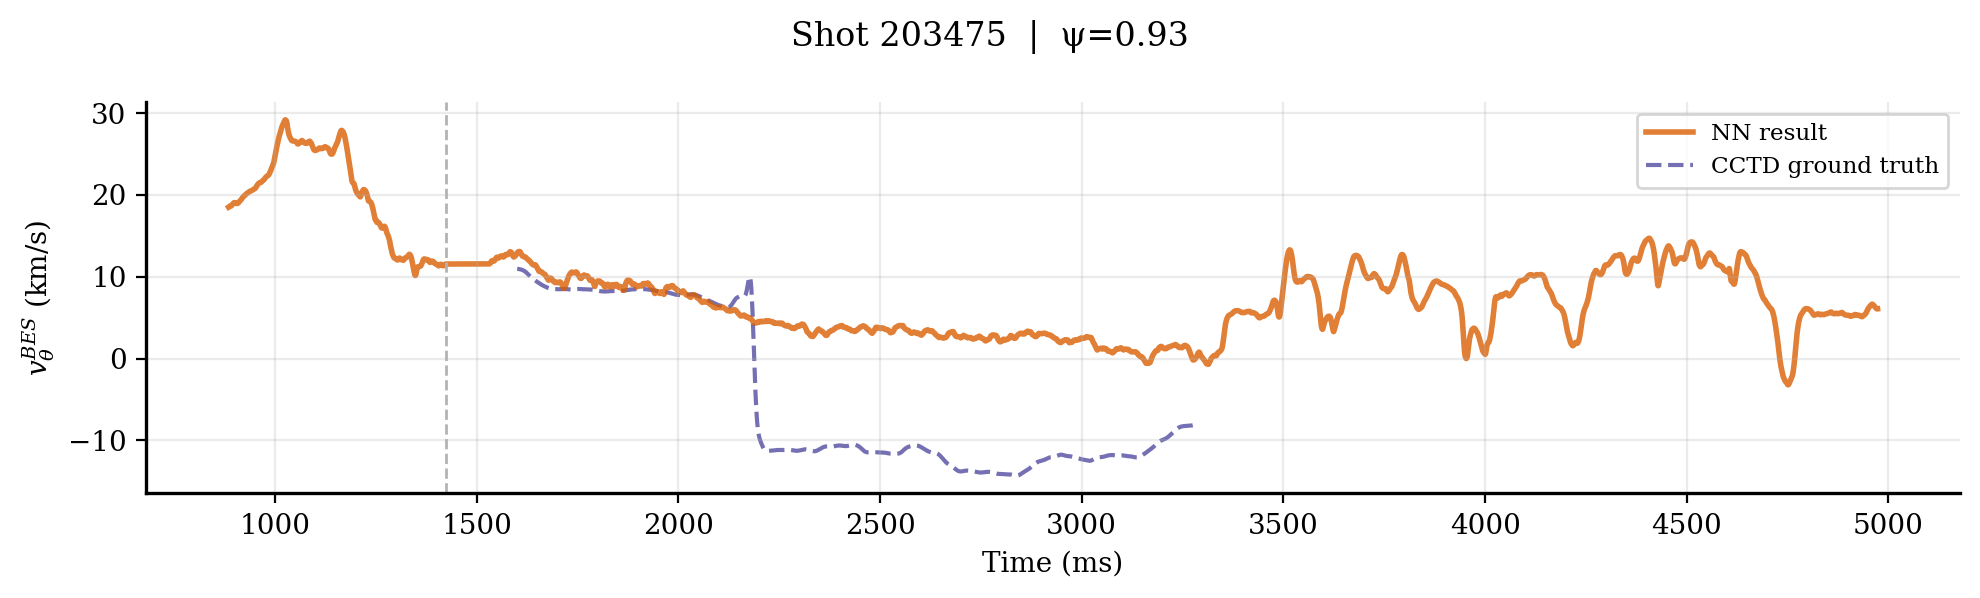

(89854,)


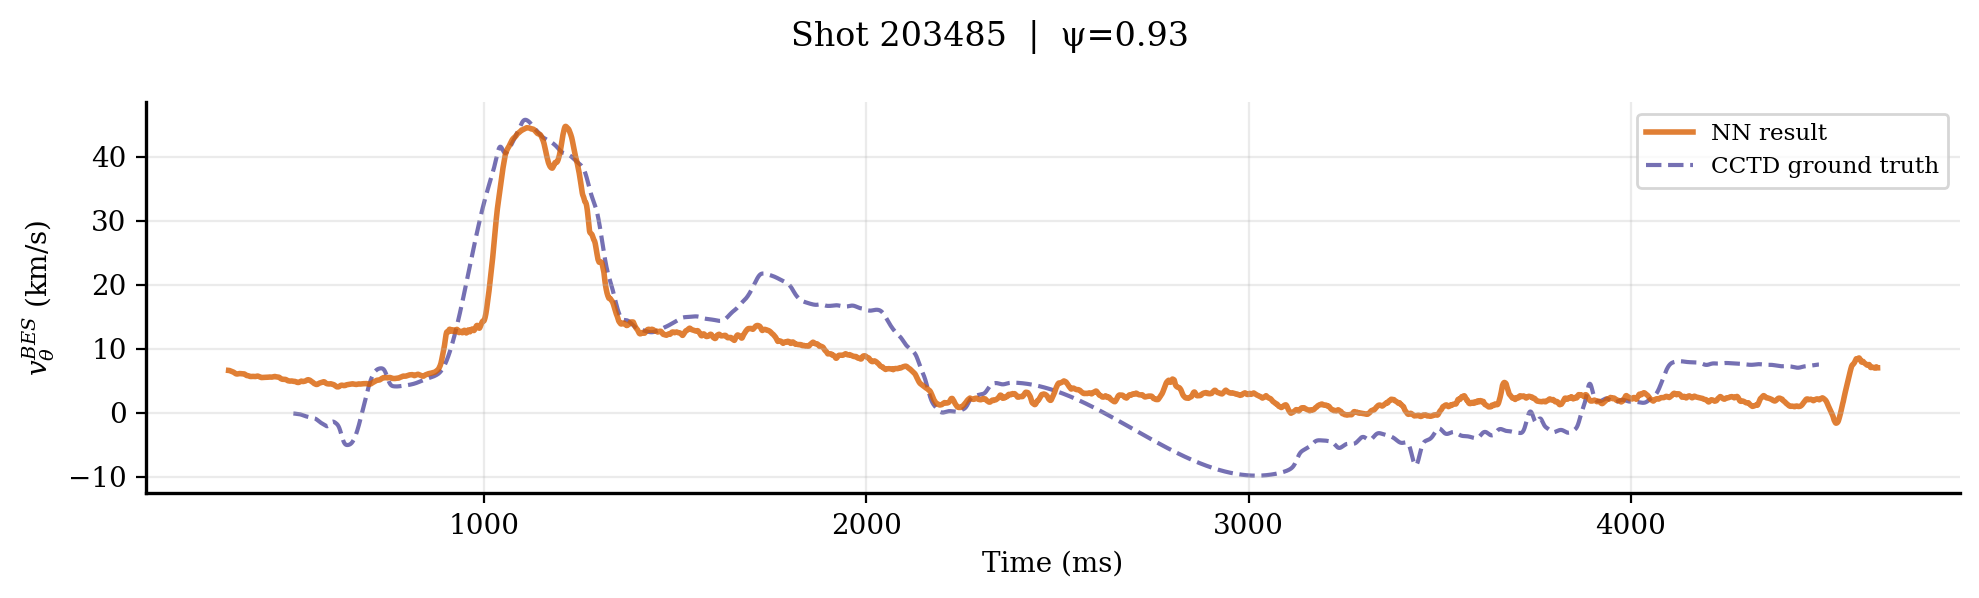

(84370,)


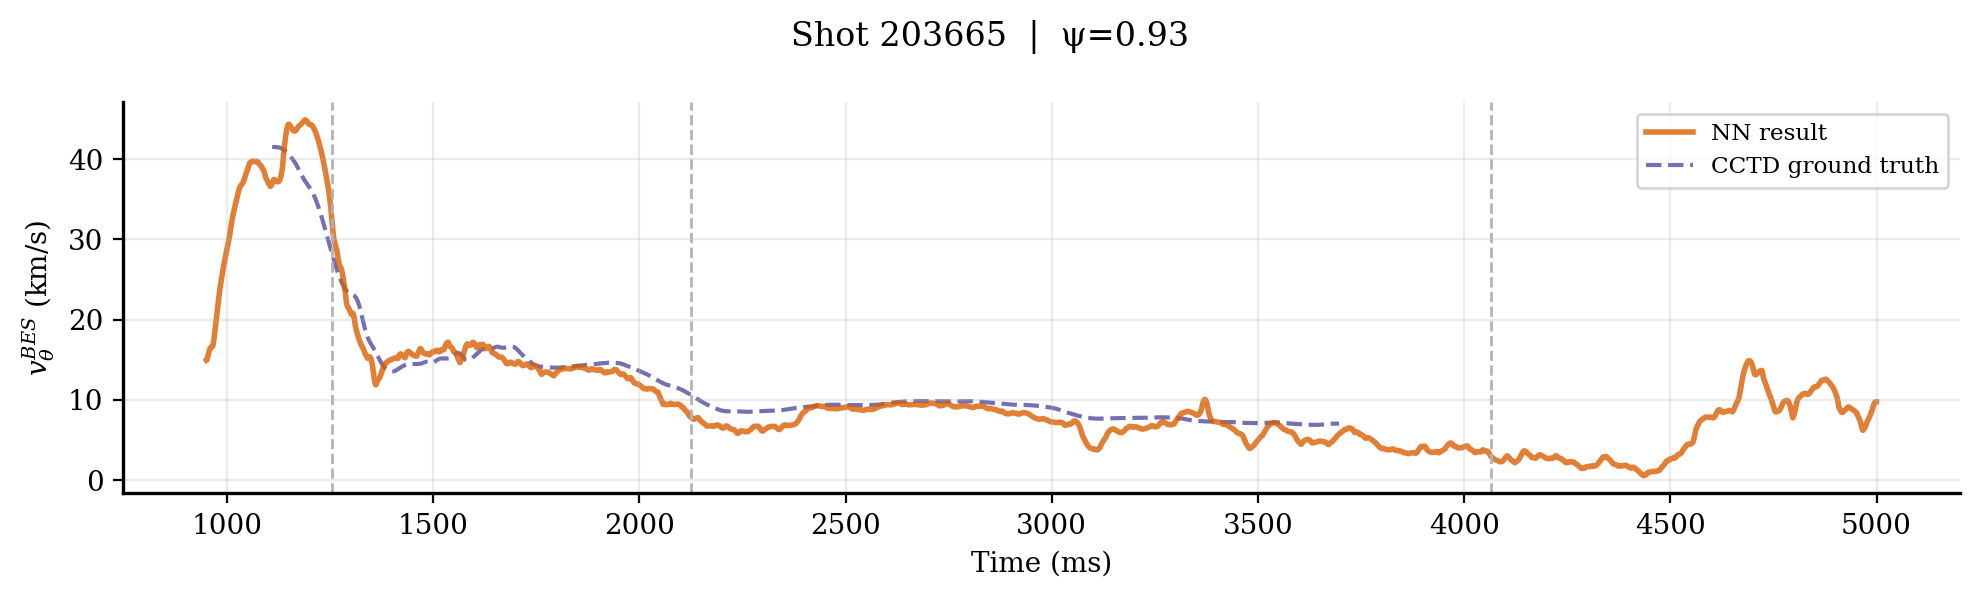

(84372,)


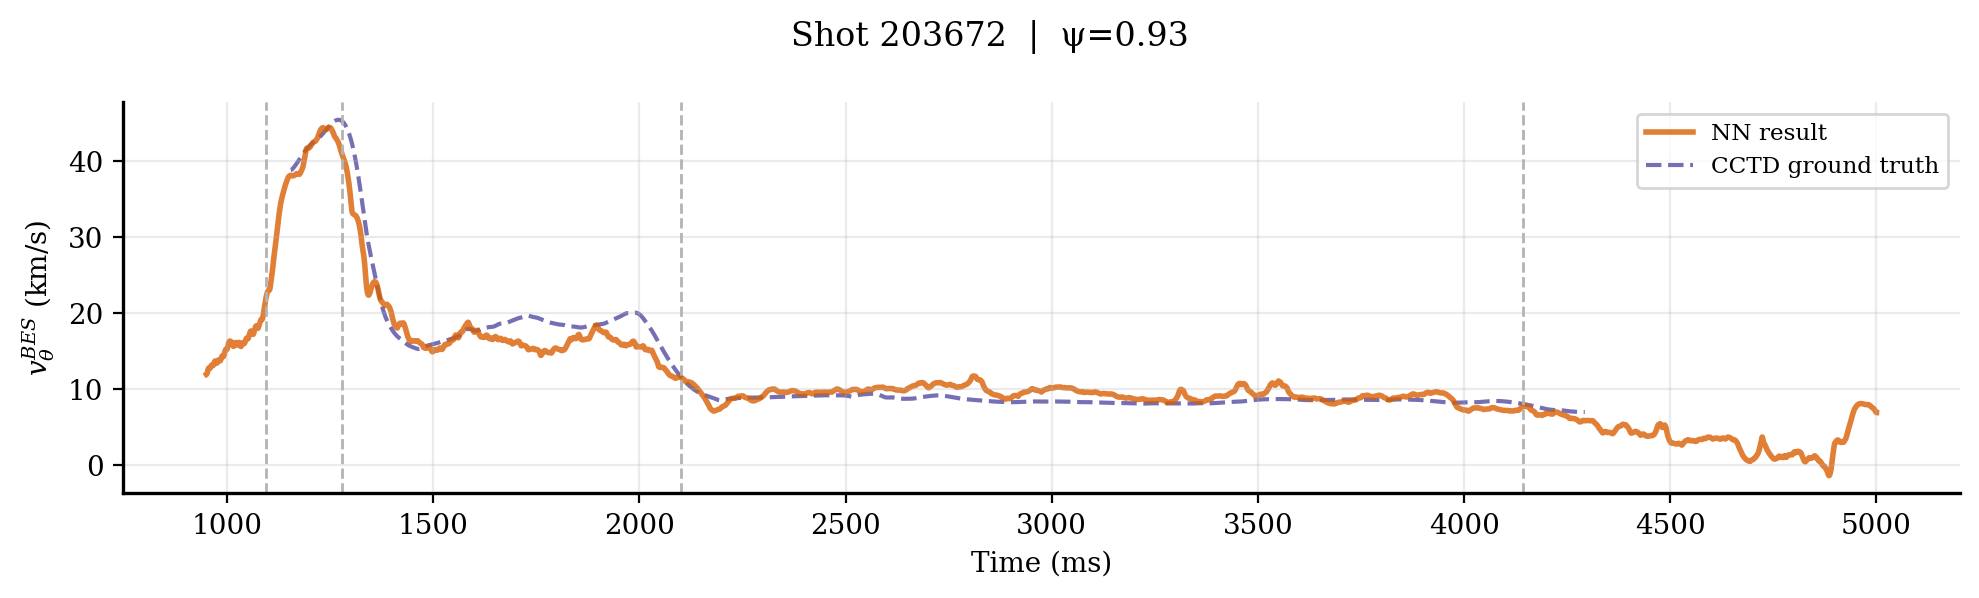

(76268,)


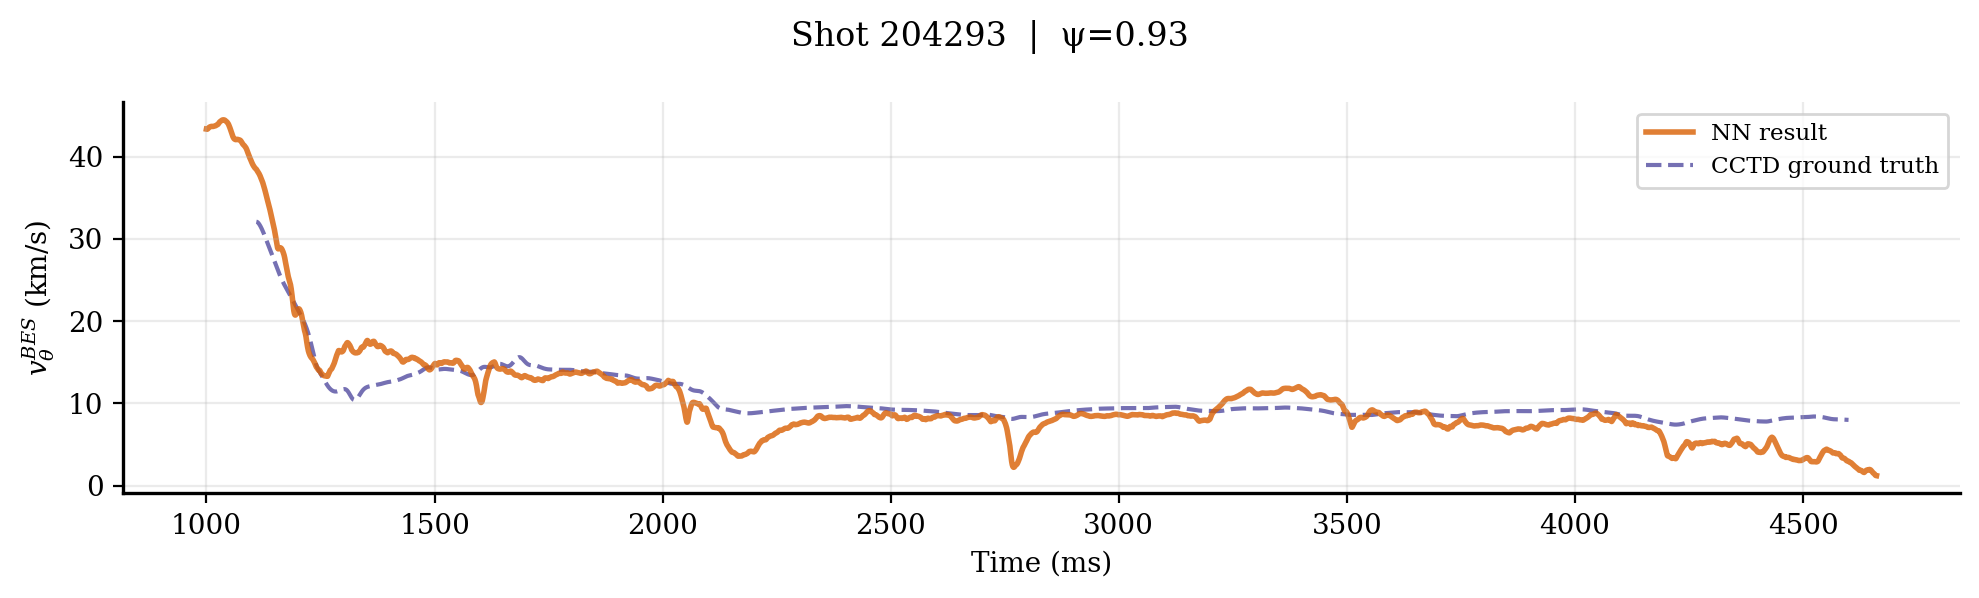

(92497,)


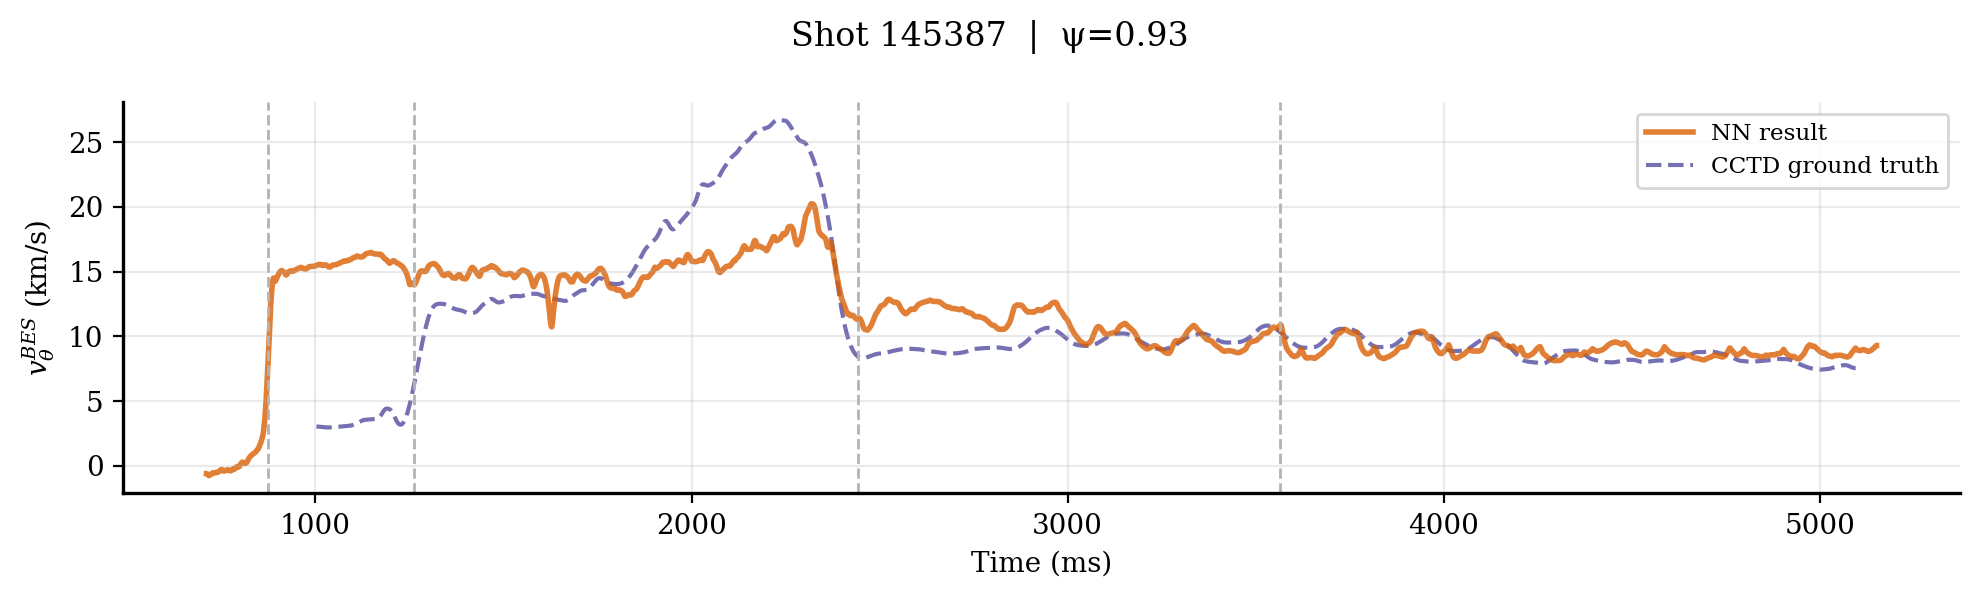

(83119,)


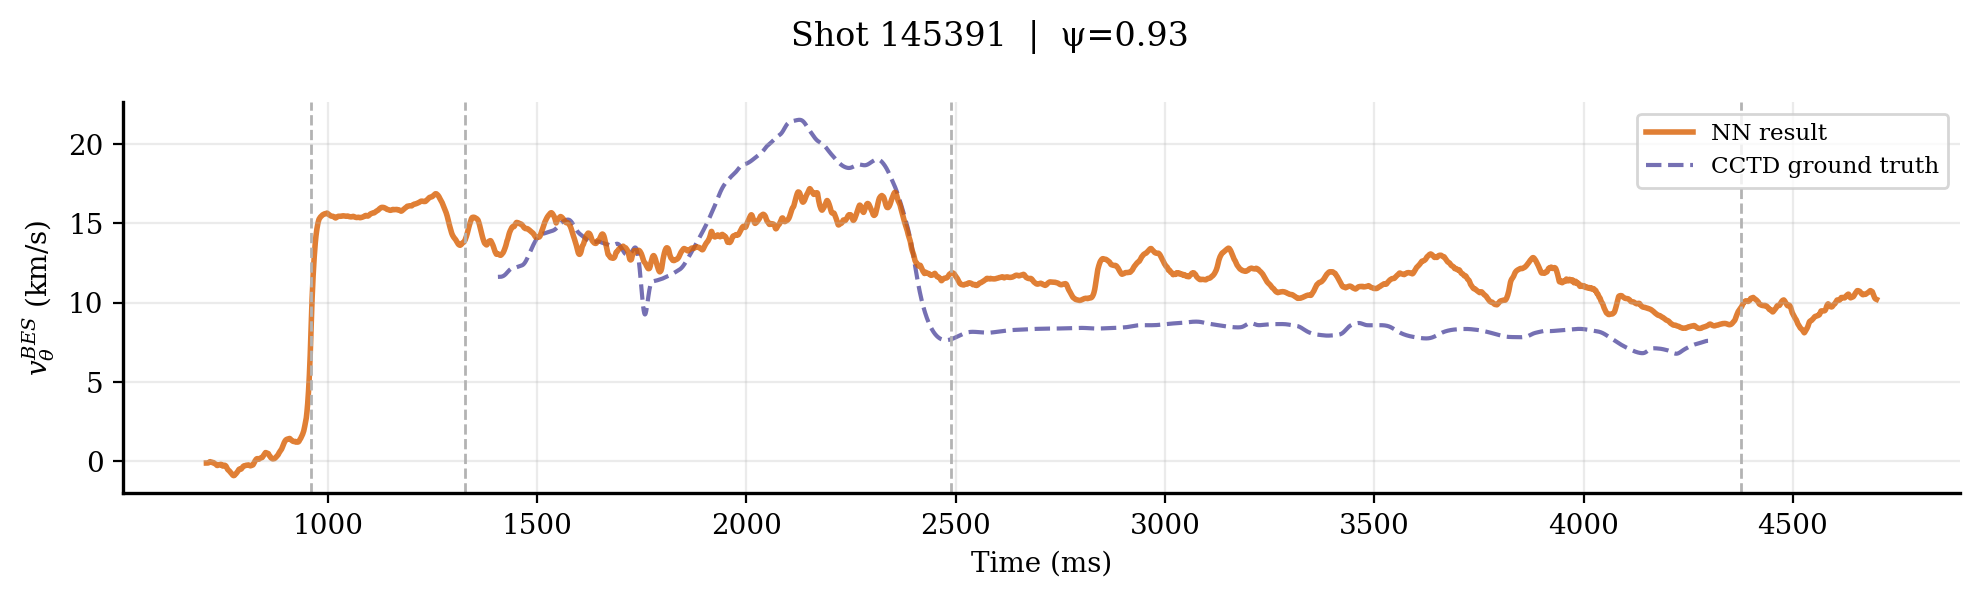

(56248,)


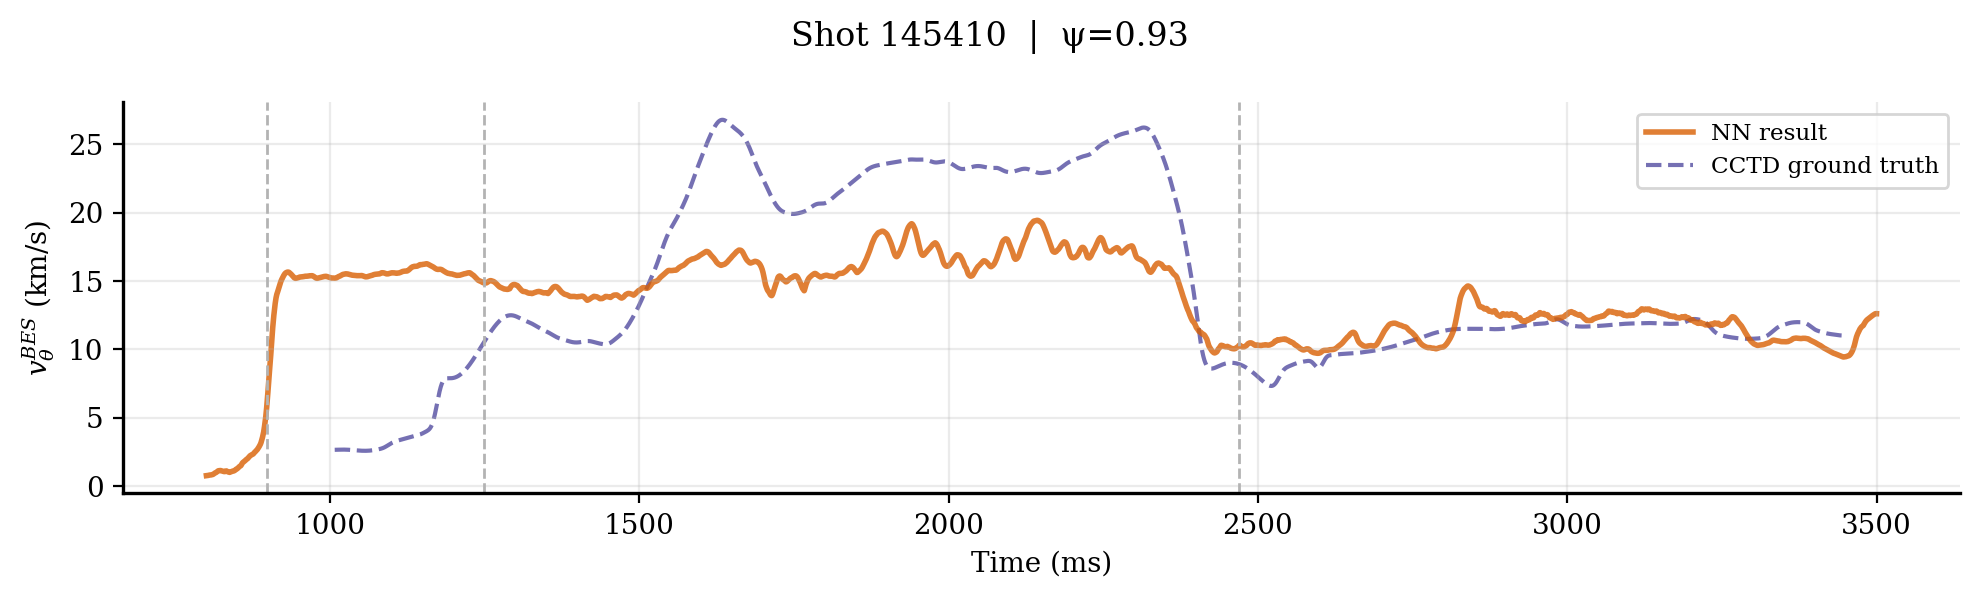

(93536,)


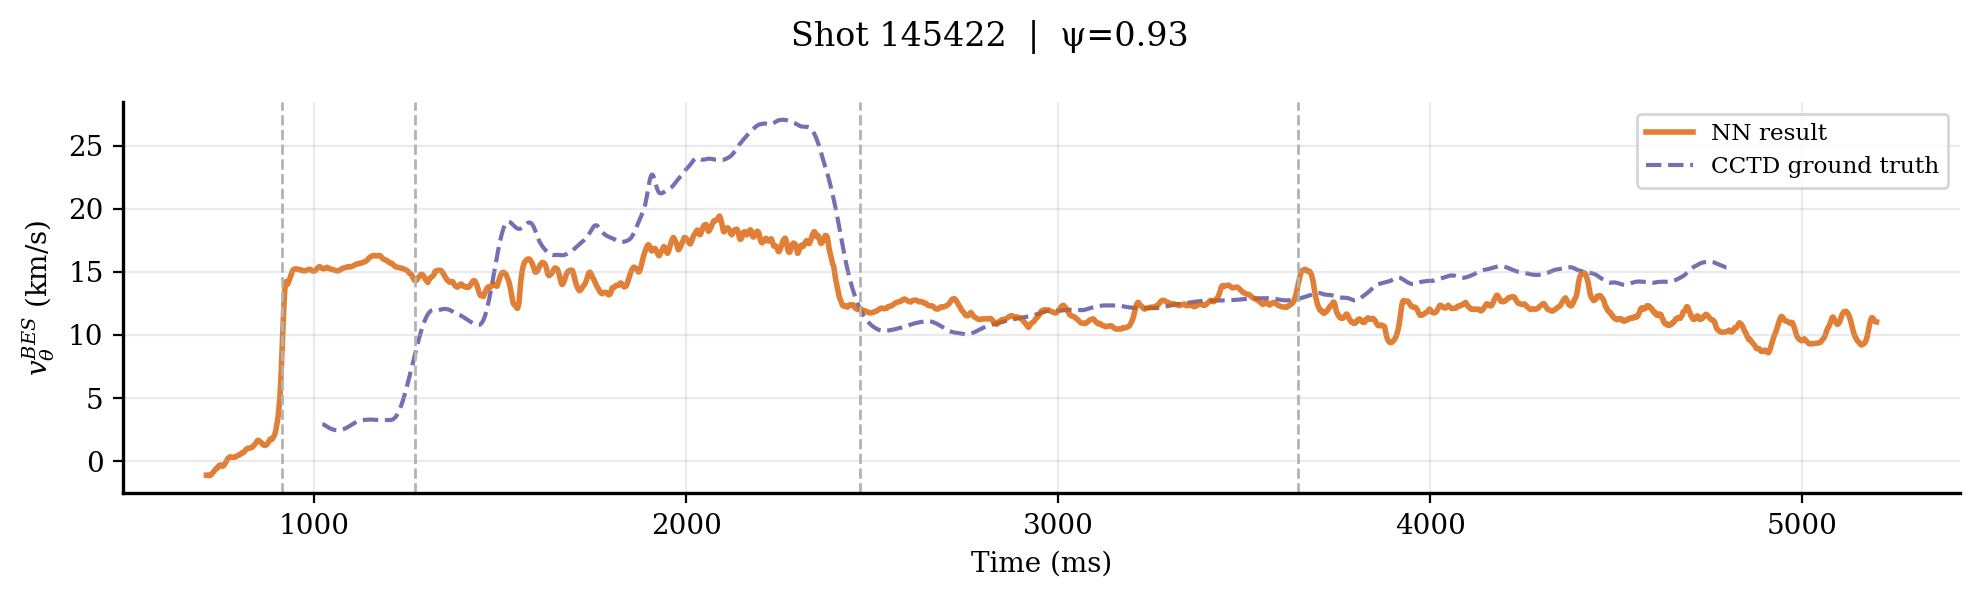

(91665,)


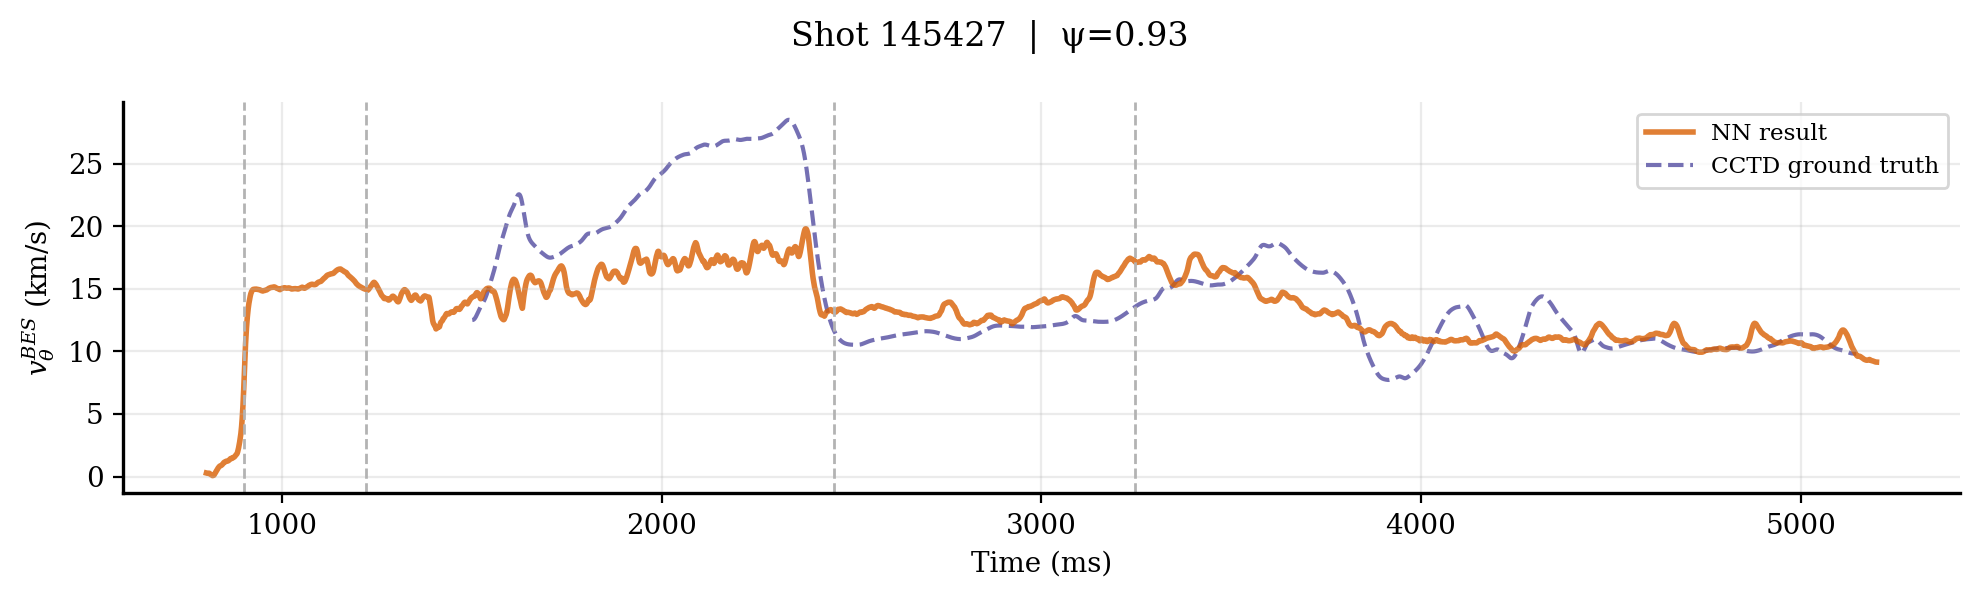

(95663,)


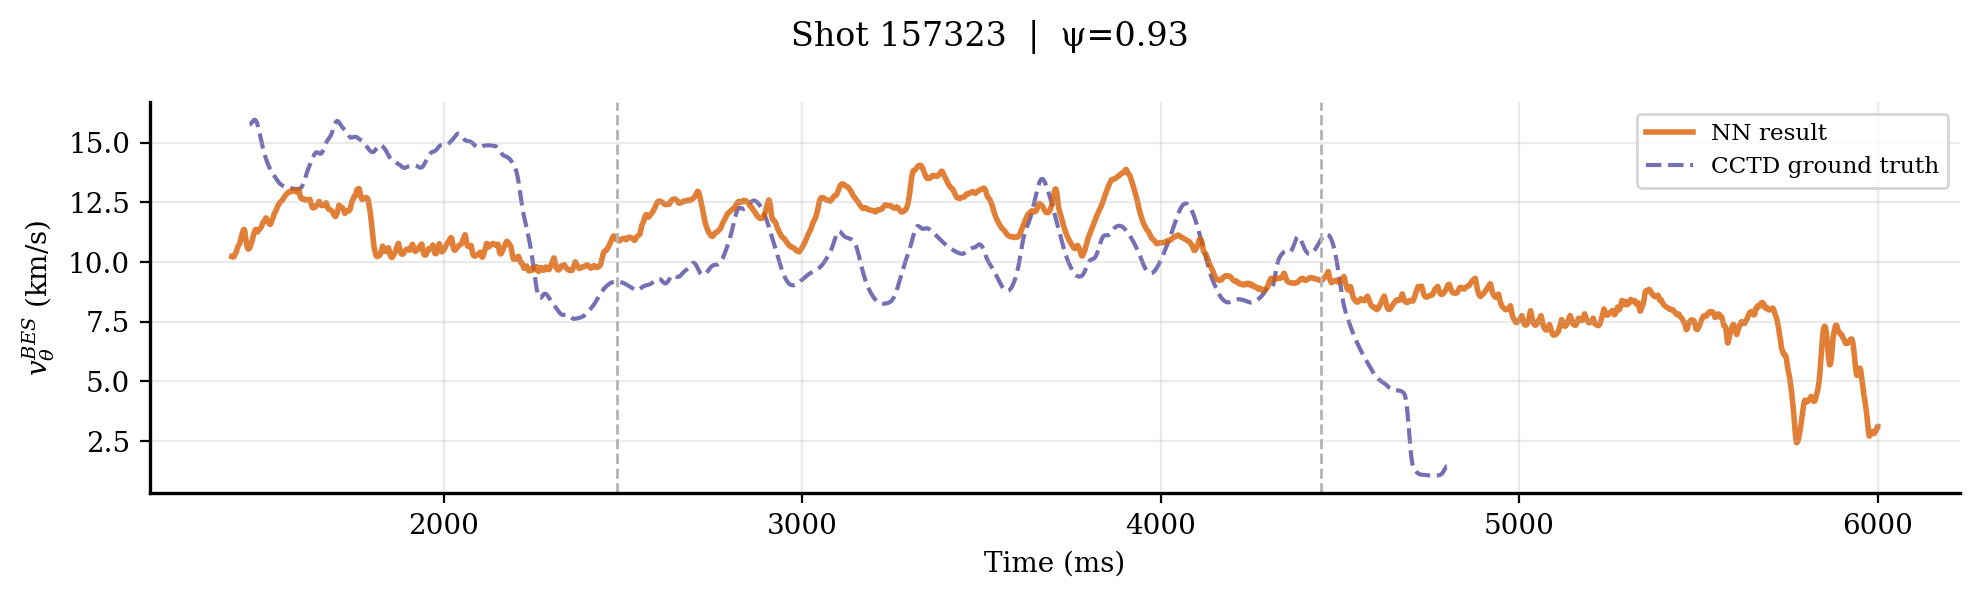

(112498,)


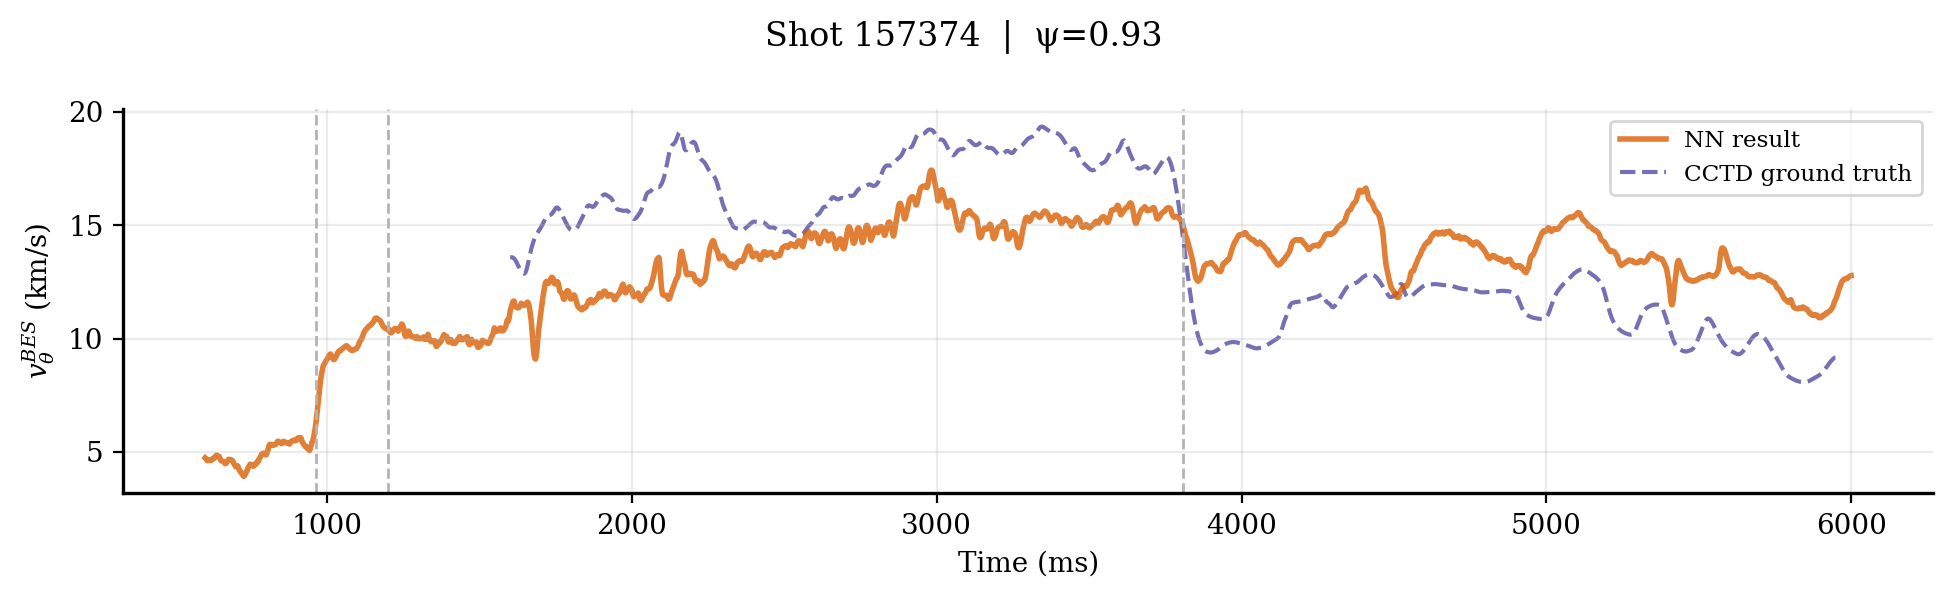

(112350,)


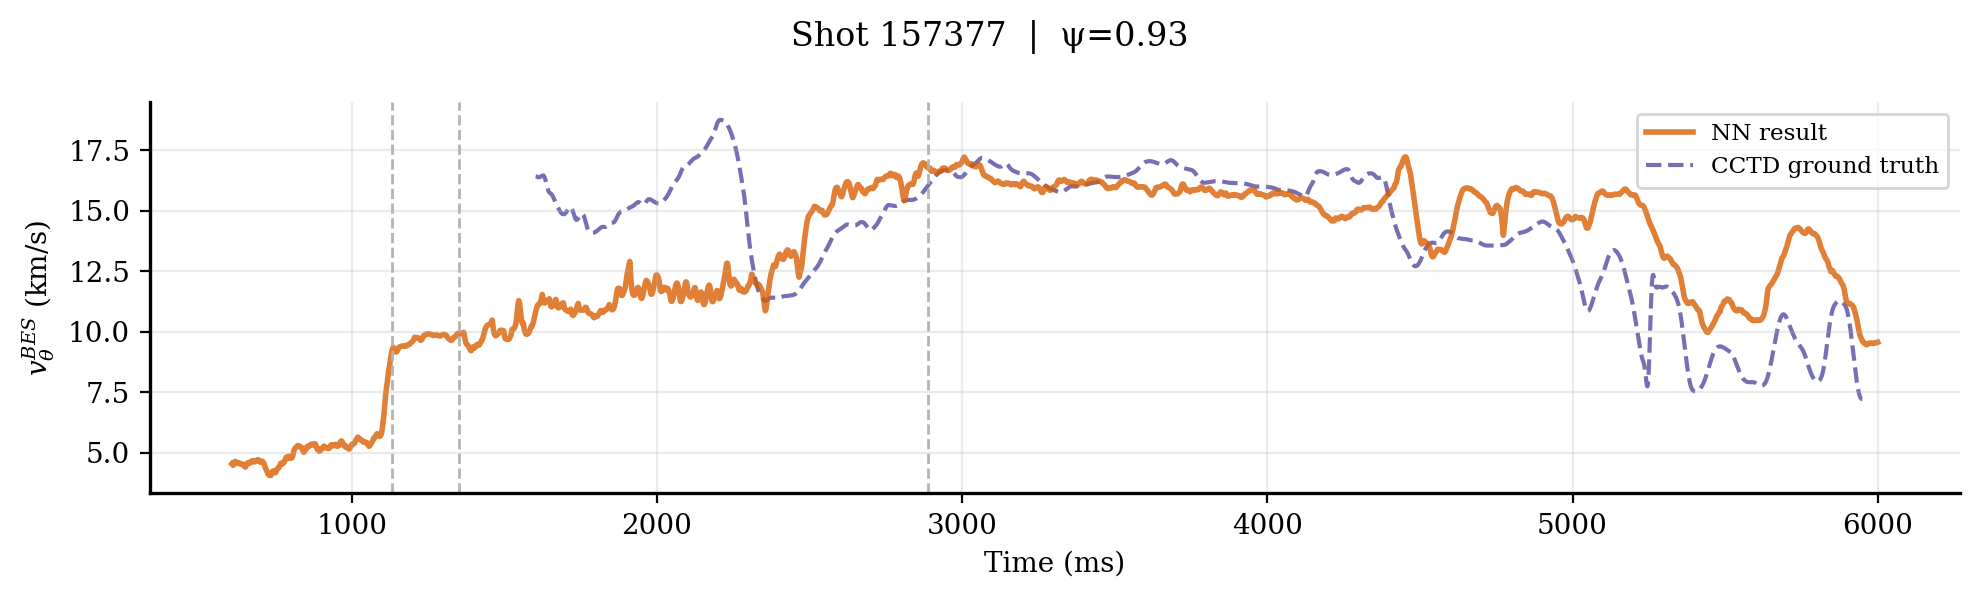

(116665,)


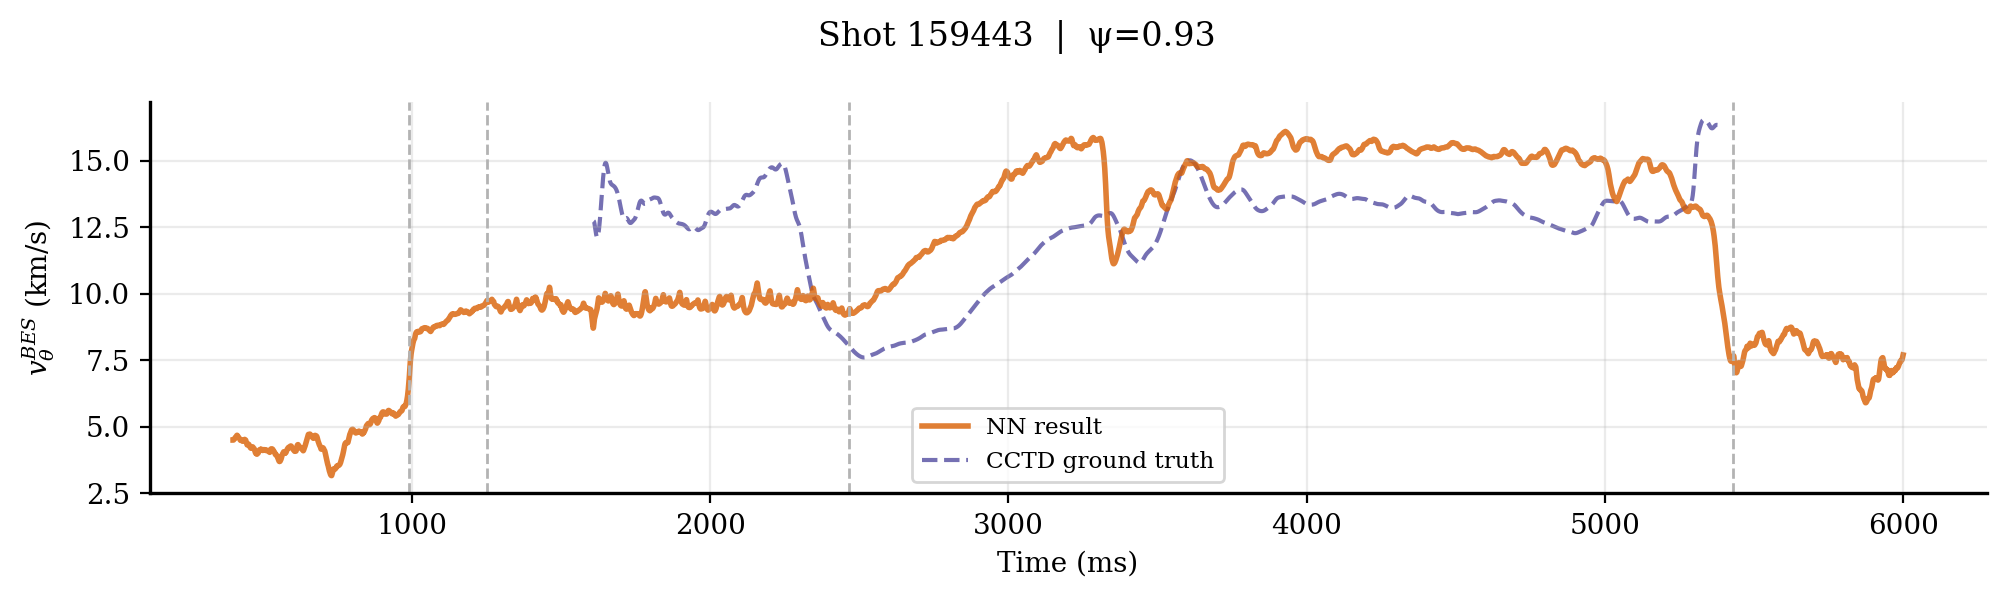

(84615,)


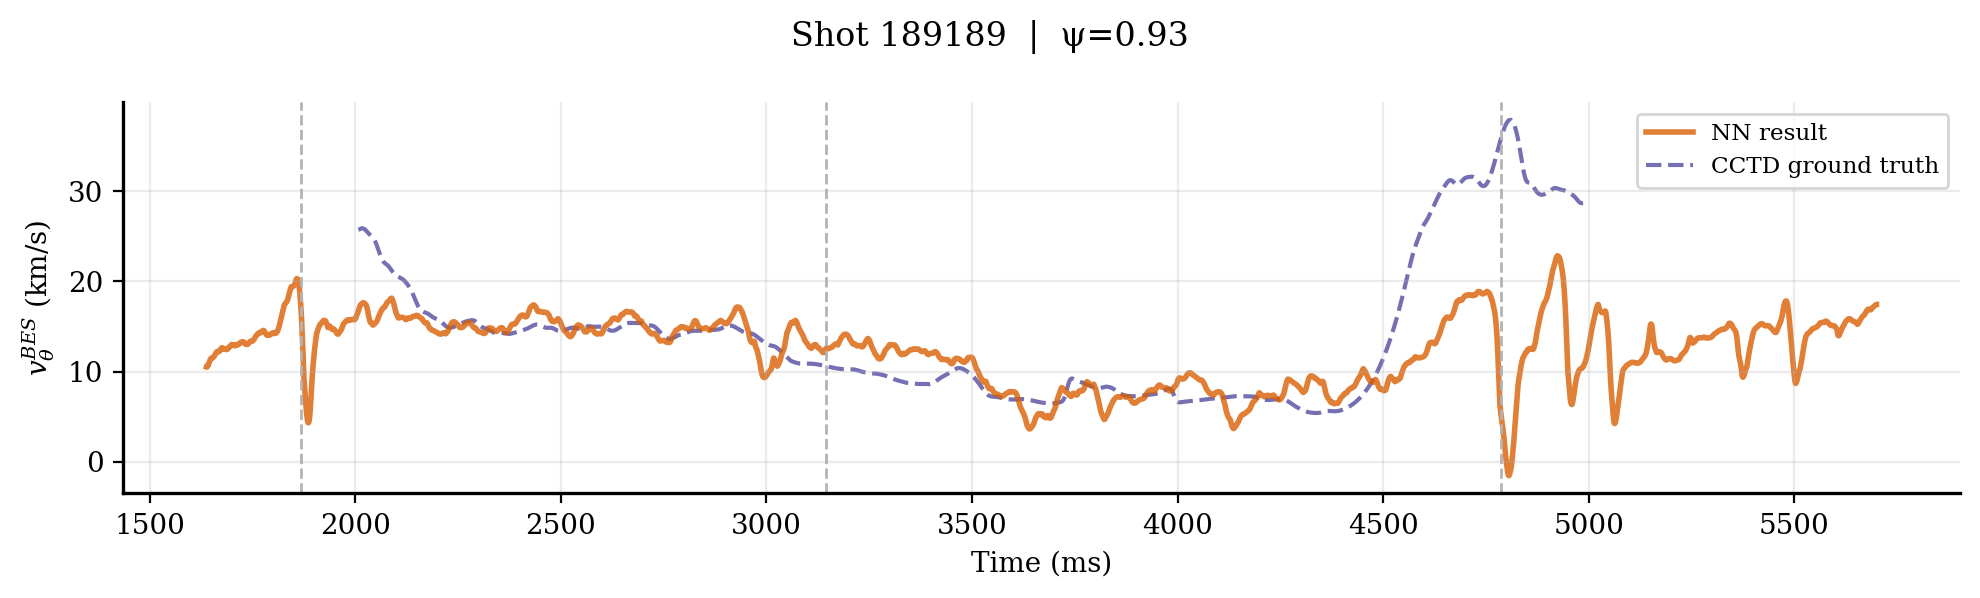

(85040,)


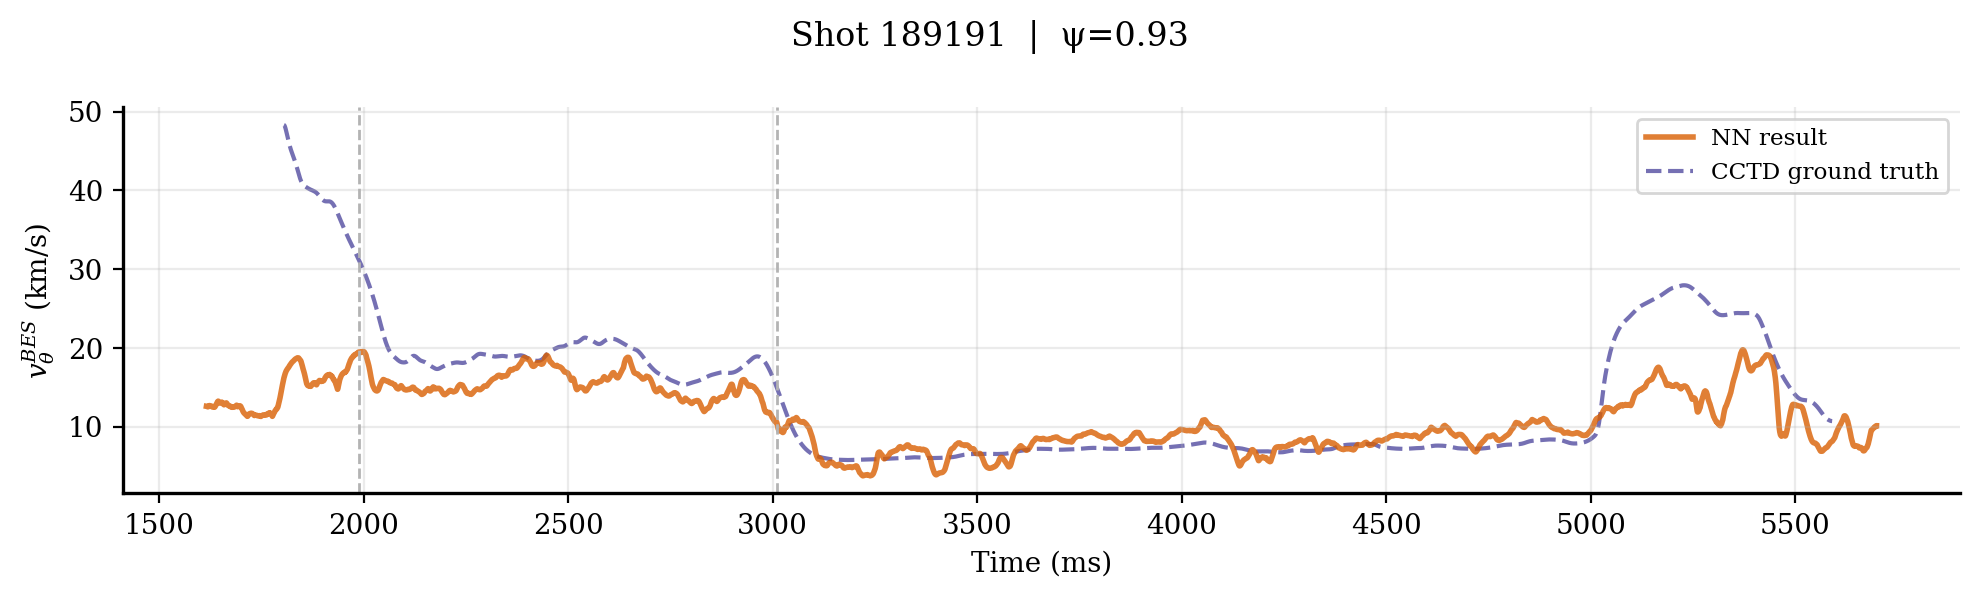

(50056,)


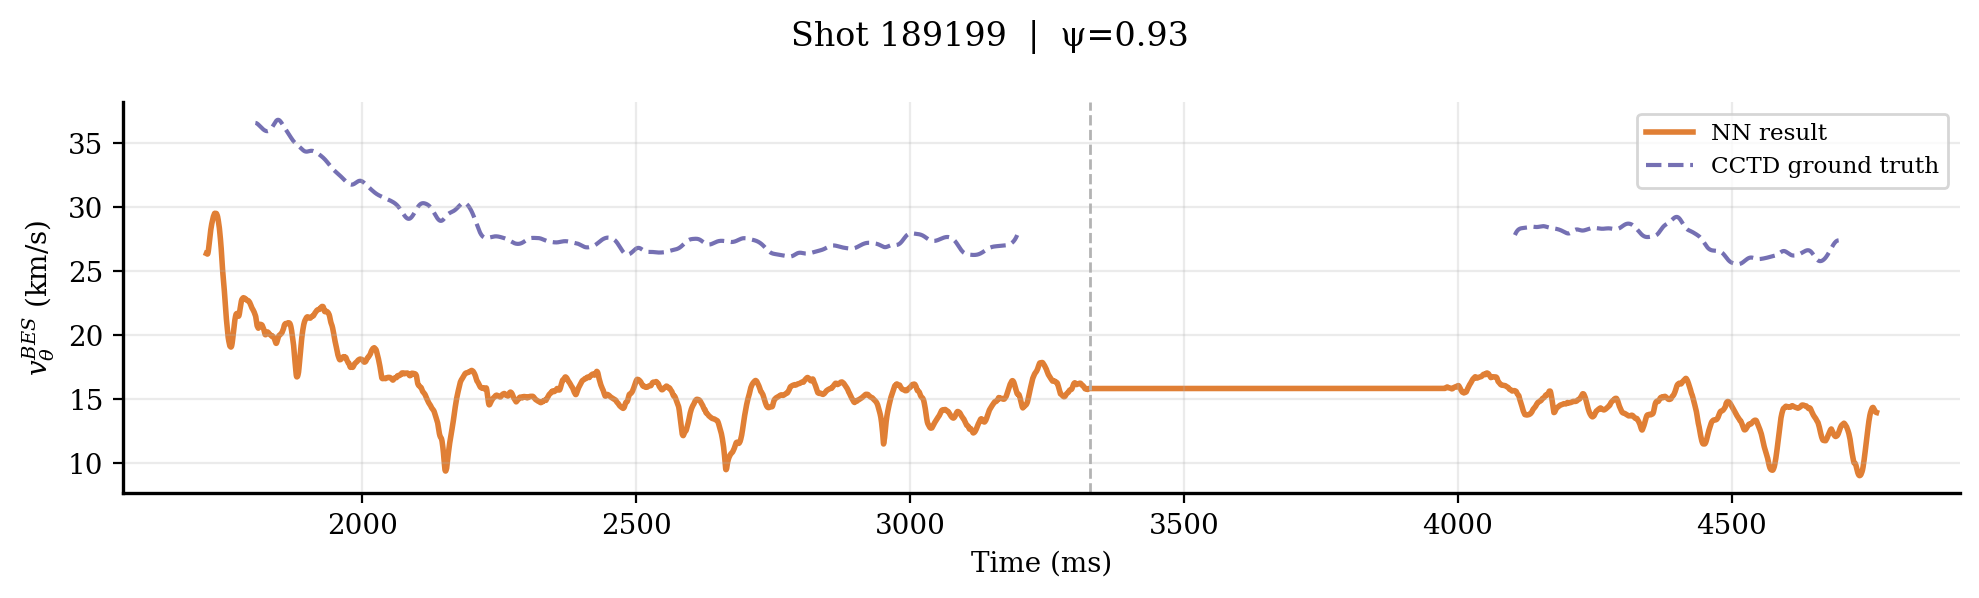

(89580,)


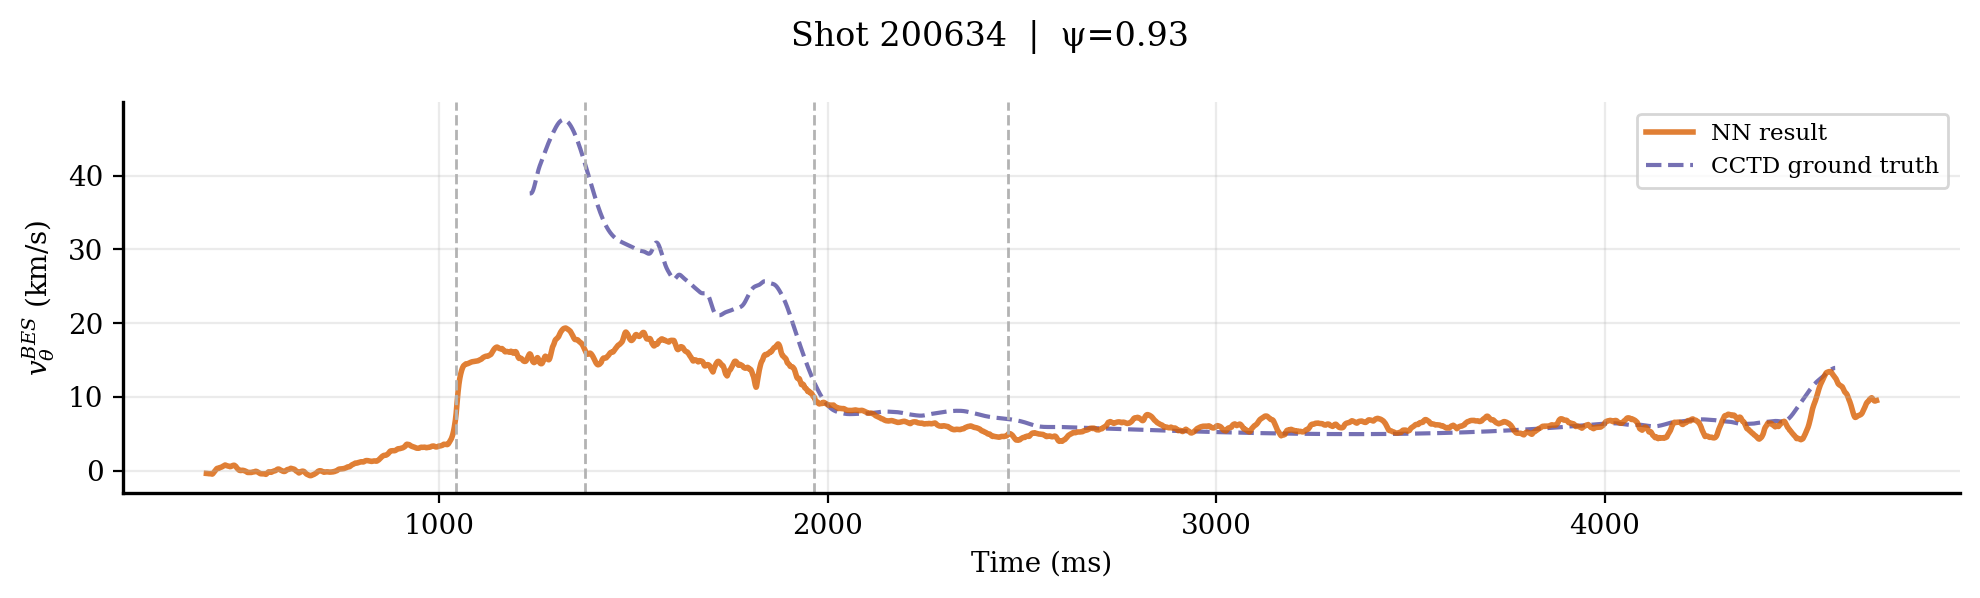

(70828,)


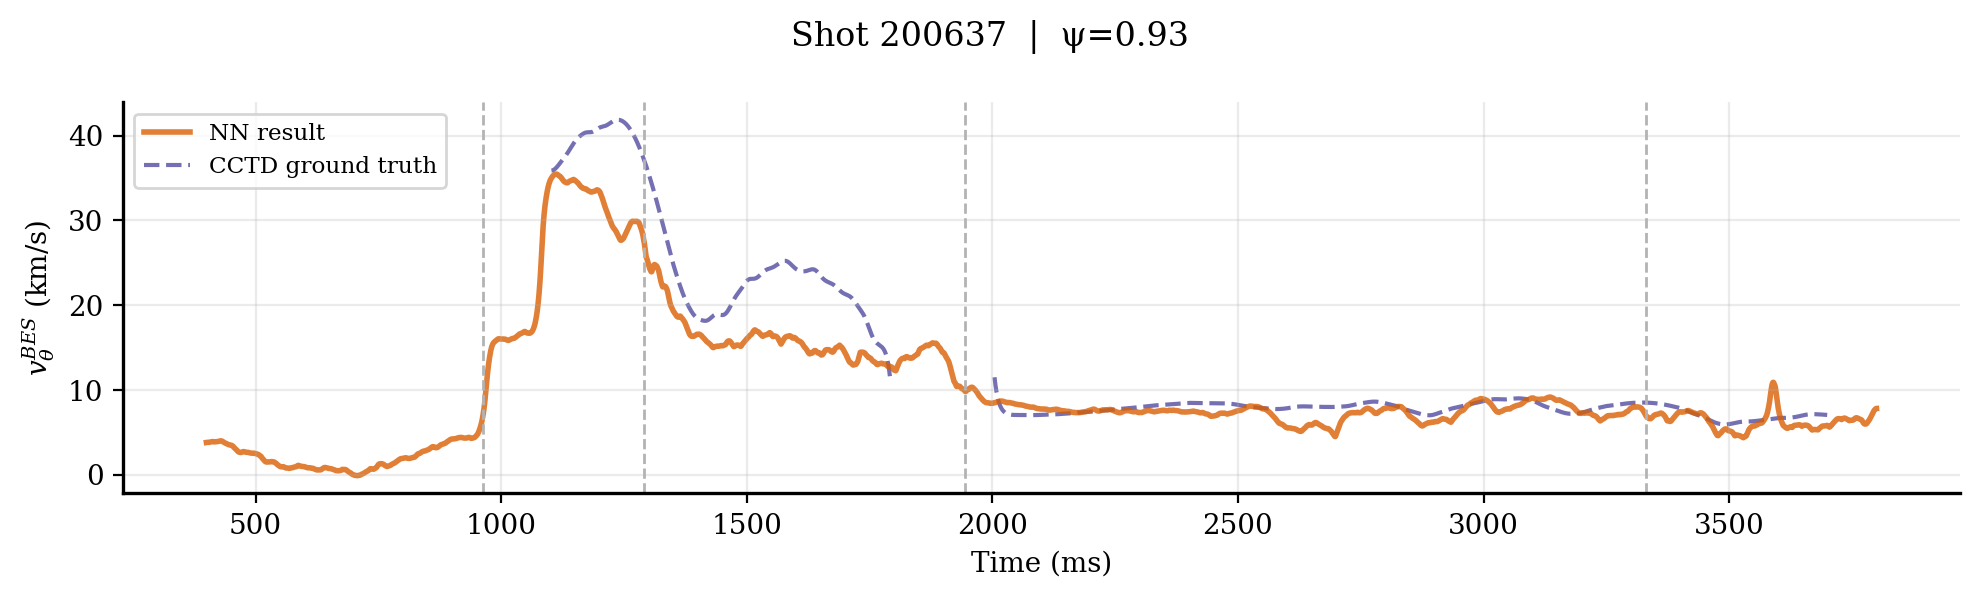

(89580,)


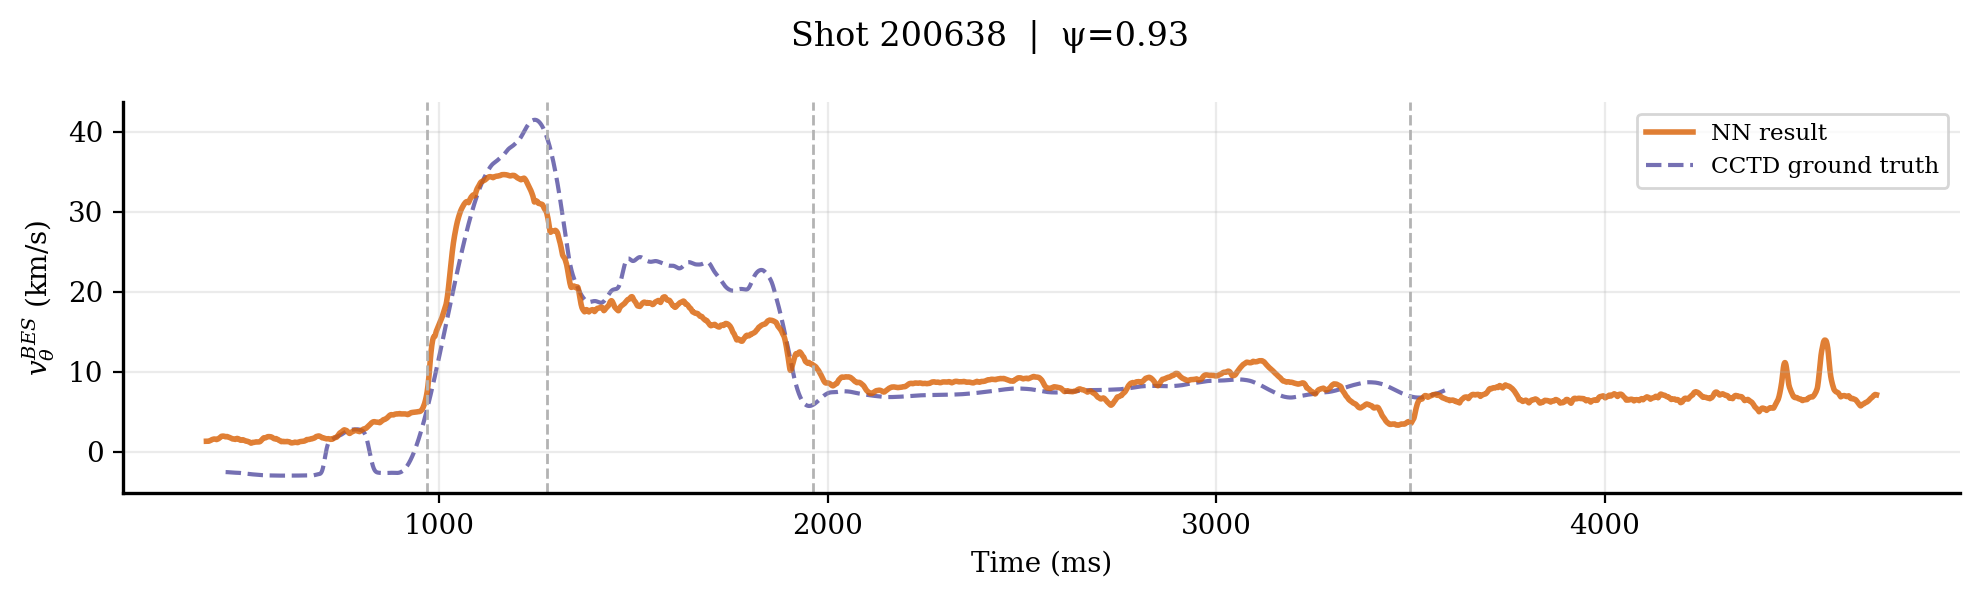

(89580,)


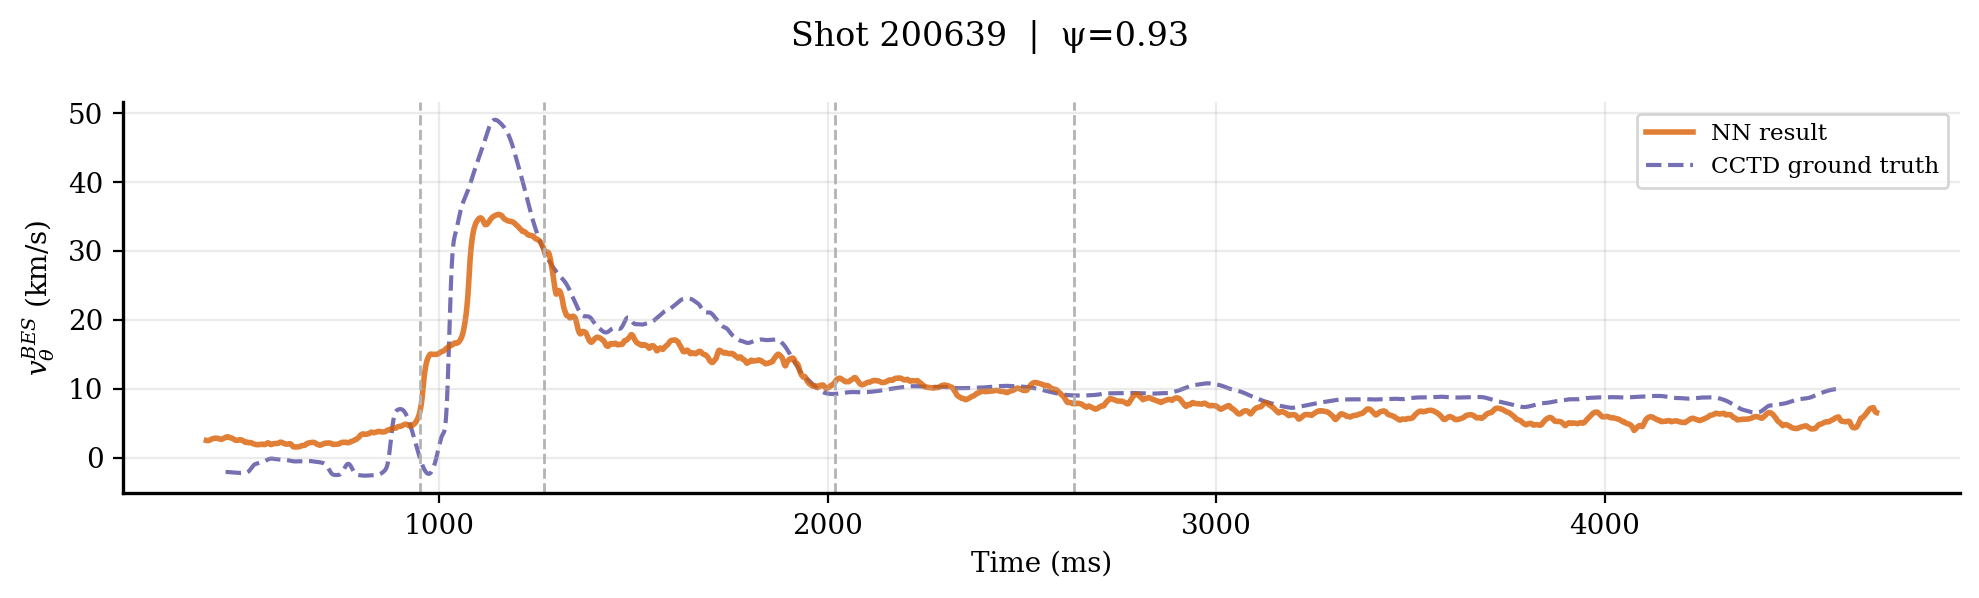

(55750,)


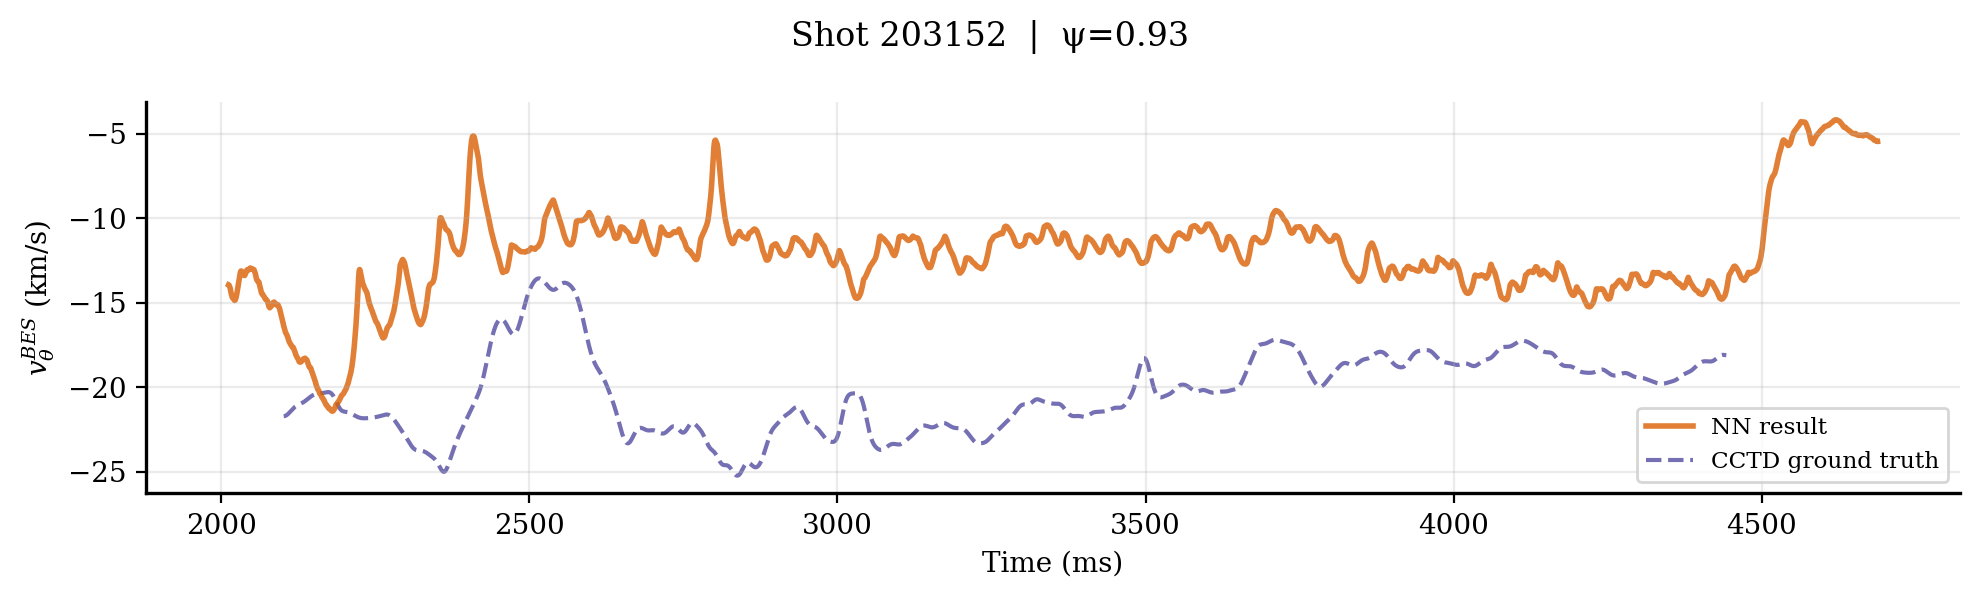

(48498,)


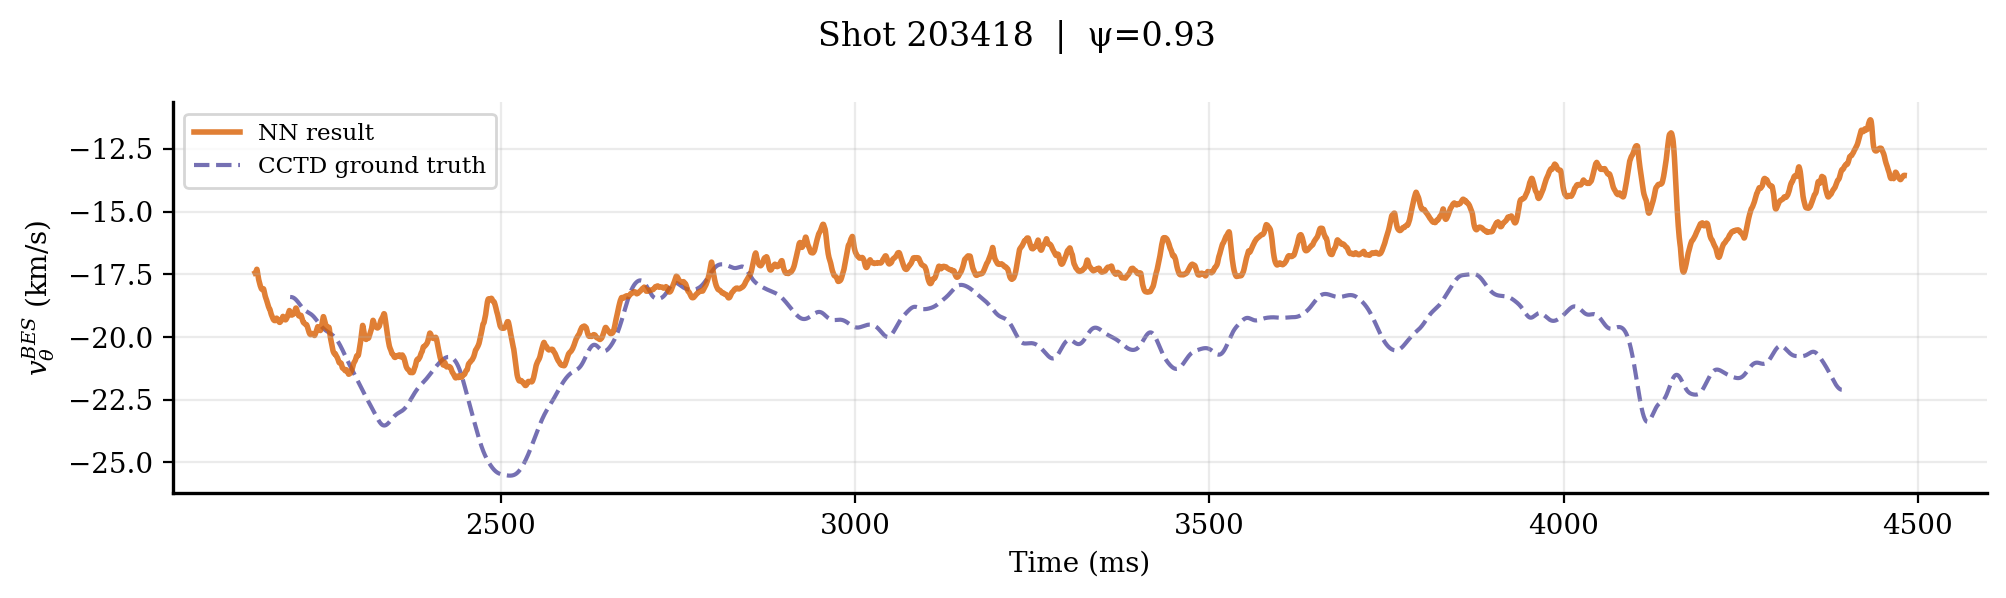

(46478,)


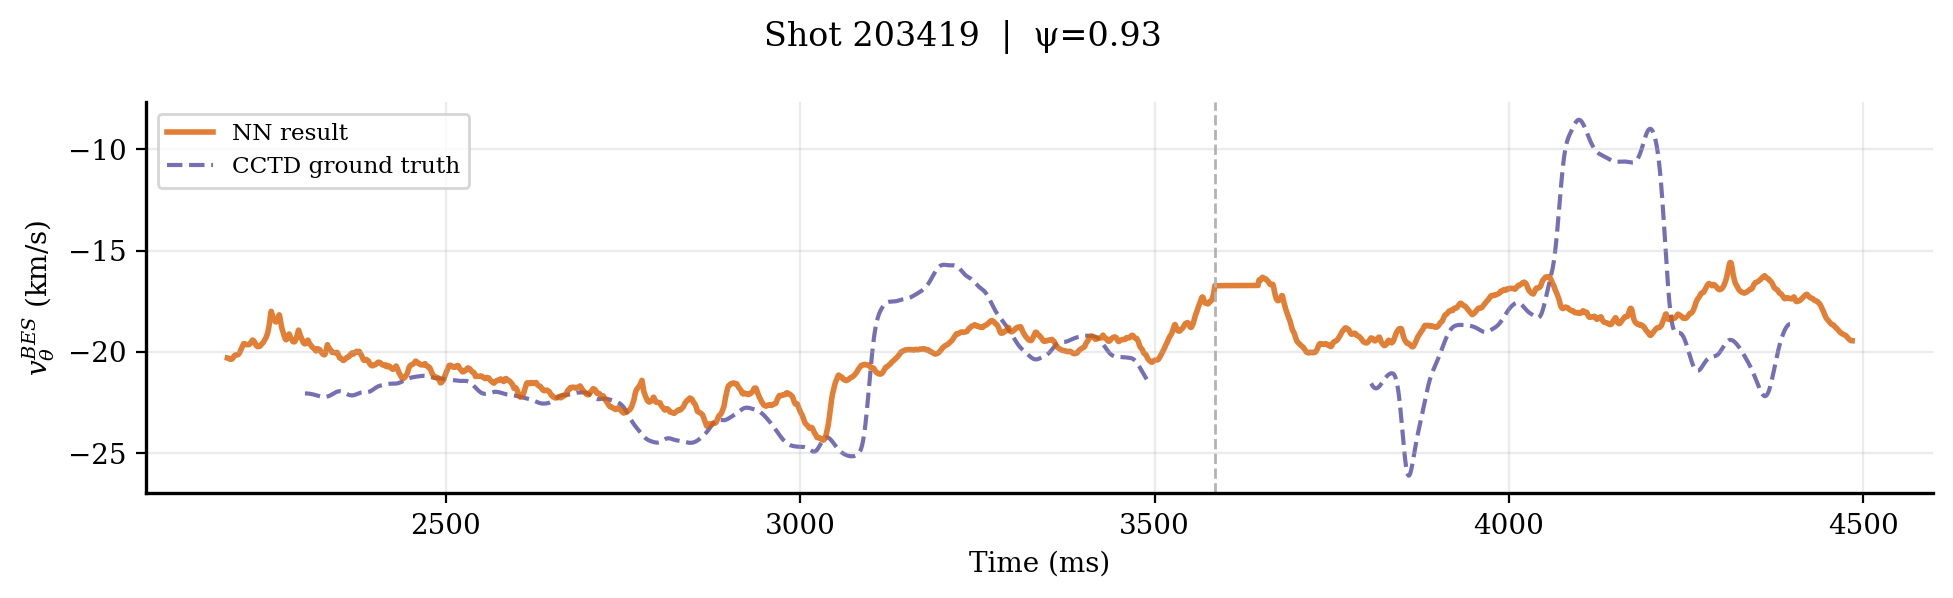

(90306,)


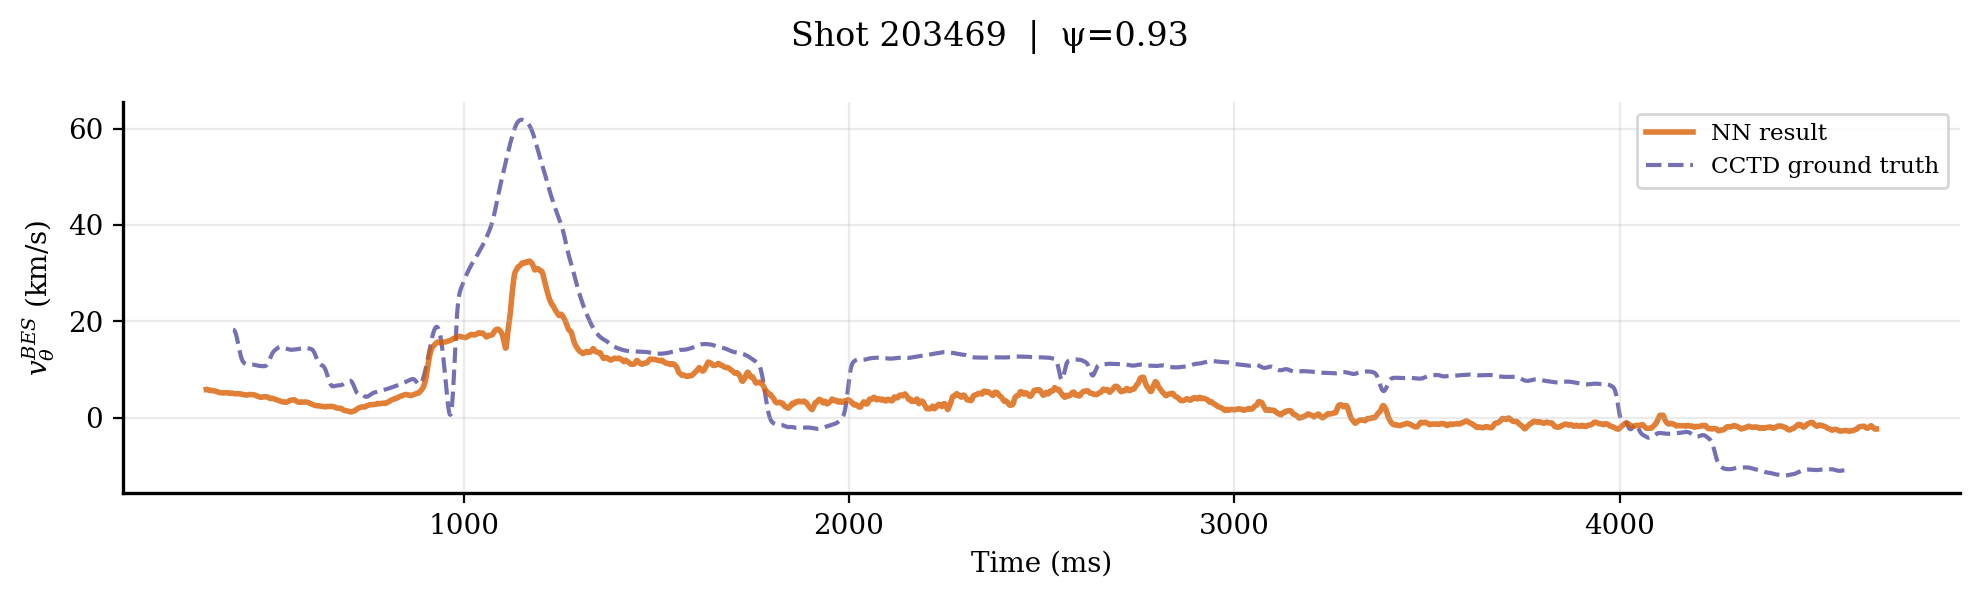

(90520,)


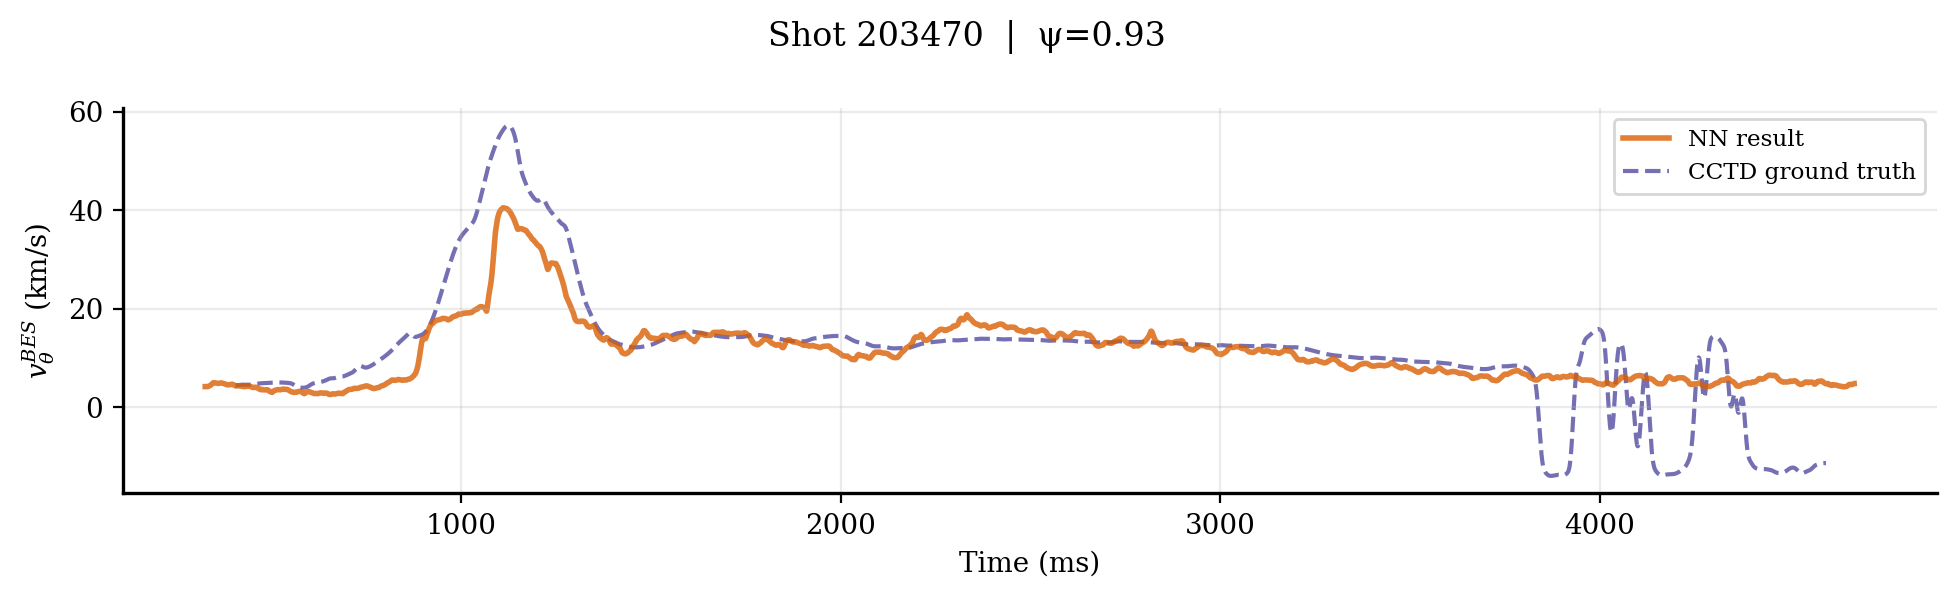

(89848,)


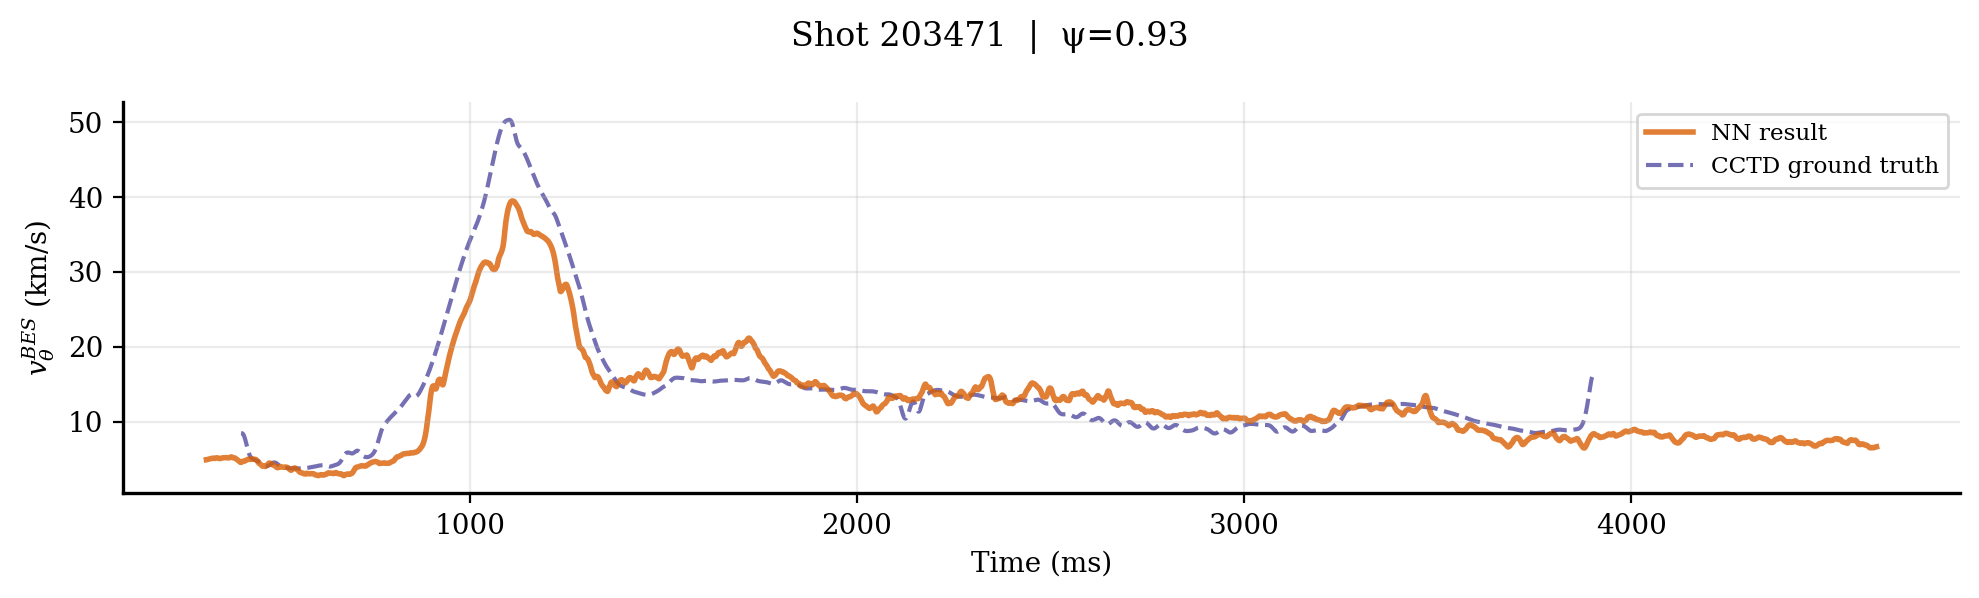

(89854,)


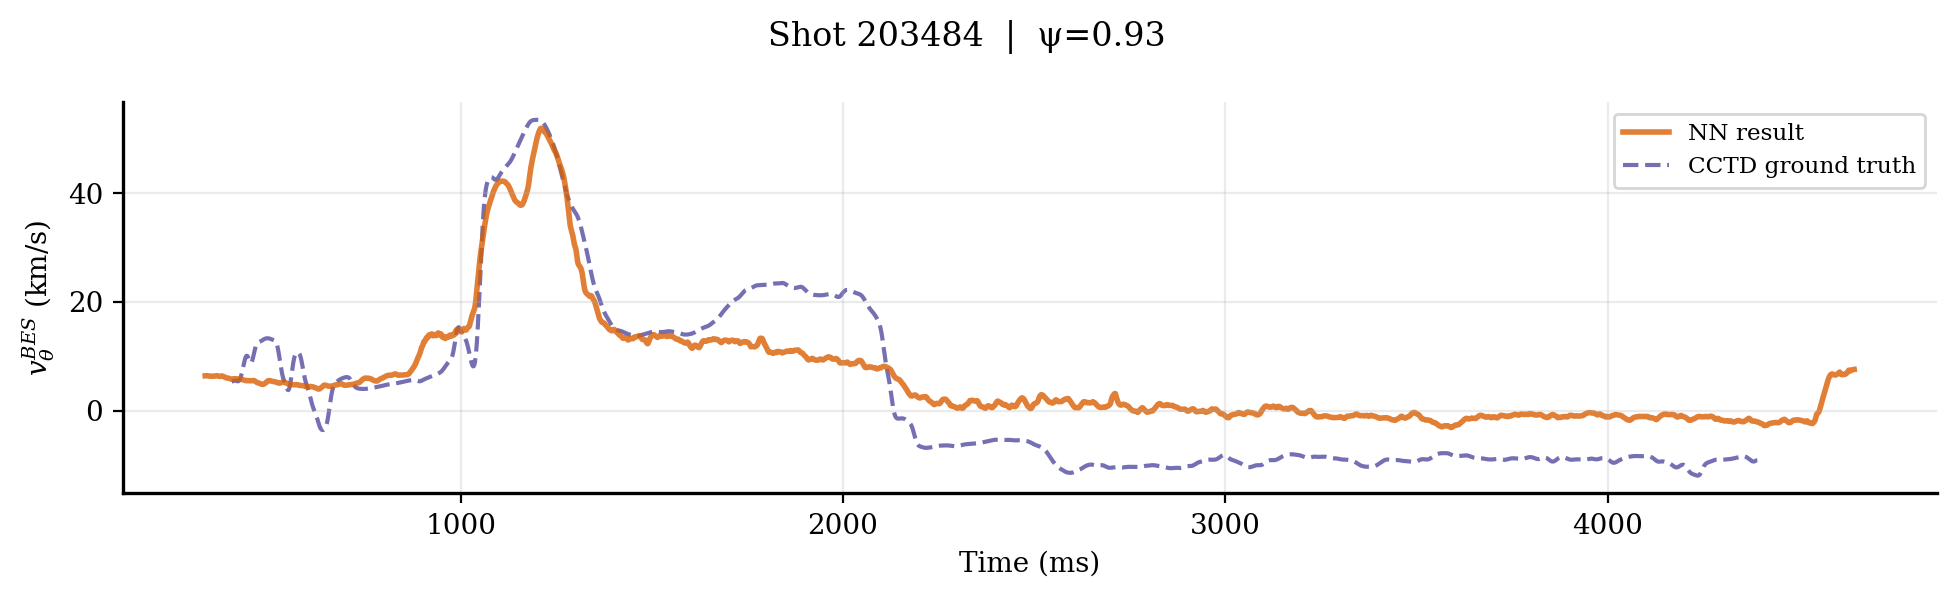

(84370,)


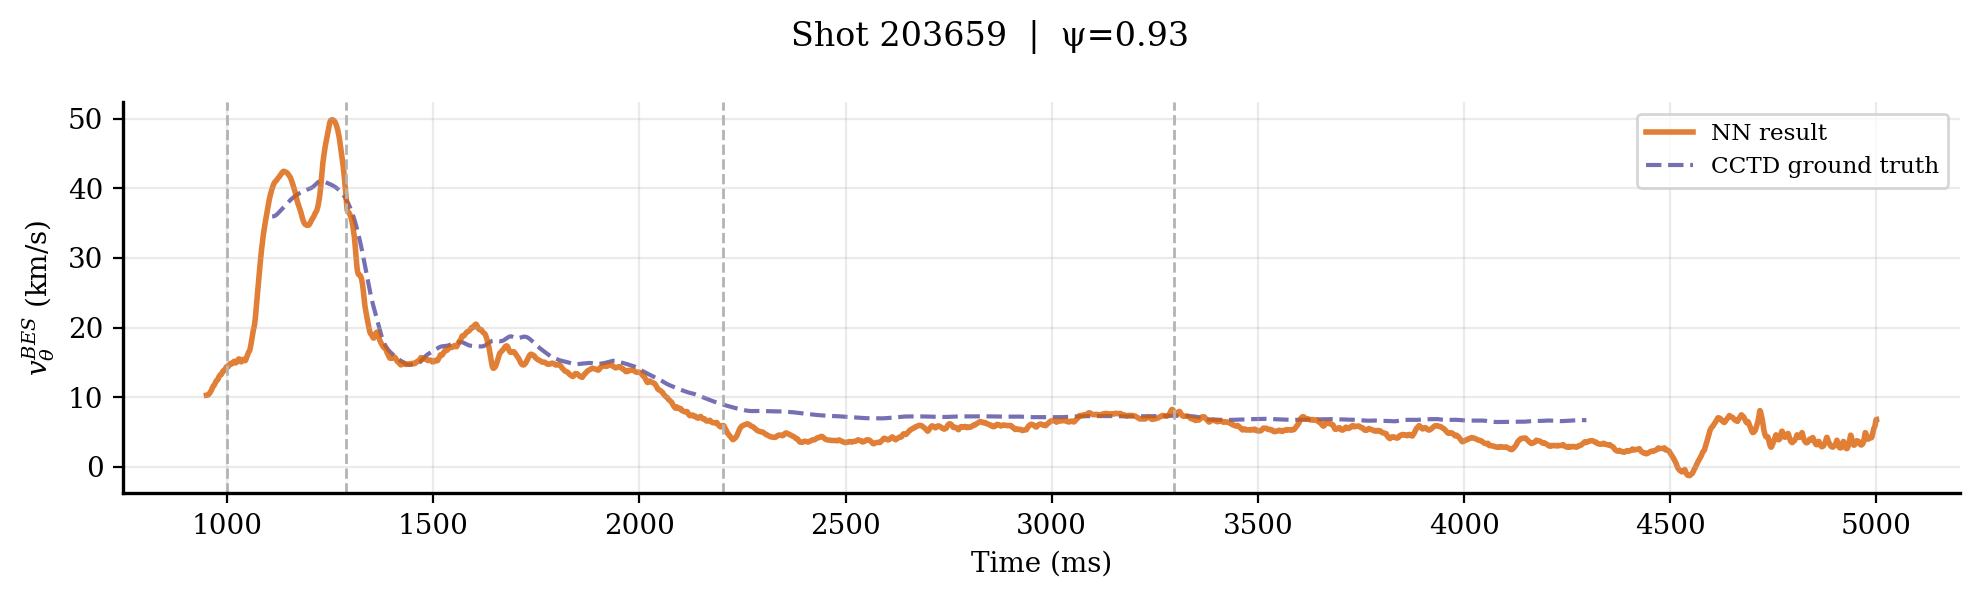

(63540,)


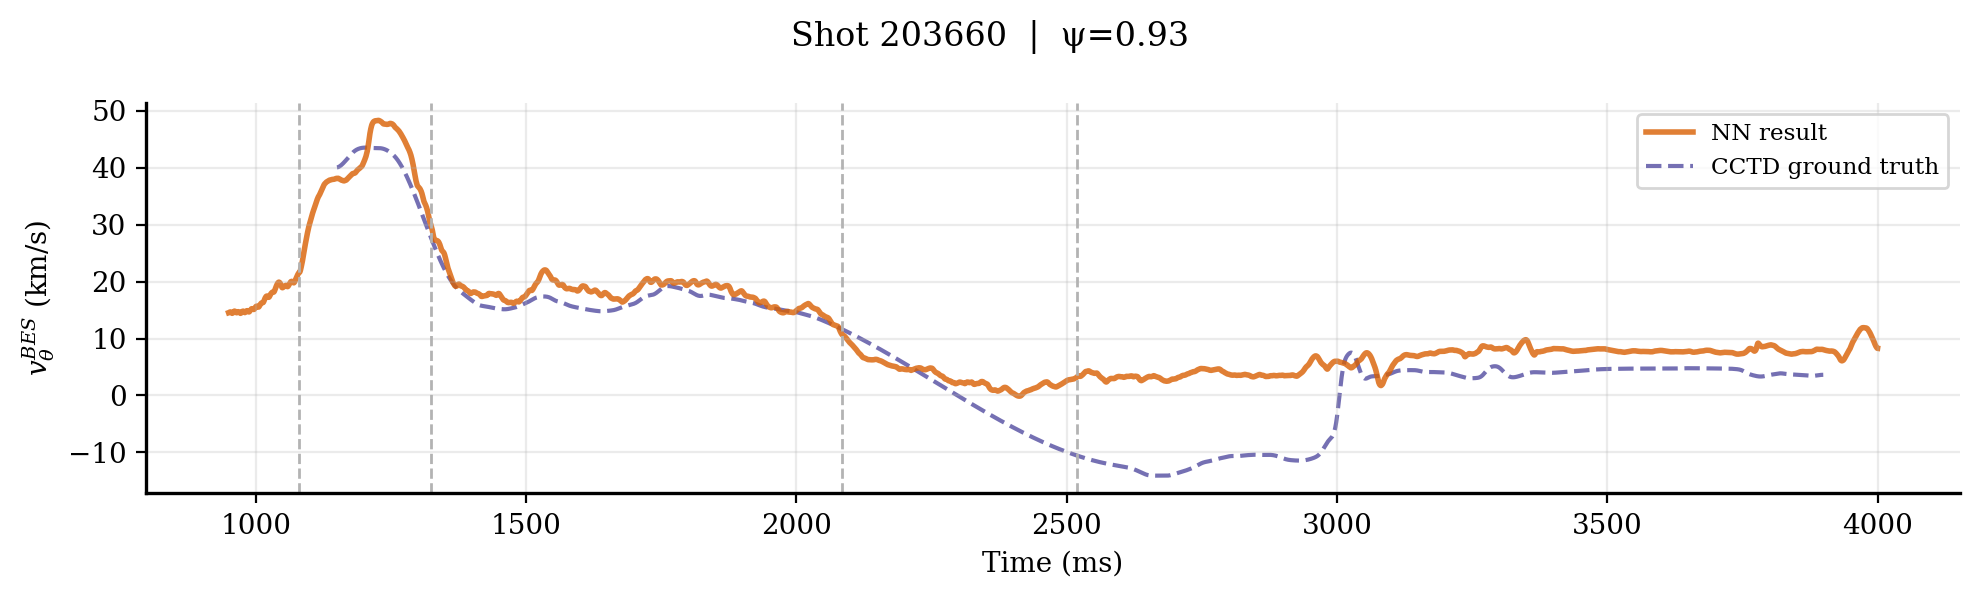

(84372,)


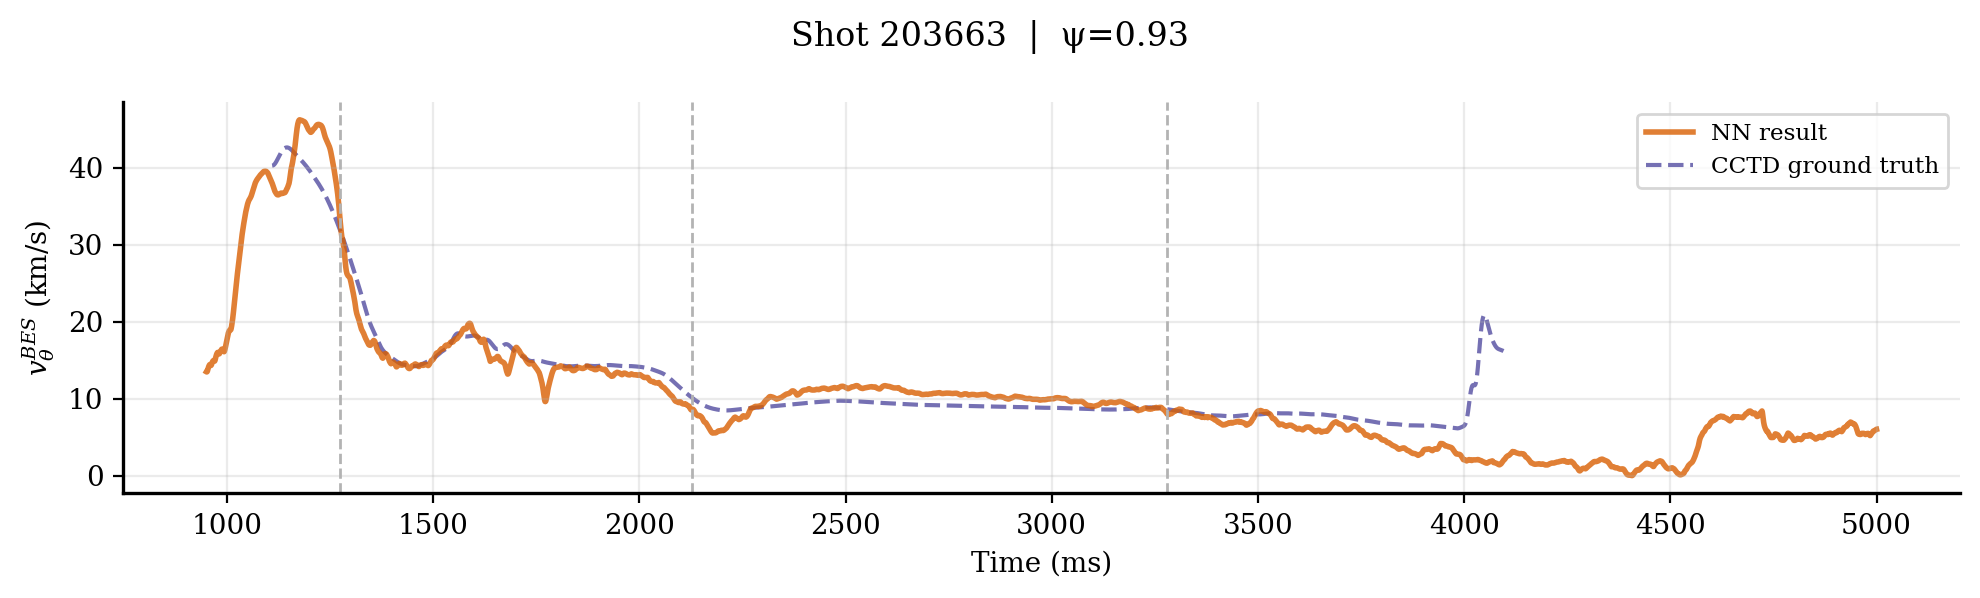

(84373,)


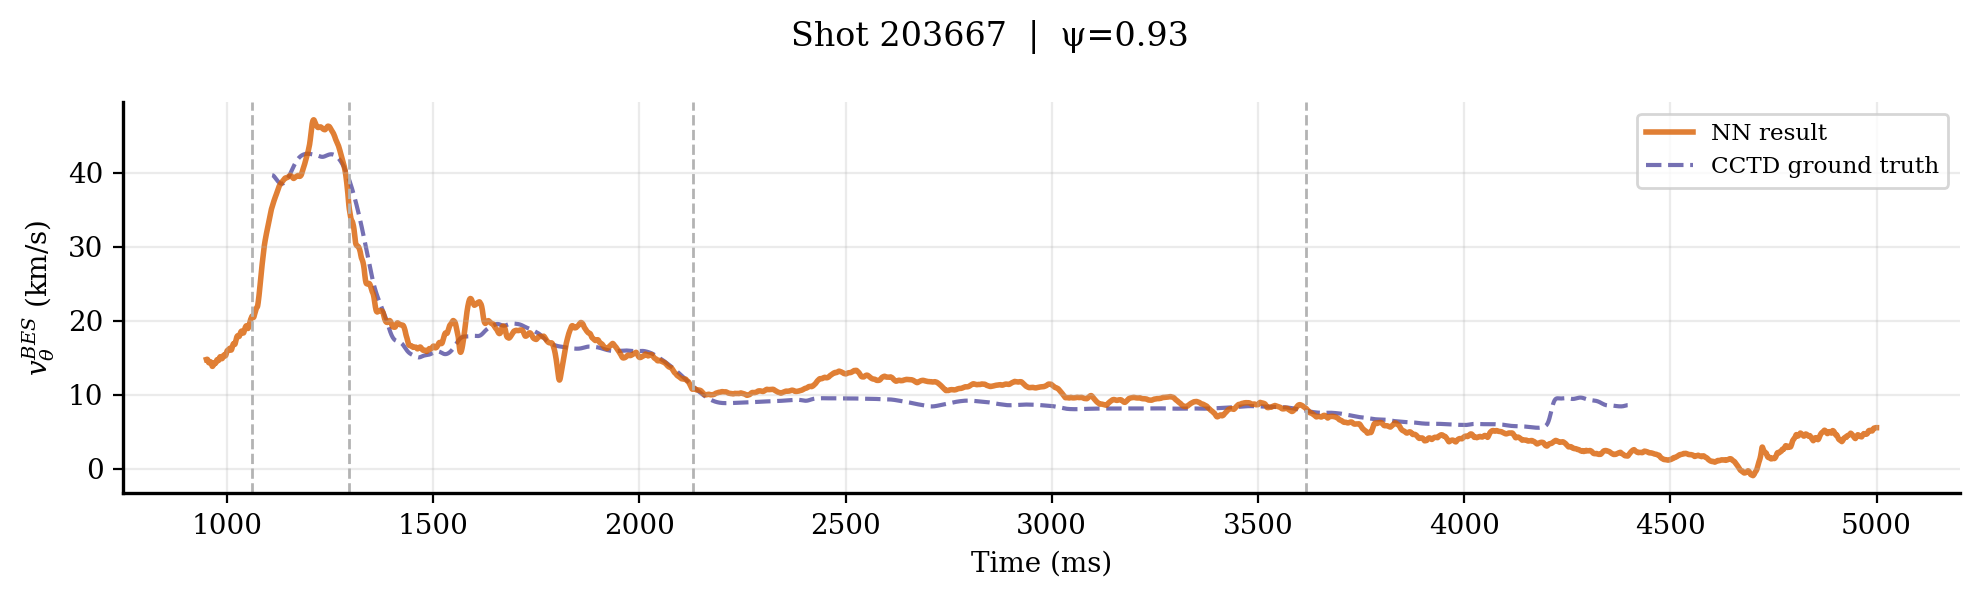

(58931,)


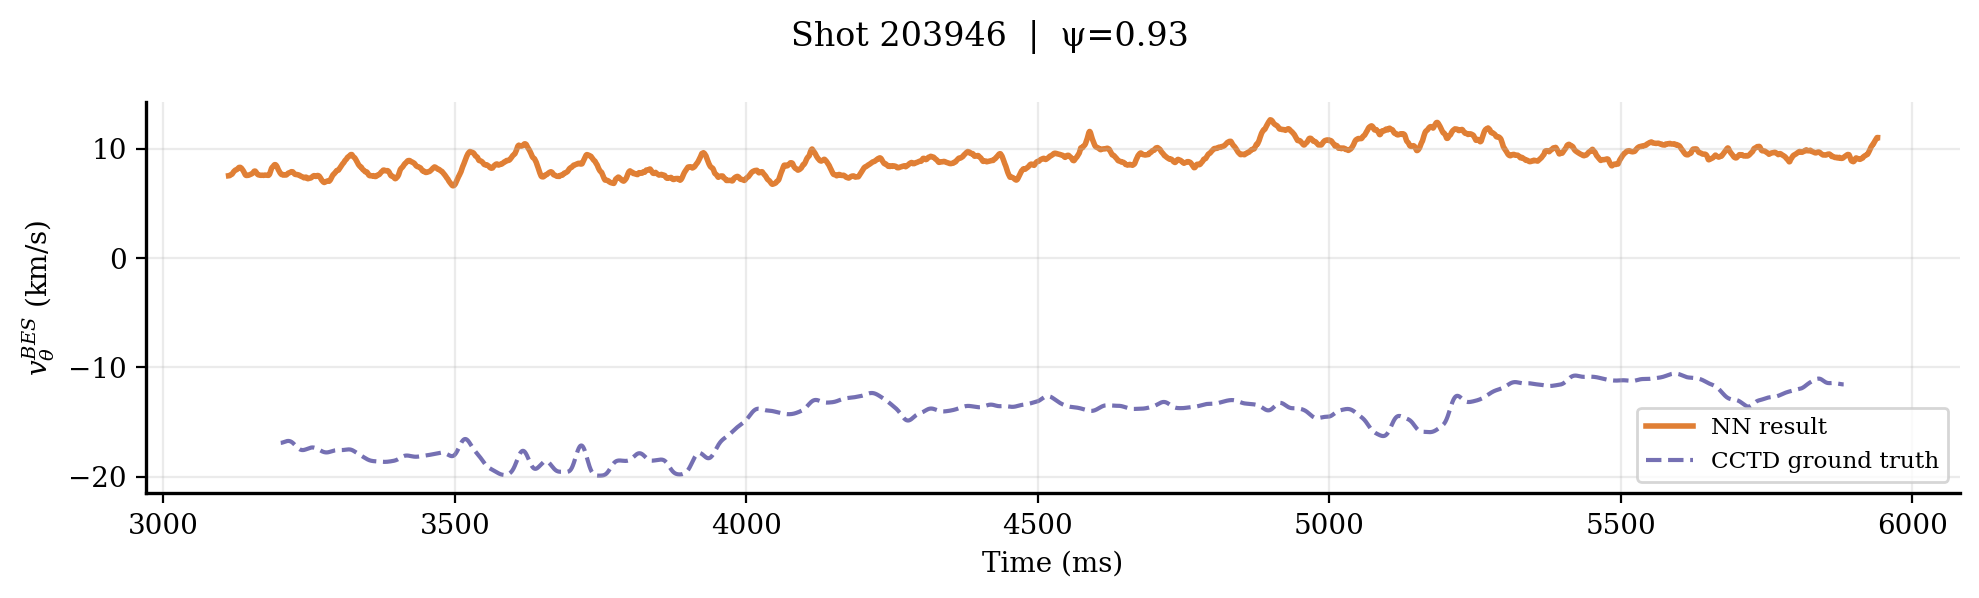

(75937,)


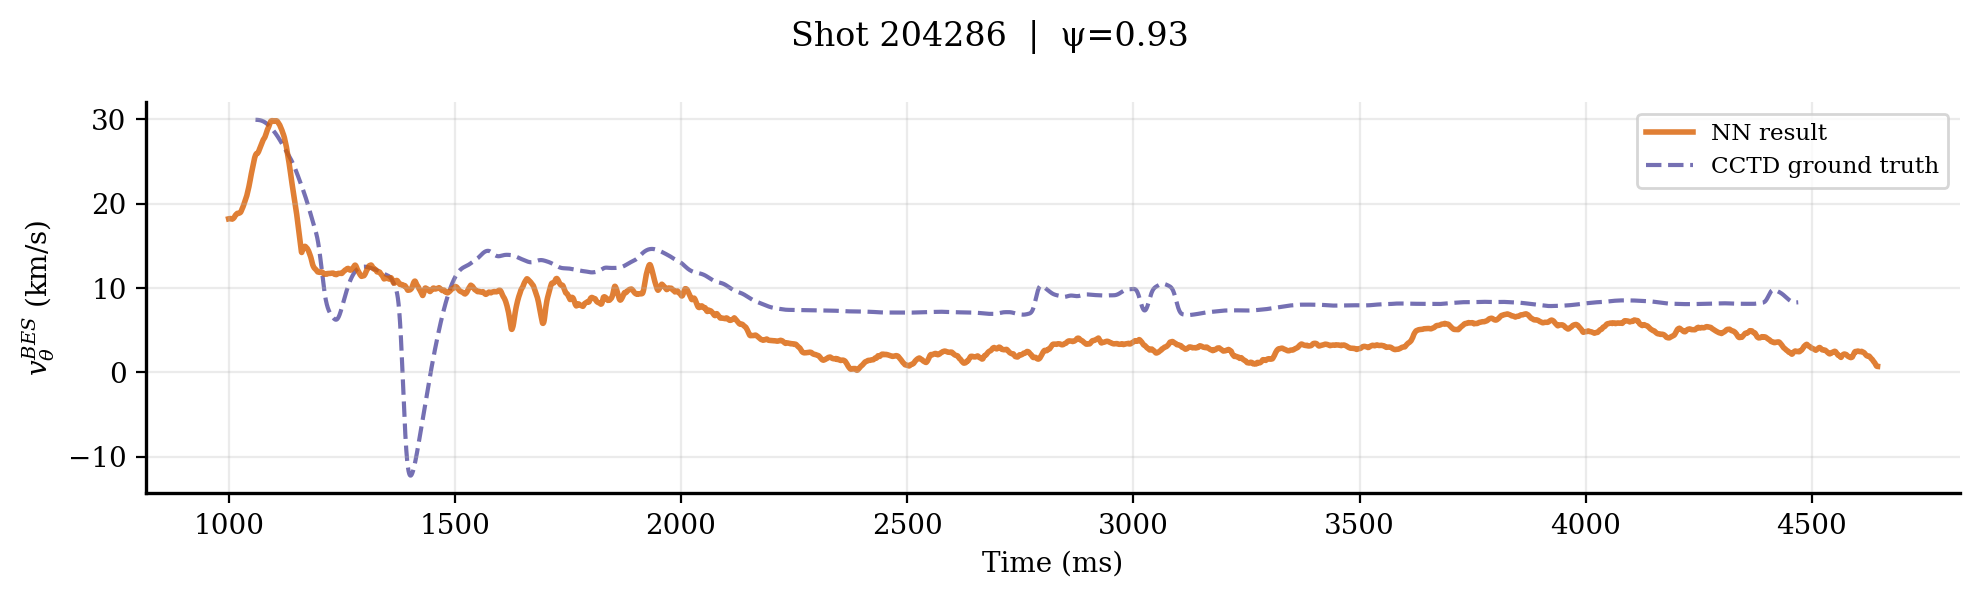

(76479,)


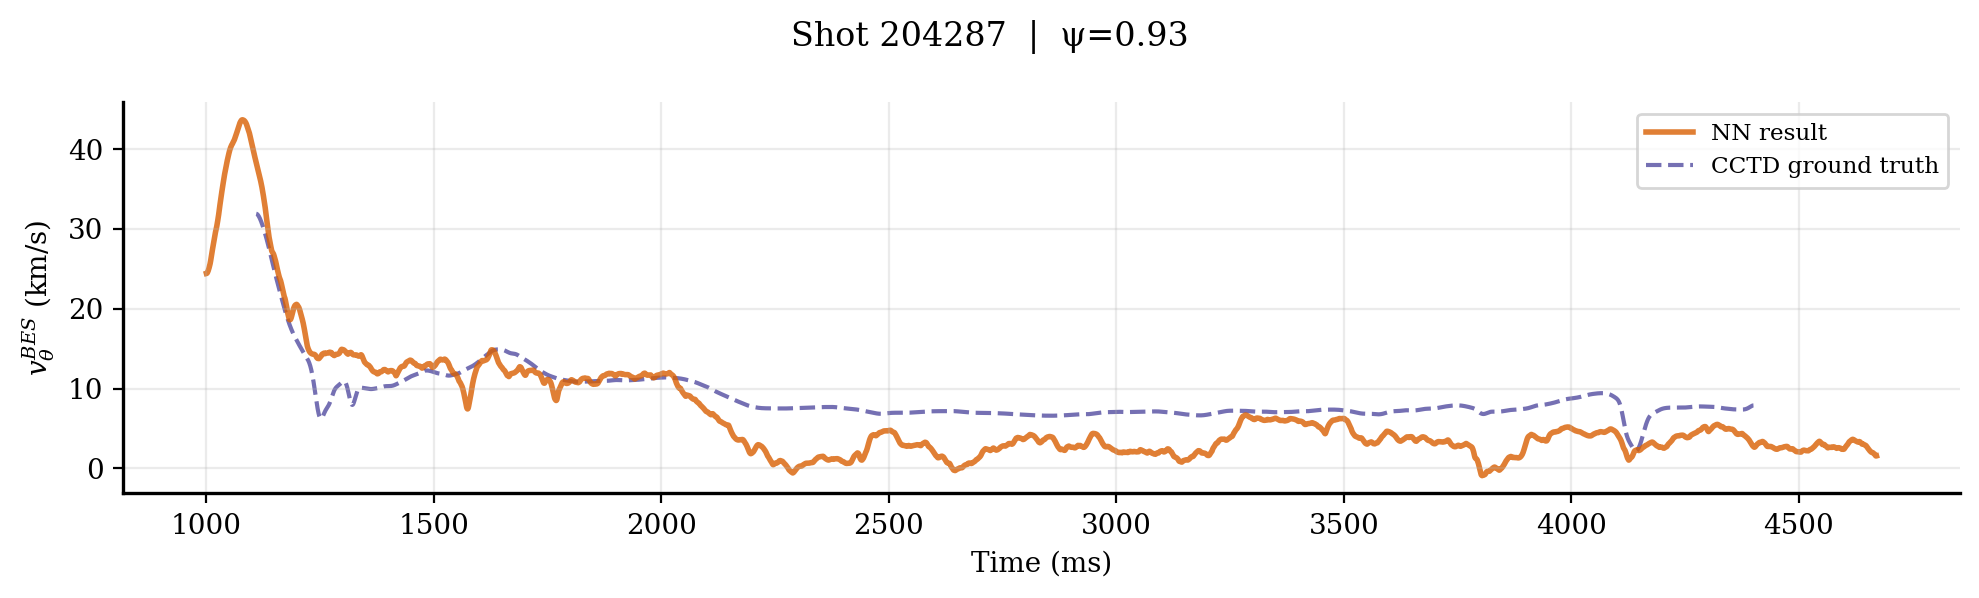

(75375,)


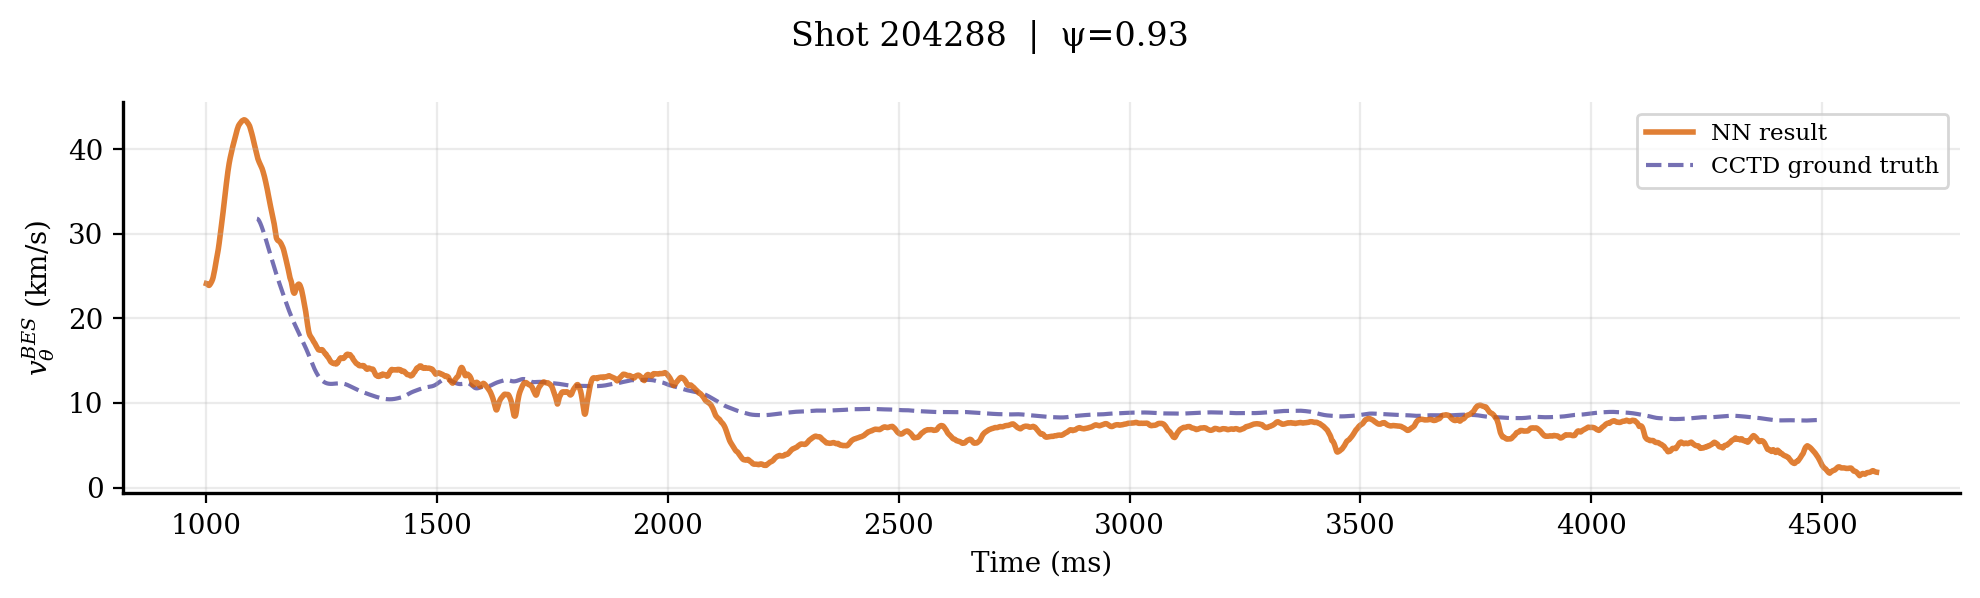

(76937,)


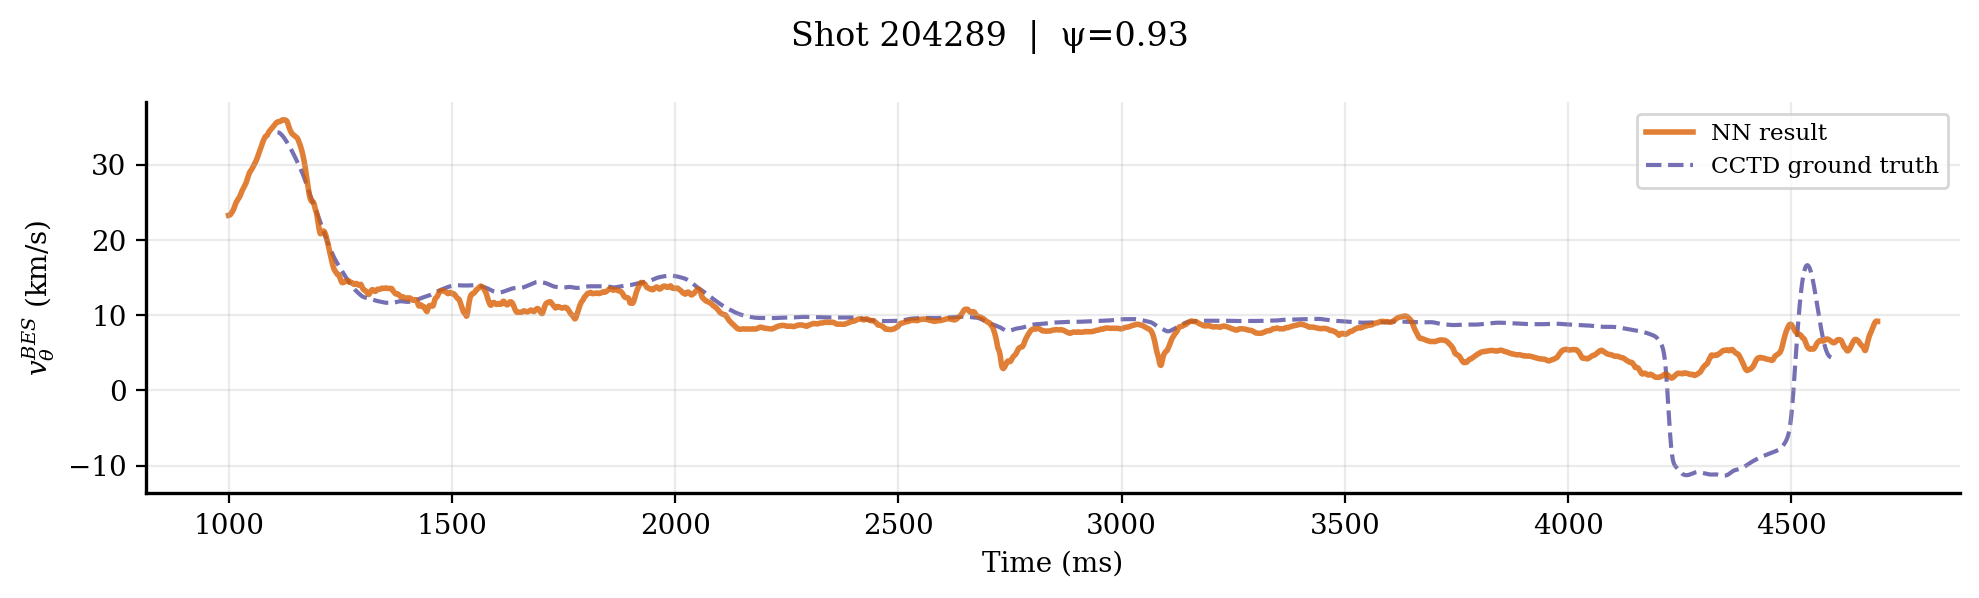

(75729,)


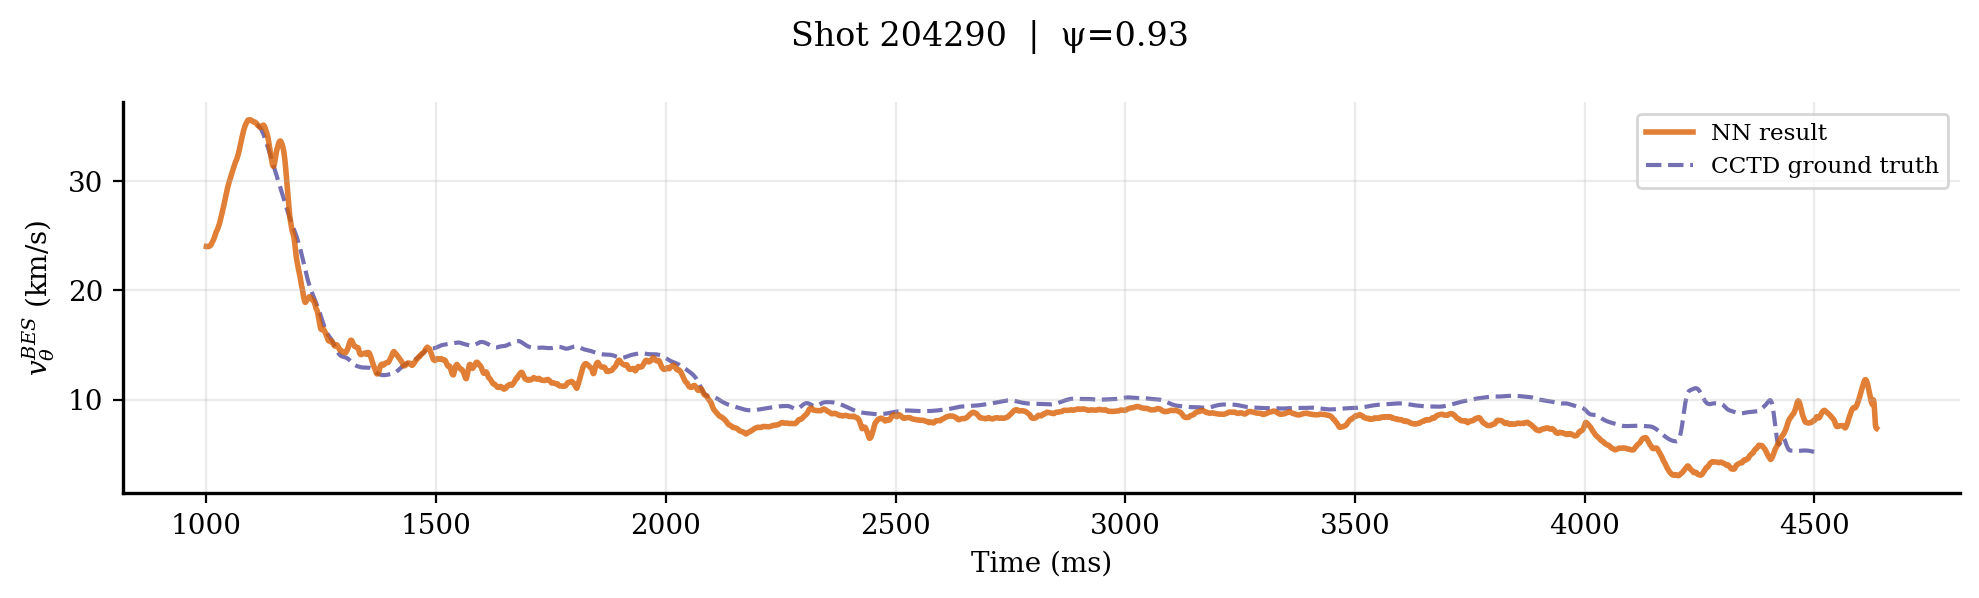

(70159,)


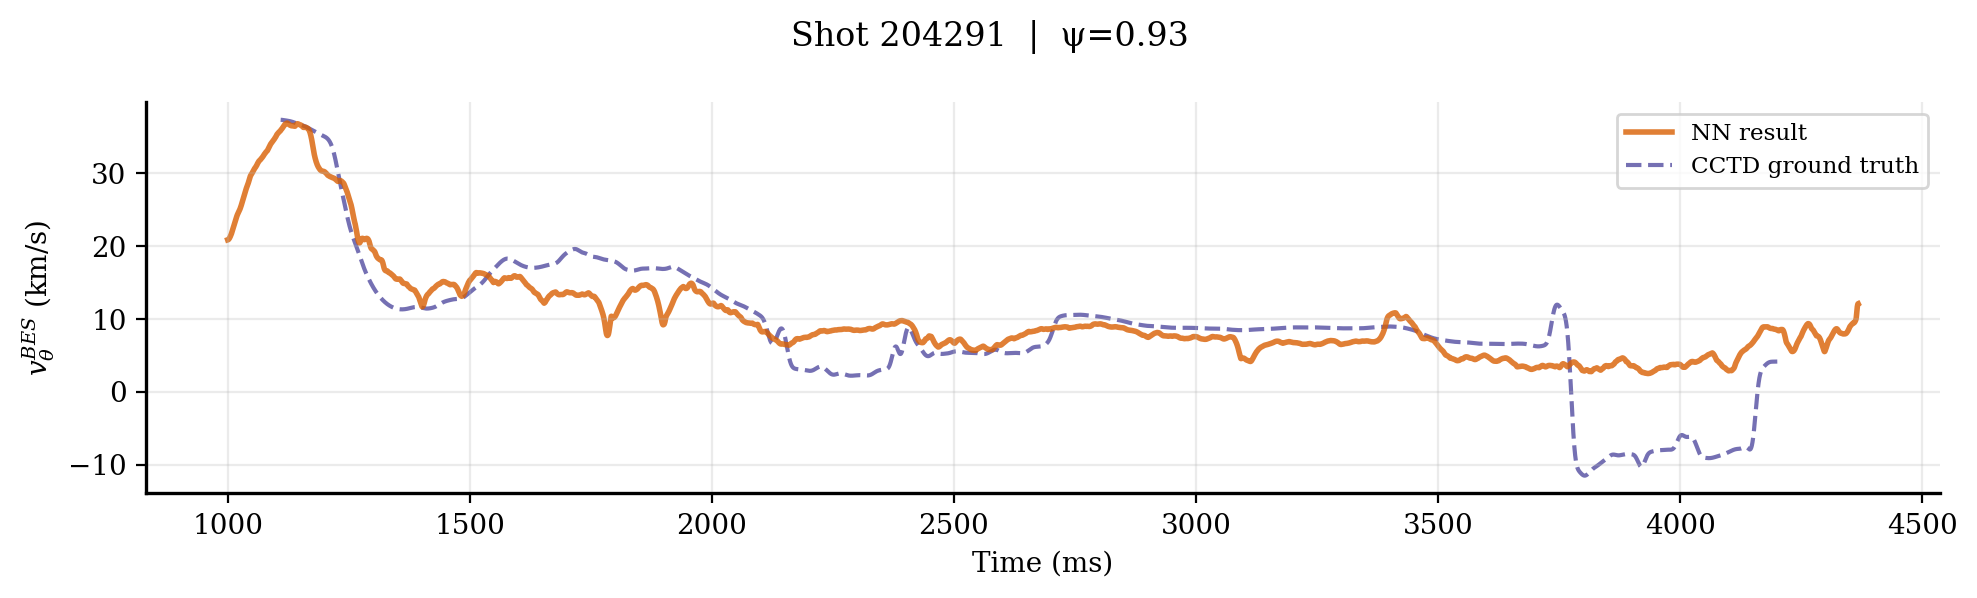

(73125,)


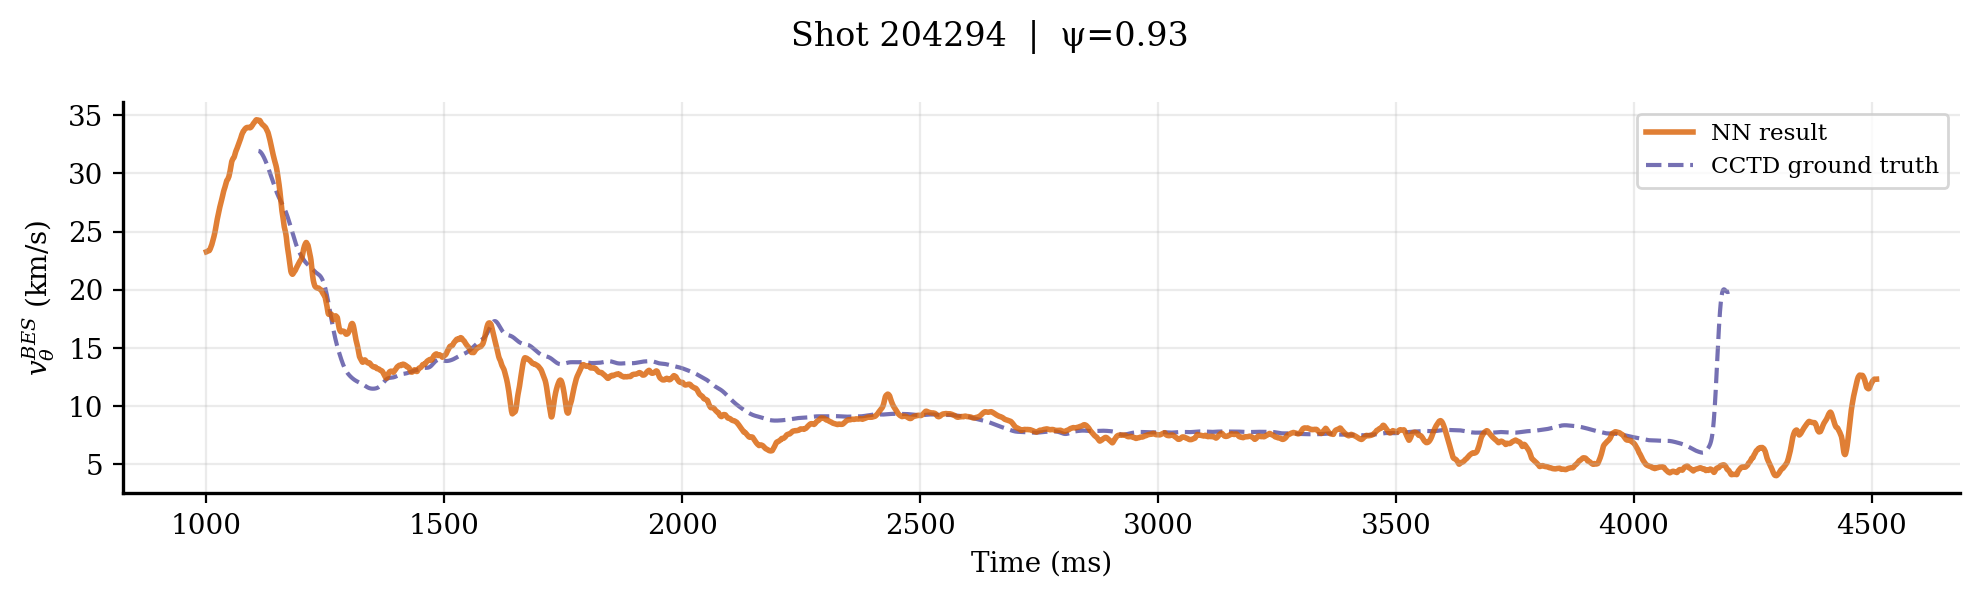

(74243,)


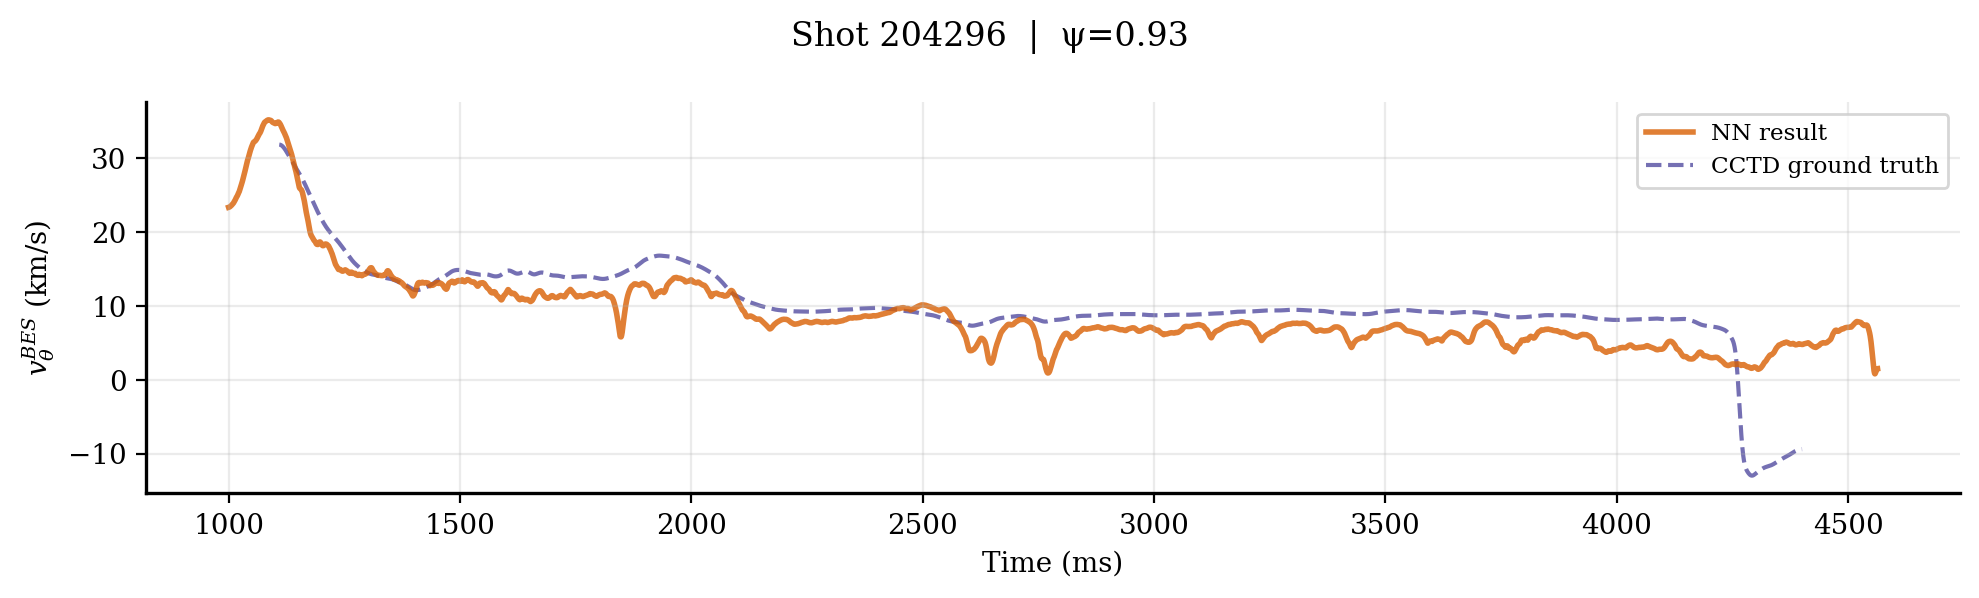

(74562,)


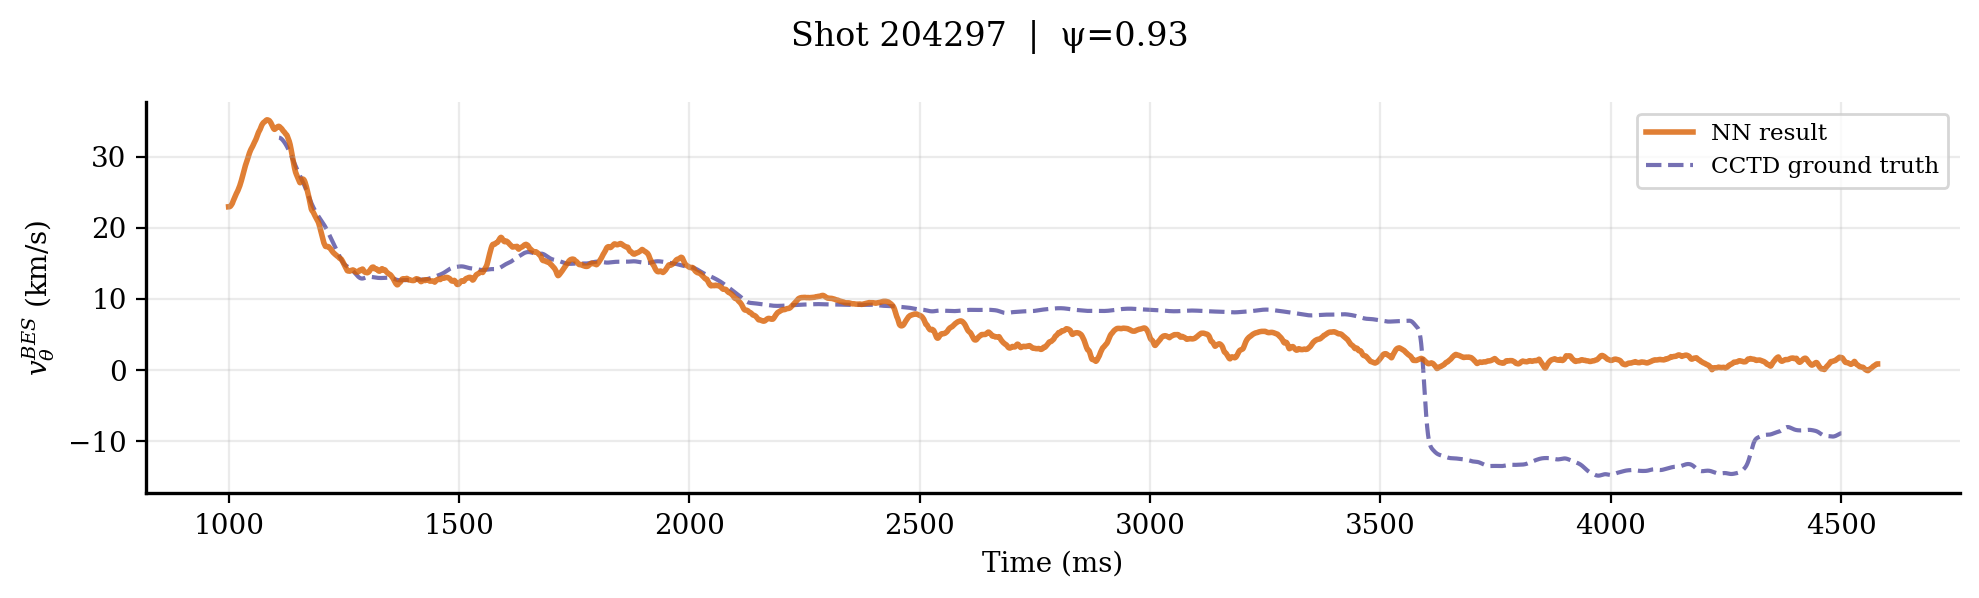

(73350,)


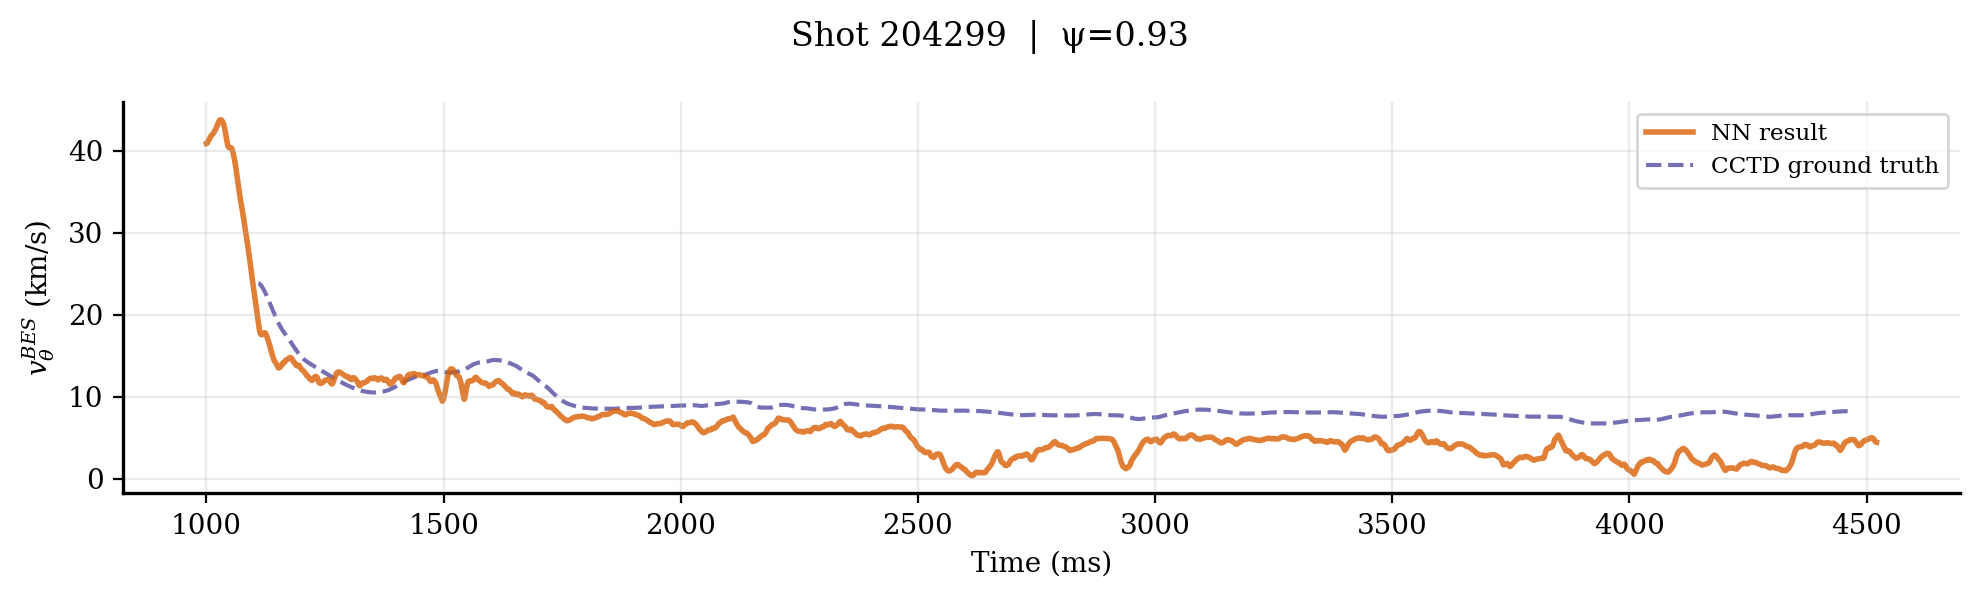

In [10]:
# Colors for prediction/truth lines.
# line_colors = ["#882255", "#009E73"]
line_colors = ["#d95f02", "#7570b3", "#009E73"]

shot_radial_time_windows = {
    '145384': {0: [[1600, 5000]], 1: [[1600, 5000]], 2: [[1600, 5000]], 3: [[1300, 5000]], 4: [[1300, 5000]], 5: [[1300, 5000]], 6: [[1400, 2400], [2600, 5000]], 7: [[2600, 5000]]}, 
    '145385': {0: [[2500, 4200]], 1: [[2500, 4200]], 2: [[2500, 4200]], 3: [[2500, 4200]], 4: [[2500, 4200]], 5: [[2500, 4200]], 6: [[2500, 4200]], 7: [[2500, 4200]]}, 
    '145387': {0: [[1800, 5150]], 1: [[1400, 5150]], 2: [[1950, 5150]], 3: [[2400, 5150]], 4: [[1100, 5150]], 5: [[900, 5150]], 6: [[2000, 5150]], 7: [[2000, 3900], [4100, 5150]]}, 
    '145388': {0: [[1600, 5100]], 1: [[1600, 5100]], 2: [[2000, 5100]], 3: [[2000, 5100]], 4: [[1100, 5100]], 5: [[1150, 1500], [1600, 5100]], 6: [[1800, 5100]], 7: [[2000, 5100]]}, 
    '145391': {0: [[1900, 4300]], 1: [[1950, 4400]], 2: [[2300, 4300]], 3: [[2400, 4400]], 4: [[1100, 4300]], 5: [[1400, 4300]], 6: [[2200, 4300]], 7: [[2650, 4200]]}, 
    '145410': {0: [[1400, 3500]], 1: [[1400, 3500]], 2: [[1400, 3500]], 3: [[2200, 3500]], 4: [[1100, 3500]], 5: [[1000, 3500]], 6: [[1000, 2400], [2500, 3500]], 7: [[1800, 2400], [2500, 3500]]},
    '145419': {0: [[1700, 5100]], 1: [[1700, 5100]], 2: [[2200, 5100]], 3: [[2200, 5100]], 4: [[1100, 5100]], 5: [[1000, 5100]], 6: [[1700, 5100]], 7: [[1850, 5100]]}, 
    '145420': {0: [[1300, 4600]], 1: [[1300, 4600]], 2: [[1300, 4600]], 3: [[1700, 4500]], 4: [[1100, 4500]], 5: [[1100, 4500]], 6: [[1500, 4500]], 7: [[1700, 2400], [2800, 4600]]}, 
    '145422': {0: [[1800, 4800]], 1: [[1800, 4800]], 2: [[1800, 4800]], 3: [[2050, 4800]], 4: [[1600, 4800]], 5: [[1000, 4800]], 6: [[1900, 4800]], 7: [[1900, 4800]]}, 
    '145425': {0: [[1300, 5200]], 1: [[1300, 5200]], 2: [[1950, 5200]], 3: [[2100, 5200]], 4: [[1300, 5200]], 5: [[1300, 5200]], 6: [[1300, 1700], [1900, 5200]], 7: [[1900, 2350], [2600, 5200]]}, 
    '145427': {0: [[1300, 5200]], 1: [[1300, 5200]], 2: [[1700, 5200]], 3: [[2000, 5200]], 4: [[1500, 5200]], 5: [[1500, 5200]], 6: [[1700, 3800], [3900, 5200]], 7: [[2000, 5200]]},
    '157303': {0: [[1500, 5500]], 1: [[1500, 5500]], 2: [[1500, 5500]], 3: [[1500, 5500]], 4: [[1500, 5500]], 5: [[1500, 5500]], 6: [[1500, 2200], [2700, 5500]], 7: [[1600, 2200], [2700, 3800], [4100, 4200]]}, 
    '157322': {0: [[1450, 4800]], 1: [[1450, 4800]], 2: [[1450, 4800]], 3: [[1450, 4800]], 4: [[1450, 4800]], 5: [[1450, 2700], [2900, 4700]], 6: [[1450, 4600]], 7: [[1450, 2200], [2500, 2700], [300, 4500]]}, 
    '157323': {0: [[1450, 4400]], 1: [[1600, 4400]], 2: [[2000, 4400]], 3: [[1450, 4400]], 4: [[1450, 5000]], 5: [[1600, 4600]], 6: [[1600, 2200], [3000, 4100]], 7: [[2600, 3500], [3650, 4200]]}, 
    '157372': {0: [[1400, 6000]], 1: [[1800, 6000]], 2: [[1800, 6000]], 3: [[1300, 6000]], 4: [[1600, 6000]], 5: [[1800, 6000]], 6: [[2400, 5700]], 7: [[2500, 3000], [3200, 4300]]}, 
    '157373': {0: [[1600, 6000]], 1: [[1700, 6000]], 2: [[2200, 6000]], 3: [[1200, 6000]], 4: [[1600, 6000]], 5: [[1800, 6000]], 6: [[2400, 5500], [5600, 6000]], 7: [[2600, 5300]]}, 
    '157374': {0: [[1800, 6000]], 1: [[2200, 6000]], 2: [[1800, 6000]], 3: [[1800, 6000]], 4: [[1600, 6000]], 5: [[1800, 6000]], 6: [[2200, 2300], [2400, 3900], [4100, 6000]], 7: [[3900, 5200]]}, 
    '157375': {0: [[1400, 5600]], 1: [[1800, 5600]], 2: [[1800, 5600]], 3: [[1600, 5600]], 4: [[1600, 5600]], 5: [[1800, 5600]], 6: [[2000, 5600]], 7: [[3100, 3400]]}, 
    '157376': {0: [[1500, 6000]], 1: [[1600, 6000]], 2: [[2000, 6000]], 3: [[800, 6000]], 4: [[1600, 6000]], 5: [[1600, 3800], [4000, 6000]], 6: [[2000, 3800], [4000, 6000]], 7: [[2200, 3800]]}, 
    '157377': {0: [[1500, 6000]], 1: [[1500, 6000]], 2: [[1600, 6000]], 3: [[1400, 6000]], 4: [[1600, 6000]], 5: [[1800, 5000]], 6: [[1800, 2300], [2400, 5300]], 7: [[2500, 4300]]}, 
    '158076': {0: [[2000, 6000]], 1: [[2000, 5400]], 2: [[2200, 5400]], 3: [[2000, 6000]], 4: [[2000, 6000]], 5: [[3200, 6000]], 6: [[4600, 5800]]}, 
    '159443': {0: [[1800, 5400]], 1: [[2400, 5100]], 2: [[2300, 5300]], 3: [[2400, 5300]], 4: [[1800, 5300]], 5: [[1800, 5300]], 6: [[2600, 5300]], 7: [[2900, 5000]]}, 
    '189189': {1: [[1800, 5200]], 2: [[1900, 2600], [2700, 4500], [4600, 5300]], 3: [[2000, 3600], [4000, 4400]], 4: [[2000, 3000], [3100, 3700]]}, 
    '189191': {0: [[2100, 5600]], 1: [[1700, 5600]], 2: [[3100, 5000]], 3: [[1800, 5600]], 4: [[1900, 5550]], 5: [[3300, 5500]], 6: [[1900, 2950], [3300, 5300]]}, 
    '189199': {0: [[1800, 3200], [4100, 4700]], 1: [[1800, 3200], [4100, 4700]], 2: [[1800, 2600], [2700, 3200], [4100, 4300], [4400, 4700]], 3: [[1800, 3200], [4100, 4700]], 4: [[1800, 3200], [4100, 4700]], 5: [[1800, 3200], [4100, 4700]], 6: [[1800, 3200], [4100, 4700]]}, 
    '200021': {0: [[1800, 4350]], 1: [[2100, 4000]], 3: [[1600, 3900], [4100, 4500]], 4: [[1700, 2400], [4100, 4500]], 5: [[1800, 2200], [4100, 4500]]},
    '200632': {0: [[2000, 4500]], 1: [[2000, 3000]], 2: [[4000, 4600]], 3: [[4000, 4600]], 4: [[1100, 1800], [4000, 4600]], 5: [[1100, 1800], [4000, 4600]], 6: [[1100, 1600], [1700, 2500], [4000, 4600]]},
    '200634': {0: [[400, 1000], [2000, 3400], [3500, 4500]], 1: [[400, 1000], [2000, 4500]], 2: [[1900, 4600]], 3: [[1500, 4500]], 4: [[1100, 1700], [1800, 2600], [4000, 4600]], 5: [[1100, 1850], [2100, 2500], [4000, 4600]], 6:[[4000, 4600]]},
    '200635': {0: [[400, 1000], [2000, 3600]], 1: [[400, 1000]], 2: [[2000, 4500]], 3: [[1900, 4500]], 4: [[1150, 2500], [2900, 4500]], 5: [[1150, 1850], [2000, 2400]], 6: [[2000, 2700], [3000, 4000]]},
    '200637': {0: [[400, 900], [1900, 3700]], 1: [[400, 900], [2500, 2900]], 2: [[400, 900], [1900, 3800]], 3: [[1100, 1800], [2000, 2500]], 4: [[1100, 1800], [2000, 2500]], 5: [[1100, 1800], [2000, 2500]], 6: [[1100, 1800], [2100, 2500]]},
    '200638': {0: [[400, 900], [1800, 4600]], 1: [[400, 900], [3000, 4600]], 2: [[1400, 1700], [1800, 4600]], 3: [[1100, 1800], [2000, 4600]], 4: [[1100, 3600]], 5: [[1100, 3600]], 6: [[400, 900], [1100, 1800], [2100, 3500]],},
    '200639': {0: [[400, 900], [2000, 2700], [2800, 4600]], 1: [[400, 850], [2800, 3200], [3400, 4000]], 2: [[1050, 1500], [1900, 4600]], 3: [[1000, 4600]], 4: [[1000, 4600]], 5: [[1400, 4600]], 6: [[1400, 4700]]},
    '200643': {0: [[400, 850], [2300, 4600]], 1: [[400, 850], [2300, 2700]], 2: [[2100, 4600]], 3: [[1100, 4600]], 4: [[1100, 4600]], 5: [[1100, 4600]], 6: [[400, 850], [1100, 4700]]},
    '203659': {0: [[1700, 4600]], 1: [[2000, 3000]], 2: [[1200, 1900], [2100, 3100], [4200, 4700]], 3: [[1100, 4700]], 4: [[1100, 3000]], 5: [[1100, 2500]]},
    '203660': {0: [[2200, 3900]], 1: [[2200, 3300], [3450, 3900]], 2: [[1200, 2900], [3100, 3900]], 3: [[1200, 2400], [3100, 3900]], 4: [[1200, 2100], [2600, 3000], [3100, 3900]], 5: [[1200, 2000], [2300, 2700], [3100, 3900]], 6: [[1400, 2100], [2600, 3900]], 7: [[2700, 3000]]},
    '203663': {0: [[1800, 2400], [2500, 4600]], 2: [[1100, 1900], [4000, 4900]], 3: [[1100, 4900]], 4: [[1100, 4100]], 5: [[1100, 1600], [1800, 4000]], 6: [[1800, 3800]]},
    '203664': {0: [[2600, 4600]], 1: [[4000, 4500]], 2: [[1200, 4600]], 3: [[1200, 4000]], 4: [[1200, 4600]], 5: [[1200, 4000]], 6: [[1300, 4000]]},
    '203665': {0: [[2700, 4700]], 1: [[4000, 4500]], 2: [[1100, 4600]], 3: [[1100, 4100]], 4: [[1100, 3700]], 5: [[1700, 3700]], 6: [[1700, 2600]]},
    '203667': {0: [[1900, 2300], [2450, 4700]], 2: [[1100, 4900]], 3: [[1100, 4900]], 4: [[1100, 4000]], 5: [[1100, 4000]], 6: [[1600, 3900]]},
    '203671': {0: [[2400, 4700]], 1: [[4200, 4700]], 2: [[1200, 4700]], 3: [[1200, 4400]], 4: [[1200, 4000]], 5: [[1200, 4000]], 6: [[1500, 4600]]},
    '203672': {0: [[2200, 4700]], 1: [[4000, 4500]], 2: [[1200, 4900]], 3: [[1200, 4400]], 4: [[1200, 4300]], 5: [[1200, 4300]], 6: [[1700, 4000]]},
}
good_times_psi_88 = {
        # 145384: [()], # this means use all times in the shot
        # 145387: [()],
        # 145388: [()],
        145391: [(1900, 2800), (3100, 4300)],
        # 145410: [()],
        # 145419: [()],
        # 145420: [()],
        # 145422: [()],
        # 145425: [()],
        # 145427: [()],
        # 157303: [()],
        # 157322: [()],
        # 157323: [()],
        # 157372: [()],
        # 157373: [()],
        # 157374: [()],
        # 157375: [()],
        # 157376: [()],
        157377: [(1600, 5900)],
        # 158076: [()],
        159443: [(2000, 2190), (2300, 5400)],
        # 189189: [()],
        # 189191: [()],
        189199: [(1800, 3000), (4200, 4700)],
        200021: [(1700, 2350)],
        200632: [(800, 900), (4000, 4600)],
        200634: [(400, 900), (1750, 4600)],
        200635: [(490, 1000), (2000, 4500)],
        200637: [(490, 800), (1750, 3750)],
        200638: [(490, 750), (1500, 4600)],
        200639: [(400, 1500), (2000, 4600)],
        200643: [(400, 750), (1750, 4600)],
        # 203152: [()],
        # 203416: [()],
        203417: [(2250, 2700), (2900, 3300), (3600, 4100)],
        # 203418: [()],
        203419: [(2250, 3450), (3750, 4300)],
        # 203420: [()],
        # 203423: [()],
        203469: [(400, 1300), (1450, 4600)],
        # 203470: [()],
        203471: [(400, 4260)],
        # 203475: [()],
        # 203483: [()],
        # 203484: [()],
        203485: [(400, 800), (1200, 4500)],
        # 203659: [()],
        203660: [(1500, 4000)],
        # 203662: [()],
        # 203663: [()],
        # 203664: [()],
        # 203665: [()],
        # 203667: [()],
        # 203671: [()],
        # 203672: [()],
        203946: [(4300, 5400)],
        204286: [(1100, 1260), (1500, 4600)],
        # 204287: [()],
        # 204288: [()],
        # 204289: [()],
        204290: [(1200, 4500)],
        # 204291: [()],
        # 204292: [()],
        # 204293: [()],
        # 204294: [()],
        # 204295: [()],
        # 204296: [()],
        # 204297: [()],
        # 204299: [()],
        # 204301: [()],
        # 204302: [()],
        # 204303: [()],
        # 204837: [()],
    }
good_times_psi_91 = {
        # 145384: [()], # this means use all times
        # 145387: [()],
        # 145388: [()],
        # 145391: [()],
        # 145410: [()],
        # 145419: [()],
        # 145420: [()],
        # 145422: [()],
        # 145425: [()],
        # 145427: [()],
        # 157303: [()],
        # 157322: [()],
        # 157323: [()],
        # 157372: [()],
        # 157373: [()],
        # 157374: [()],
        # 157375: [()],
        # 157376: [()],
        # 157377: [()],
        # 158076: [()],
        159443: [(2250, 5600)],
        189189: [(2000, 4700)],
        # 189191: [()],
        189199: [(1800, 3000), (4200, 4700)],
        # 200021: [()],
        200632: [(750, 900), (1200, 4600)],
        200634: [(400, 900), (1500, 4600)],
        200635: [(490, 600), (1750, 4500)],
        # 200637: [()],
        # 200638: [()],
        200639: [(1200, 4600)],
        # 200643: [()],
        # 203152: [()],
        # 203416: [()],
        203417: [(2250, 2700), (2900, 3300), (3600, 4100)],
        # 203418: [()],
        203419: [(2250, 3500), (3750, 4000)],
        # 203420: [()],
        # 203423: [()],
        # 203469: [()],
        # 203470: [()],
        # 203471: [()],
        # 203475: [()],
        # 203483: [()],
        # 203484: [()],
        203485: [(400, 800), (1200, 4500)],
        # 203659: [()],
        203660: [(1500, 4000)],
        # 203662: [()],
        # 203663: [()],
        # 203664: [()],
        # 203665: [()],
        # 203667: [()],
        # 203671: [()],
        # 203672: [()],
        203946: [(4300, 5400)],
        204286: [(1100, 1260), (1500, 4600)],
        # 204287: [()],
        # 204288: [()],
        # 204289: [()],
        # 204290: [()],
        # 204291: [()],
        # 204292: [()],
        # 204293: [()],
        # 204294: [()],
        # 204295: [()],
        # 204296: [()],
        # 204297: [()],
        # 204299: [()],
        # 204301: [()],
        # 204302: [()],
        # 204303: [()],
        # 204837: [()],
    }

good_times_psi_93 = {
        # 145384: [()], # this means use all times
        # 145387: [()],
        # 145388: [()],
        145391: [(1900, 4200)],
        # 145410: [()],
        # 145419: [()],
        # 145420: [()],
        # 145422: [()],
        # 145425: [()],
        # 145427: [()],
        # 157303: [()],
        # 157322: [()],
        # 157323: [()],
        # 157372: [()],
        # 157373: [()],
        # 157374: [()],
        157375: [(1900, 3600), (4000, 5500)],
        # 157376: [()],
        157377: [(1800, 5000), (5400, 6000)],
        # 158076: [()],
        159443: [(1900, 5600)],
        189189: [(2000, 4700)],
        # 189191: [()],
        189199: [(1800, 3000), (4200, 4700)],
        # 200021: [()],
        # 200632: [()],
        # 200634: [()],
        200637: [(1100, 3800)],
        200638: [(800, 3500)],
        200639: [(800, 4600)],
        200643: [(800, 4600)],
        # 203152: [()],
        # 203416: [()],
        203417: [(2250, 2700), (2900, 3300), (3600, 4100)],
        # 203418: [()],
        203419: [(2250, 3500), (3750, 4000)],
        # 203420: [()],
        203423: [(2300, 3850)],
        203469: [(600, 4600)],
        203470: [(500, 3900)],
        203471: [(500, 3800)],
        # 203475: [()],
        203483: [(800, 4300)],
        203484: [(800, 4200)],
        203485: [(800, 2100), (3200, 4500)],
        # 203659: [()],
        203660: [(1100, 2900)],
        # 203662: [()],
        203663: [(1100, 3900)],
        203664: [(1000, 4000)],
        # 203665: [()],
        # 203667: [()],
        # 203671: [()],
        # 203672: [()],
        203946: [(4000, 5400)],
        204286: [(1800, 4600)],
        204287: [(1500, 4000)],
        # 204288: [()],
        204289: [(1100, 4300)],
        204290: [(1100, 4100)],
        204291: [(1100, 3700)],
        # 204292: [()],
        # 204293: [()],
        204294: [(1100, 4100)],
        # 204295: [()],
        # 204296: [()],
        # 204297: [()],
        204299: [(1500, 4500)],
        # 204301: [()],
        204302: [(1800, 4100)],
        204303: [(1600, 4400)],
        # 204837: [()],
    }


# Paths to files.
confinement_data_file = "/pscratch/sd/k/kevinsg/bes_ml_jobs/confinement_data/20251027_raw_signals_psi_interp.hdf5"
# run_no = 46872223
# run_no = 46882403
# run_no = 46907870
run_no = 46921016

# hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/42128264/predictions_4.hdf5"
for pred_idx in range(33):
    hdf5_path = f"/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/{run_no}/predictions_{pred_idx}.hdf5"
    plot_predictions_vs_truth(hdf5_file=hdf5_path,
                            confinement_data_file = confinement_data_file,       # unused in new setup; kept for API compat
                            shot_radial_time_windows = good_times_psi_93,
                            psi_target = 0.93,
                            filter_method='lowpass',
                            lowpass_cutoff=20,
                            lowpass_order=1,
                            downsample_factor=1,
                            colors=line_colors,
                            shade_color='#cfe8ff',
                            shade_alpha=0.5,
                            draw_event_vlines=True)

Shot 145427 | Time-avg in [3500, 4000] ms


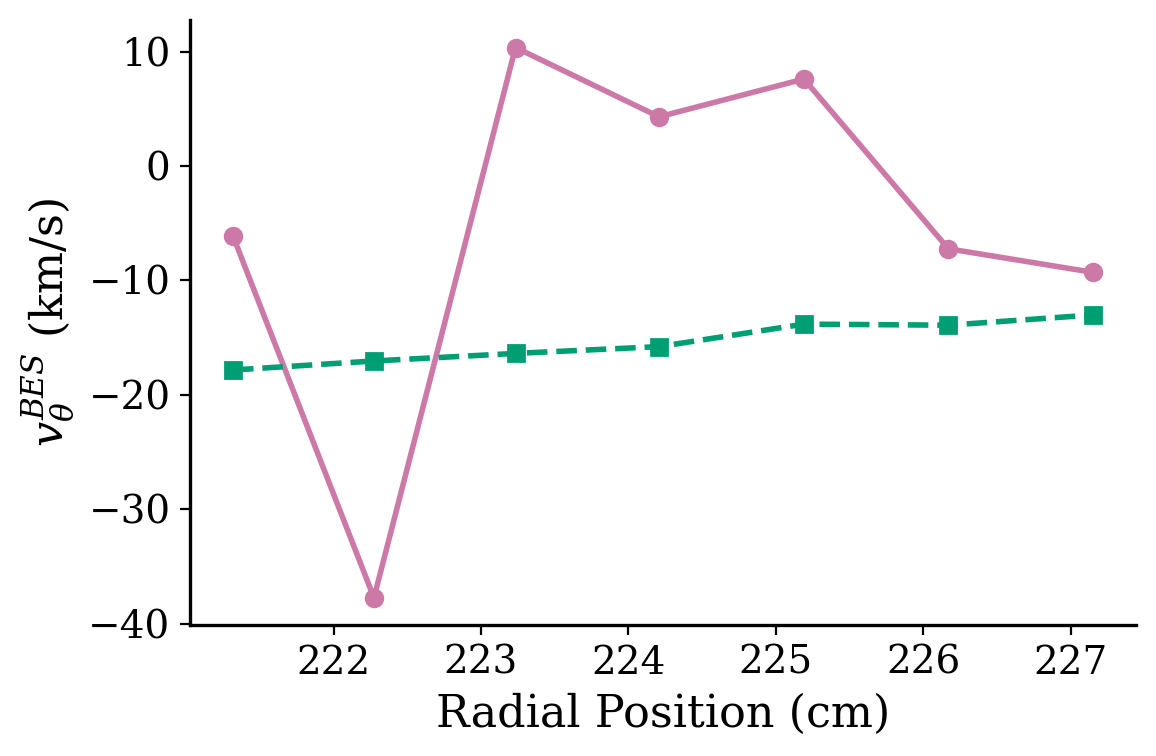

In [4]:
import matplotlib as mpl
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'mathtext.fontset': 'dejavuserif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 1.2,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'figure.dpi' : 200,
})

def backward_rolling_average(signal: np.ndarray, window_size: int = 5) -> np.ndarray:
    if window_size <= 1 or window_size > len(signal):
        return signal.copy()

    smoothed = np.zeros_like(signal)
    current_sum = 0.0
    start_idx = 0

    for i in range(len(signal)):
        current_sum += signal[i]
        # Drop values that move out of the window
        if i - window_size >= 0:
            current_sum -= signal[i - window_size]
            start_idx += 1
        count = i - start_idx + 1
        smoothed[i] = current_sum / count

    return smoothed

def low_pass_filter(signal: np.ndarray, times: np.ndarray, cutoff: float, order: int = 2) -> np.ndarray:
    """
    Applies a Butterworth low-pass filter to the signal.

    Args:
        signal: The 1D numpy array to filter.
        times: The corresponding times array (assumed to be in ms).
        cutoff: The cutoff frequency in Hz.
        order: The order of the Butterworth filter.
    
    Returns:
        The filtered signal as a numpy array.
    """
    # Convert times from ms to seconds
    dt = np.mean(np.diff(times)) / 1000.0  # average time step in seconds
    fs = 1.0 / dt                          # sampling frequency in Hz
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def plot_radial_profile_vs_truth(hdf5_file: str,
                                 time_range: tuple = (2500, 3000),
                                 filter_method: str = "rolling",
                                 rolling_window_size: int = 5,
                                 lowpass_cutoff: float = 10.0,
                                 lowpass_order: int = 2,
                                 downsample_factor: int = 1,
                                 colors=['#D55E00', '#0072B2']):
    """
    Reads an HDF5 file containing shot-level predictions, times, and radial positions.
    For each shot, it:
      1) sorts data by time and optionally downsamples,
      2) applies a chosen smoothing/filter (rolling or low-pass),
      3) masks data within a given time interval [time_range[0], time_range[1]],
      4) averages predictions and truth within that time interval for each radial position,
      5) plots the radial profile of the velocity (model vs. ground truth).

    Args:
        hdf5_file: Path to the HDF5 file.
        time_range: A tuple (t_min, t_max) specifying the time interval (ms) to average over.
        filter_method: "rolling" or "lowpass".
        rolling_window_size: Window size for backward rolling average.
        lowpass_cutoff: Cutoff frequency (Hz) for the Butterworth filter.
        lowpass_order: Filter order for the Butterworth filter.
        downsample_factor: Integer factor for optional downsampling.
        colors: List of colors to use for plotting [model, ground truth].
    """
    with h5py.File(hdf5_file, 'r') as f:
        shot_ids = list(f.keys())  # e.g. ["191670", "199718", ...]

        for shot_id in shot_ids:
            group = f[shot_id]
            
            predictions = group["predictions"][()]        
            true_labels = group["true_labels"][()]         
            times       = group["times"][()]               
            r_positions = group["radial_positions"][()]    

            unique_rpos = np.unique(r_positions)

            # We'll store the averaged predictions & truth for each radial position
            avg_preds_per_r = []
            avg_trues_per_r = []
            radial_vals     = []

            for rpos in unique_rpos:
                rp_mask  = (r_positions == rpos)

                rp_times = times[rp_mask]
                rp_preds = predictions[rp_mask]
                rp_trues = true_labels[rp_mask]

                # Sort by time
                sort_idx = np.argsort(rp_times)
                rp_times = rp_times[sort_idx]
                rp_preds = rp_preds[sort_idx]
                rp_trues = rp_trues[sort_idx]

                # Downsample
                if downsample_factor > 1:
                    rp_times = rp_times[::downsample_factor]
                    rp_preds = rp_preds[::downsample_factor]
                    rp_trues = rp_trues[::downsample_factor]

                # Filter
                if filter_method == "rolling":
                    rp_preds_filtered = backward_rolling_average(rp_preds, window_size=rolling_window_size)
                elif filter_method == "lowpass":
                    rp_preds_filtered = low_pass_filter(rp_preds, rp_times, cutoff=lowpass_cutoff, order=lowpass_order)
                else:
                    raise ValueError("filter_method must be either 'rolling' or 'lowpass'.")

                # Mask the time range
                mask = (rp_times >= time_range[0]) & (rp_times <= time_range[1])
                rp_preds_in_range = rp_preds_filtered[mask]
                rp_trues_in_range = rp_trues[mask]

                # If we have data in that time range, compute the mean
                if len(rp_preds_in_range) > 0:
                    avg_preds = np.mean(rp_preds_in_range)
                    avg_trues = np.mean(rp_trues_in_range)
                    avg_preds_per_r.append(avg_preds)
                    avg_trues_per_r.append(avg_trues)
                    radial_vals.append(rpos)

            # Now plot the radial profile for this shot
            if len(radial_vals) > 0:
                # Sort by radial position to make a nicer plot
                sort_idx = np.argsort(radial_vals)
                radial_vals     = np.array(radial_vals)[sort_idx]
                avg_preds_per_r = np.array(avg_preds_per_r)[sort_idx]
                avg_trues_per_r = np.array(avg_trues_per_r)[sort_idx]

                fig, ax = plt.subplots(figsize=(6,4))
                ax.plot(radial_vals, avg_trues_per_r, 
                        label="CCTD ground truth", 
                        marker='o', linestyle='-', color=colors[1], lw=2.0)
                ax.plot(radial_vals, avg_preds_per_r, 
                        label="Model prediction", 
                        marker='s', linestyle='--', color=colors[0], lw=2.0)

                ax.set_xlabel("Radial Position (cm)")
                ax.set_ylabel(r"$v^{BES}_{\theta}$ (km/s)")
                # ax.set_title(f"Shot {shot_id} | Time-avg in [{time_range[0]}, {time_range[1]}] ms")
                print(f"Shot {shot_id} | Time-avg in [{time_range[0]}, {time_range[1]}] ms")
                # ax.set_ylim(-25, -5)  # Adjust the limits as needed
                # ax.set_yticks(np.linspace(-25, -5, 5))
                # ax.legend()
                plt.tight_layout()
                plt.show()

                # If you prefer saving:
                # fig.savefig(f"shot_{shot_id}_radial_profile_{time_range[0]}_{time_range[1]}.png", 
                #             bbox_inches='tight', dpi=300)
                # plt.close(fig)

# Example usage:
colors = ["#009E73", "#CC79A7"]
hdf5_path = "/pscratch/sd/k/kevinsg/bes_ml_jobs/exp_gill01/36496223/predictions_2.hdf5"
plot_radial_profile_vs_truth(hdf5_file=hdf5_path,
                             time_range=(3500, 4000),
                             filter_method='lowpass',
                             lowpass_cutoff=100,
                             lowpass_order=1,
                            #  filter_method='rolling', 
                            #  rolling_window_size=10,
                            #  downsample_factor=10,
                             colors=colors)


⚠️  Shot 157303 not found, skipping.
⚠️  Shot 157322 not found, skipping.
⚠️  Shot 157323 not found, skipping.
⚠️  Shot 157272 not found, skipping.
⚠️  Shot 157374 not found, skipping.
⚠️  Shot 157375 not found, skipping.
⚠️  Shot 157376 not found, skipping.
⚠️  Shot 157377 not found, skipping.
⚠️  Shot 158076 not found, skipping.
⚠️  Shot 189191 not found, skipping.


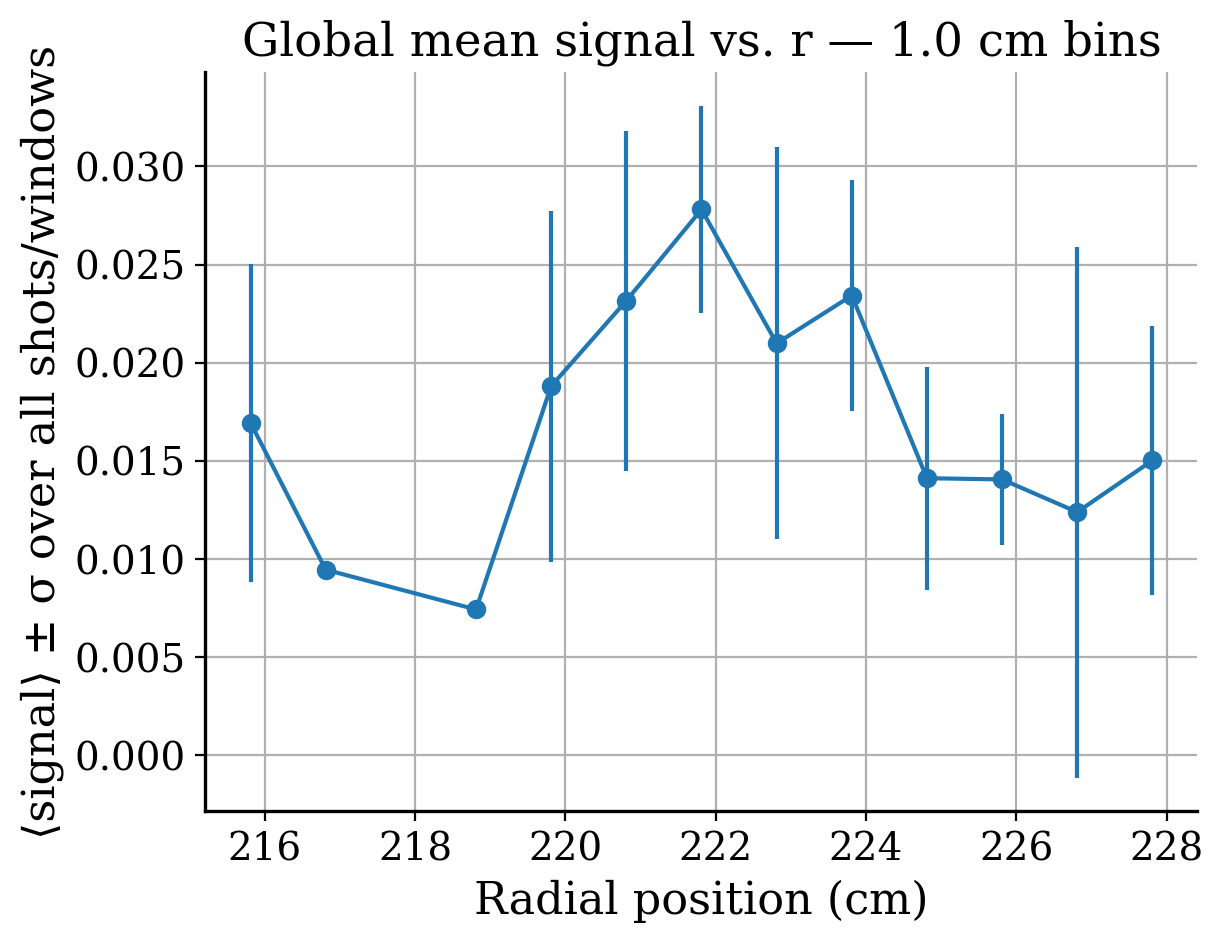

In [21]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# — your inputs —
data_file = '/pscratch/sd/k/kevinsg/bes_ml_jobs/confinement_data/20250411_interp.hdf5'

shot_radial_time_windows={
    '145384': {1: [[900, 5000]], 2: [[1000, 5100]], 6: [[2500, 5000]]}, 
    '145385': {1: [[710, 4300]], 2: [[710, 4300]], 3: [[710, 1100]], 5: [[710, 1100]], 6: [[800, 4300]], 7: [[1700, 4300]]}, 
    '145387': {1: [[1000, 5150]], 2: [[2000, 5150]], 3: [[2500, 5150]], 4:[[2500, 5150]], 5: [[2500, 5150]], 6: [[2500, 5150]]}, 
    '145388': {1: [[900, 1500], [2000, 5100]], 2: [[900, 1500], [2000, 5100]], 6: [[2000, 2500]]}, 
    '145391': {1: [[2000, 4000]], 2: [[2000, 4400]]}, 
    '145410': {1: [[1500, 3500]], 2: [[1600, 3500]], 6: [[1200, 3500]], 7: [[1800, 2350], [2500, 3500]]},
    '145419': {1: [[1000, 5100]], 2: [[1700, 5100]], 6: [[1600, 5100]], 7: [[1800, 5100]]}, 
    '145420': {1: [[1000, 2350], [2550, 4500]], 2: [[2550, 4500]], 7: [[2900, 4500]]}, 
    '145422': {1: [[2500, 4700]], 2: [[2500, 4700]], 7: [[2000, 4600]]}, 
    '145425': {1: [[800, 5200]], 2: [[900, 5200]], 6: [[1500, 5200]], 7: [[2450, 5200]]}, 
    '145427': {1: [[2500, 5200]], 2: [[2500, 5200]], 6: [[2000, 5200]]}, 
    '157303': {}, 
    '157322': {}, 
    '157323': {0: [[1500, 5000]], 1: [[1500, 4800]]}, 
    '157272': {}, 
    '157373': {0: [[900, 1200], [1700, 6000]], 1: [[1800, 6000]]}, 
    '157374': {}, 
    '157375': {}, 
    '157376': {}, 
    '157377': {0: [[900, 5400]]}, 
    '158076': {1: [[2000, 6000]], 2: [[2500, 5000]], 4:[[2000, 6000]], 5: [[2000, 6000]]}, 
    '159443': {1: [[2500, 5400]], 2: [[2500, 5200]], 4:[[2000, 5200]], 5: [[2000, 5200]], 6: [[2600, 5200]], 7: [[2900, 5200]]}, 
    '189191': {}, 
    '200021': {0: [[2000, 4300]], 1: [[2000, 4000]], 2: [[2550, 4000]]},
    '200632': {0: [[400, 1000], [1900, 4500]], 1: [[400, 800], [1900, 2500]], 6: [[1400, 1800]]},
    '200634': {0: [[400, 1000], [2000, 3300], [3500, 4500]], 1: [[400, 1000], [2000, 3400], [4000, 4500]], 2: [[1900, 4500]], 3: [[1900, 4500]], 6:[[2000, 4500]]},
    '200635': {0: [[1900, 4500]], 1: [[800, 5200]], 2: [[1700, 4500]], 3: [[2000, 4400]]},
    '200637': {0: [[1900, 3700]], 1: [[400, 800]], 2: [[1900, 3800]], 3: [[1100, 1700], [1900, 3800]], 4: [[1900, 3800]], 5: [[2000, 3800]], 6: [[1100, 1700]]},
    '200638': {0: [[1900, 4500]], 1: [[400, 900]], 2: [[1900, 4500]], 3: [[1900, 4000]], 4: [[2000, 3500]], 5: [[2000, 3500]]},
    '200639': {2: [[1950, 4700]], 3: [[1100, 4700]], 4: [[2100, 4700]], 5: [[2400, 4700]], 6: [[1500, 4700]]},
    '200643': {0: [[2300, 4500]], 1: [[400, 900], [2400, 3600]], 2: [[2300, 4700]], 3: [[2400, 4700]], 4: [[2500, 4700]], 5: [[2500, 4700]], 6: [[1500, 4700]]},
}


bin_size_cm = 1.0   # or 1.5

# — helper that also returns radial‑pos per cell —
def reshape_signals_and_positions(signals, inboard_order, r_pos_all, n_rows, n_cols):
    """
    signals: (n_ch, N);  
    inboard_order: array of length ≥ n_rows;  
    r_pos_all:   length n_ch array of channel radial positions.
    Returns:
      data[n_rows, n_cols, N],  rpos[n_rows, n_cols]
    """
    data = np.zeros((n_rows, n_cols, signals.shape[1]), dtype=signals.dtype)
    rpos = np.zeros((n_rows, n_cols), dtype=float)
    for row in range(n_rows):
        start = int(inboard_order[row])
        for col in range(n_cols):
            chan = start + col - 1    # drop the “-1” if your inboard_order is already 0‑based
            if 0 <= chan < signals.shape[0]:
                data[row, col, :] = signals[chan, :]
                rpos[row, col]     = r_pos_all[chan]
            else:
                data[row, col, :] = np.nan
                rpos[row, col]     = np.nan
    return data, rpos

# — accumulate over shots/windows/cols —
radial_list = []
mean_list   = []
std_list    = []

with h5py.File(data_file, 'r') as f:
    for shot, col_dict in shot_radial_time_windows.items():
        if shot not in f:
            print(f"⚠️  Shot {shot} not found, skipping.")
            continue

        grp = f[shot]
        inb_order = grp.attrs['inboard_column_channel_order']
        r_pos_all = grp.attrs['r_position']

        # pick the first “start‐time” subgroup (710, 900, etc.)
        st = next(k for k in grp.keys() if k.isdigit())
        signals = grp[st]['signals'][...]   # (n_ch, N)
        times   = grp[st]['times'][...]     # (N,)

        n_ch, N = signals.shape
        n_rows  = len(inb_order)
        n_cols  = n_ch // n_rows

        # reshape once for this shot
        data3d, rpos3d = reshape_signals_and_positions(
            signals, inb_order, r_pos_all, n_rows, n_cols
        )

        # loop columns & windows
        for col_idx, windows in col_dict.items():
            for (t0, t1) in windows:
                mask = (times >= t0) & (times <= t1)
                # slice: shape = (n_rows, n_times_in_window)
                block = data3d[:, col_idx, :][:, mask]

                # flatten all rows×time samples
                flat = block.flatten()
                radial = np.nanmean(rpos3d[:, col_idx])

                radial_list.append(radial)
                mean_list.append(np.nanmean(flat))
                std_list.append (np.nanstd (flat))

# convert to arrays
radial = np.array(radial_list)
means  = np.array(mean_list)
stds   = np.array(std_list)

# — bin by radial position —
bins = np.arange(radial.min(), radial.max() + bin_size_cm, bin_size_cm)
inds = np.digitize(radial, bins)

b_centers, b_means, b_stds = [], [], []
for b in range(1, len(bins)):
    sel = (inds == b)
    if not np.any(sel):
        continue
    b_centers.append(0.5 * (bins[b-1] + bins[b]))
    b_means  .append(means [sel].mean())
    b_stds   .append(means [sel].std())

# — final plot —
plt.errorbar(
    b_centers,
    b_means,
    yerr=b_stds,
    marker='o',
    linestyle='-'
)
plt.xlabel('Radial position (cm)')
plt.ylabel('⟨signal⟩ ± σ over all shots/windows')
plt.title(f'Global mean signal vs. r — {bin_size_cm} cm bins')
plt.grid(True)
plt.show()


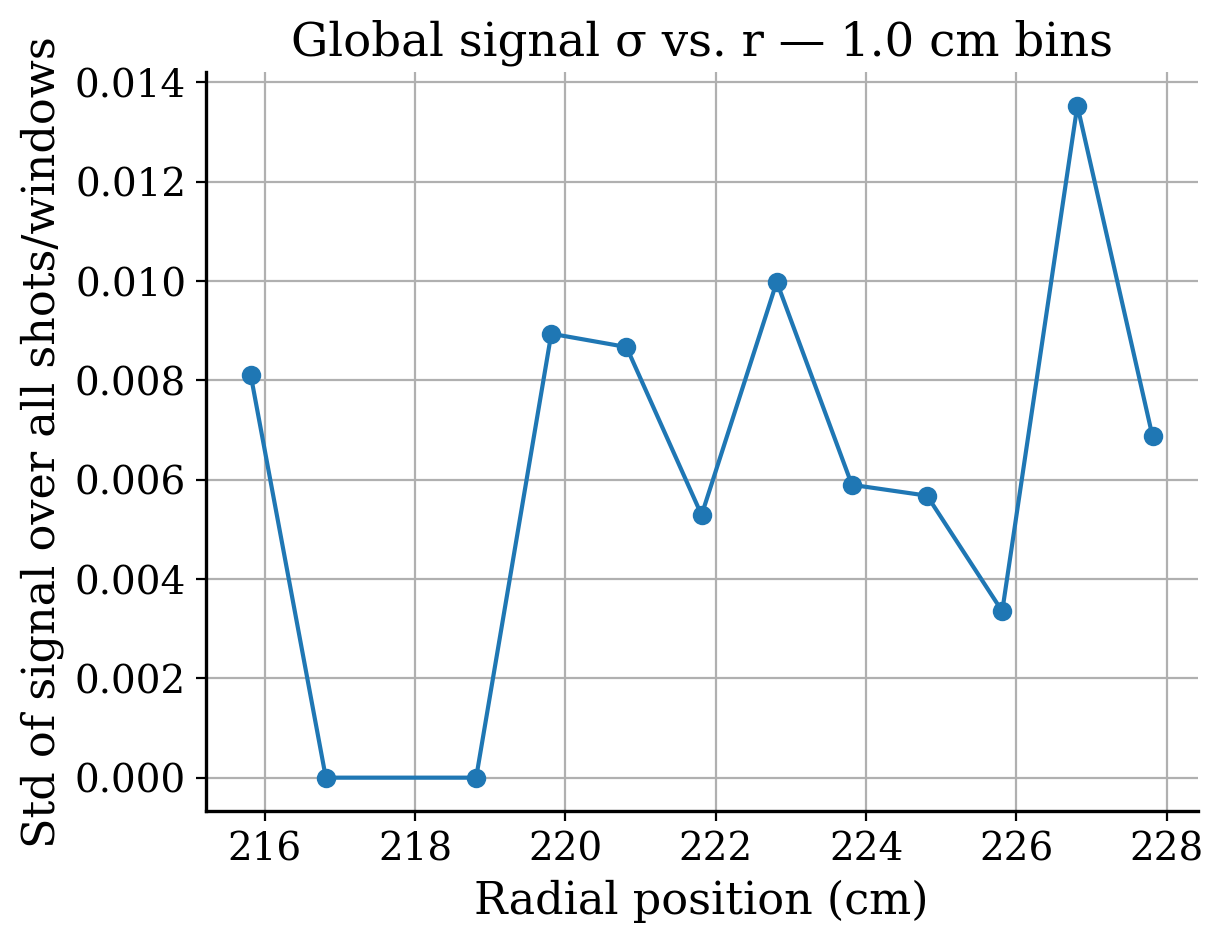

In [22]:
# — now plot std vs. radial position —
plt.figure()
plt.errorbar(
    b_centers,
    b_stds,
    marker='o',
    linestyle='-'
)
plt.xlabel('Radial position (cm)')
plt.ylabel('Std of signal over all shots/windows')
plt.title(f'Global signal σ vs. r — {bin_size_cm} cm bins')
plt.grid(True)
plt.show()

In [31]:
np.std(np.array(b_stds))

np.float64(0.003782247205283367)